# Ross Sea synthetic gravity inversion

import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle
import verde as vd
import xarray as xr
import pandas as pd
import numpy as np
from polartoolkit import maps, fetch, regions, profiles
from polartoolkit import utils as polar_utils
import string
import os
import RIS_gravity_inversion.synthetic as RIS_synth
import RIS_gravity_inversion.plotting as RIS_plotting
import pygmt
import matplotlib.pyplot as plt
import scipy as sp

os.environ['POLARTOOLKIT_HEMISPHERE']='south'

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, synthetic, uncertainty, utils, regional, cross_validation, optimization

# Get synthetic model data

INFO:root:using preprocessed 5km grid since spacing is > 5km
INFO:root:returning grid with new region and/or registration, same spacing


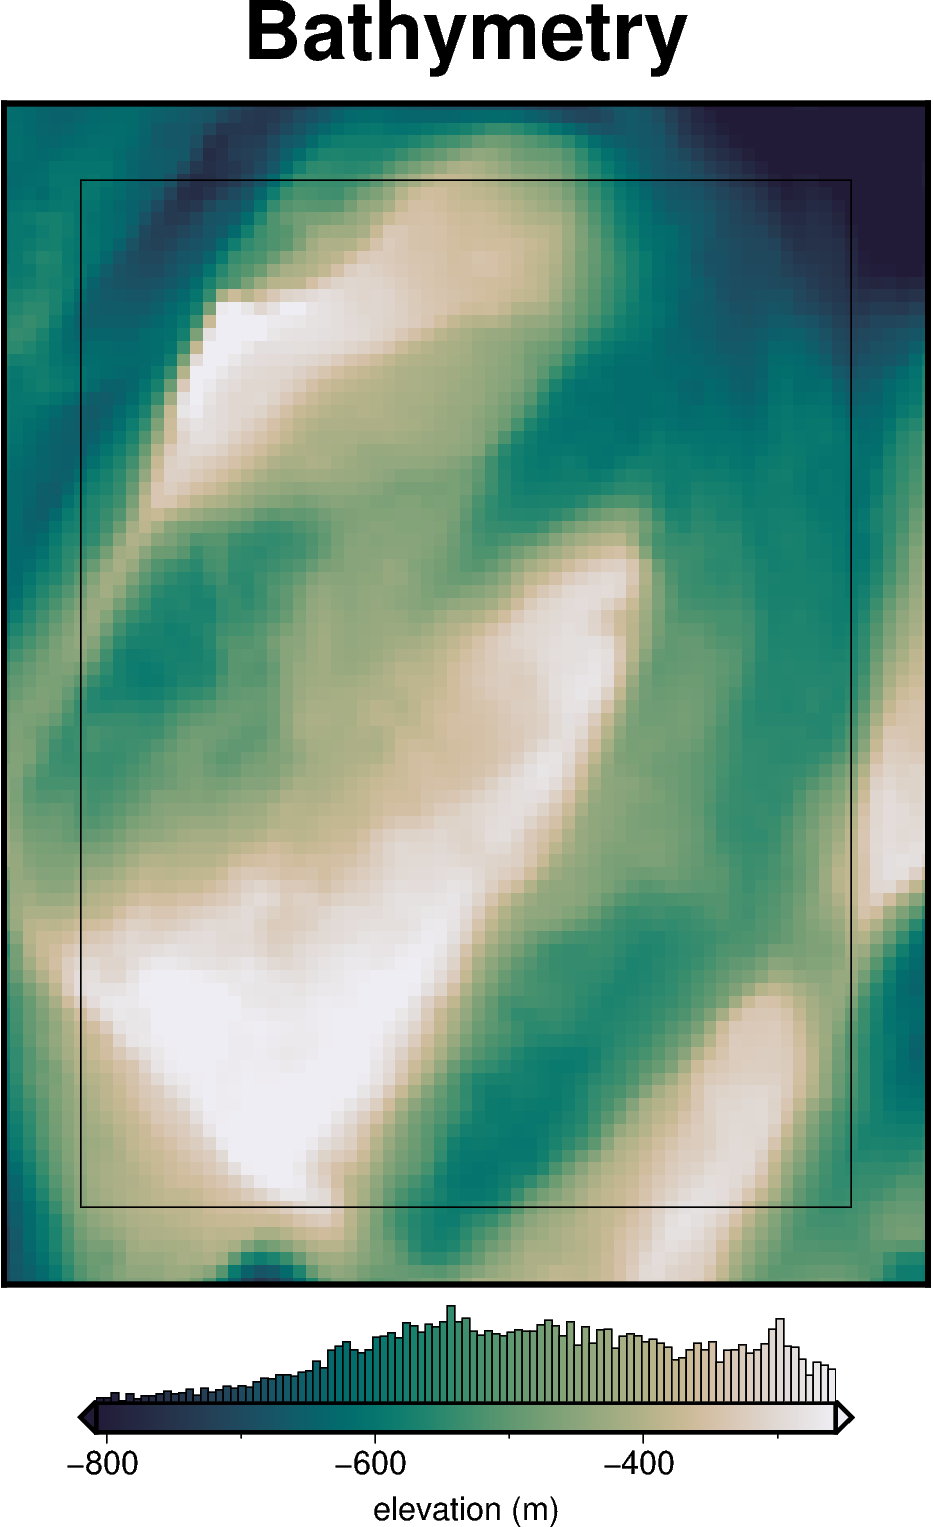

  0%|          | 0/4941 [00:00<?, ?it/s]

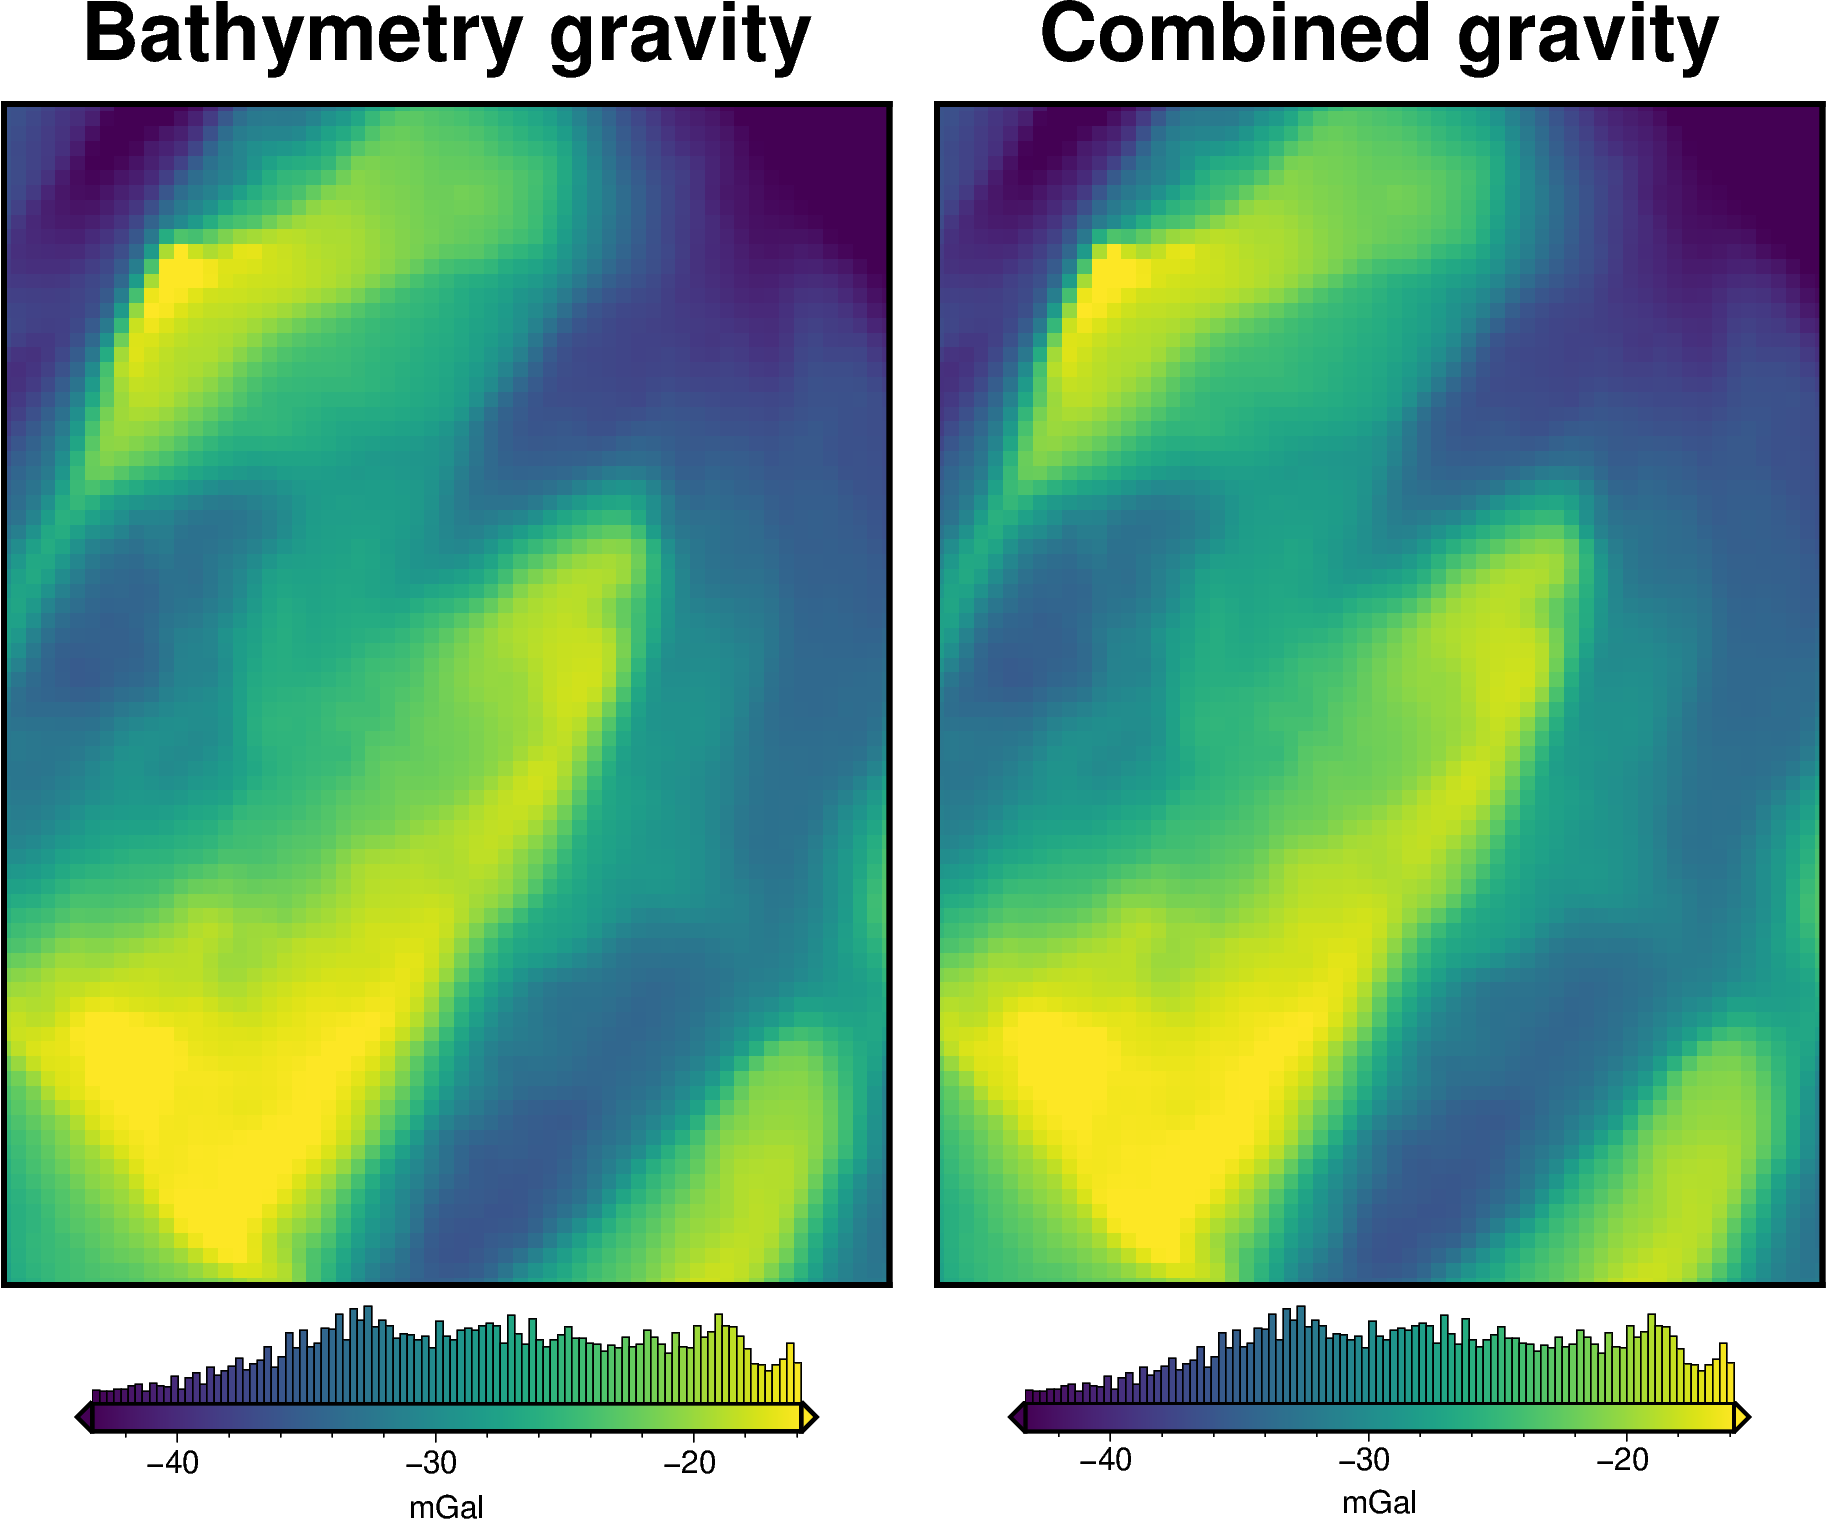

In [2]:
# set grid parameters
spacing = 5e3
inversion_region = (-40e3, 260e3, -1800e3, -1400e3)

bathymetry, basement, grav_df = RIS_synth.load_synthetic_model(
    spacing=spacing,
    buffer=spacing*6,
    # gravity_noise=0,
    zref=0,
    bathymetry_density_contrast=1476,
)

buffer_region = polar_utils.get_grid_info(bathymetry)[1]

In [3]:
grav_df.head()

,northing,easting,upward,bathymetry_grav,basement_grav,disturbance,gravity_anomaly
0,-1800000.0,-40000.0,1000.0,-28.046289,0,-28.046289,-28.046289
1,-1800000.0,-35000.0,1000.0,-26.714502,0,-26.714502,-26.714502
2,-1800000.0,-30000.0,1000.0,-25.919276,0,-25.919276,-25.919276
3,-1800000.0,-25000.0,1000.0,-25.236960,0,-25.236960,-25.236960
4,-1800000.0,-20000.0,1000.0,-24.610928,0,-24.610928,-24.610928


# Make starting bathymetry model

In [4]:
# make a flat starting model at the mean elevation of the true bathymetry
starting_bathymetry = utils.create_topography(
    method="flat",
    upwards=bathymetry.values.mean(),
    region=buffer_region,
    spacing=spacing,
)
starting_bathymetry

<xarray.DataArray 'upward' (northing: 93, easting: 73)> Size: 54kB
array([[-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       ...,
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631]])
Coordinates:
  * easting   (easting) float64 584B -7e+04 -6.5e+04 -6e+04 ... 2.85e+05 2.9e+05
  * northing  (northing) float64 744B -1.83e+06 -1.825e+06 ... -1.37e+06

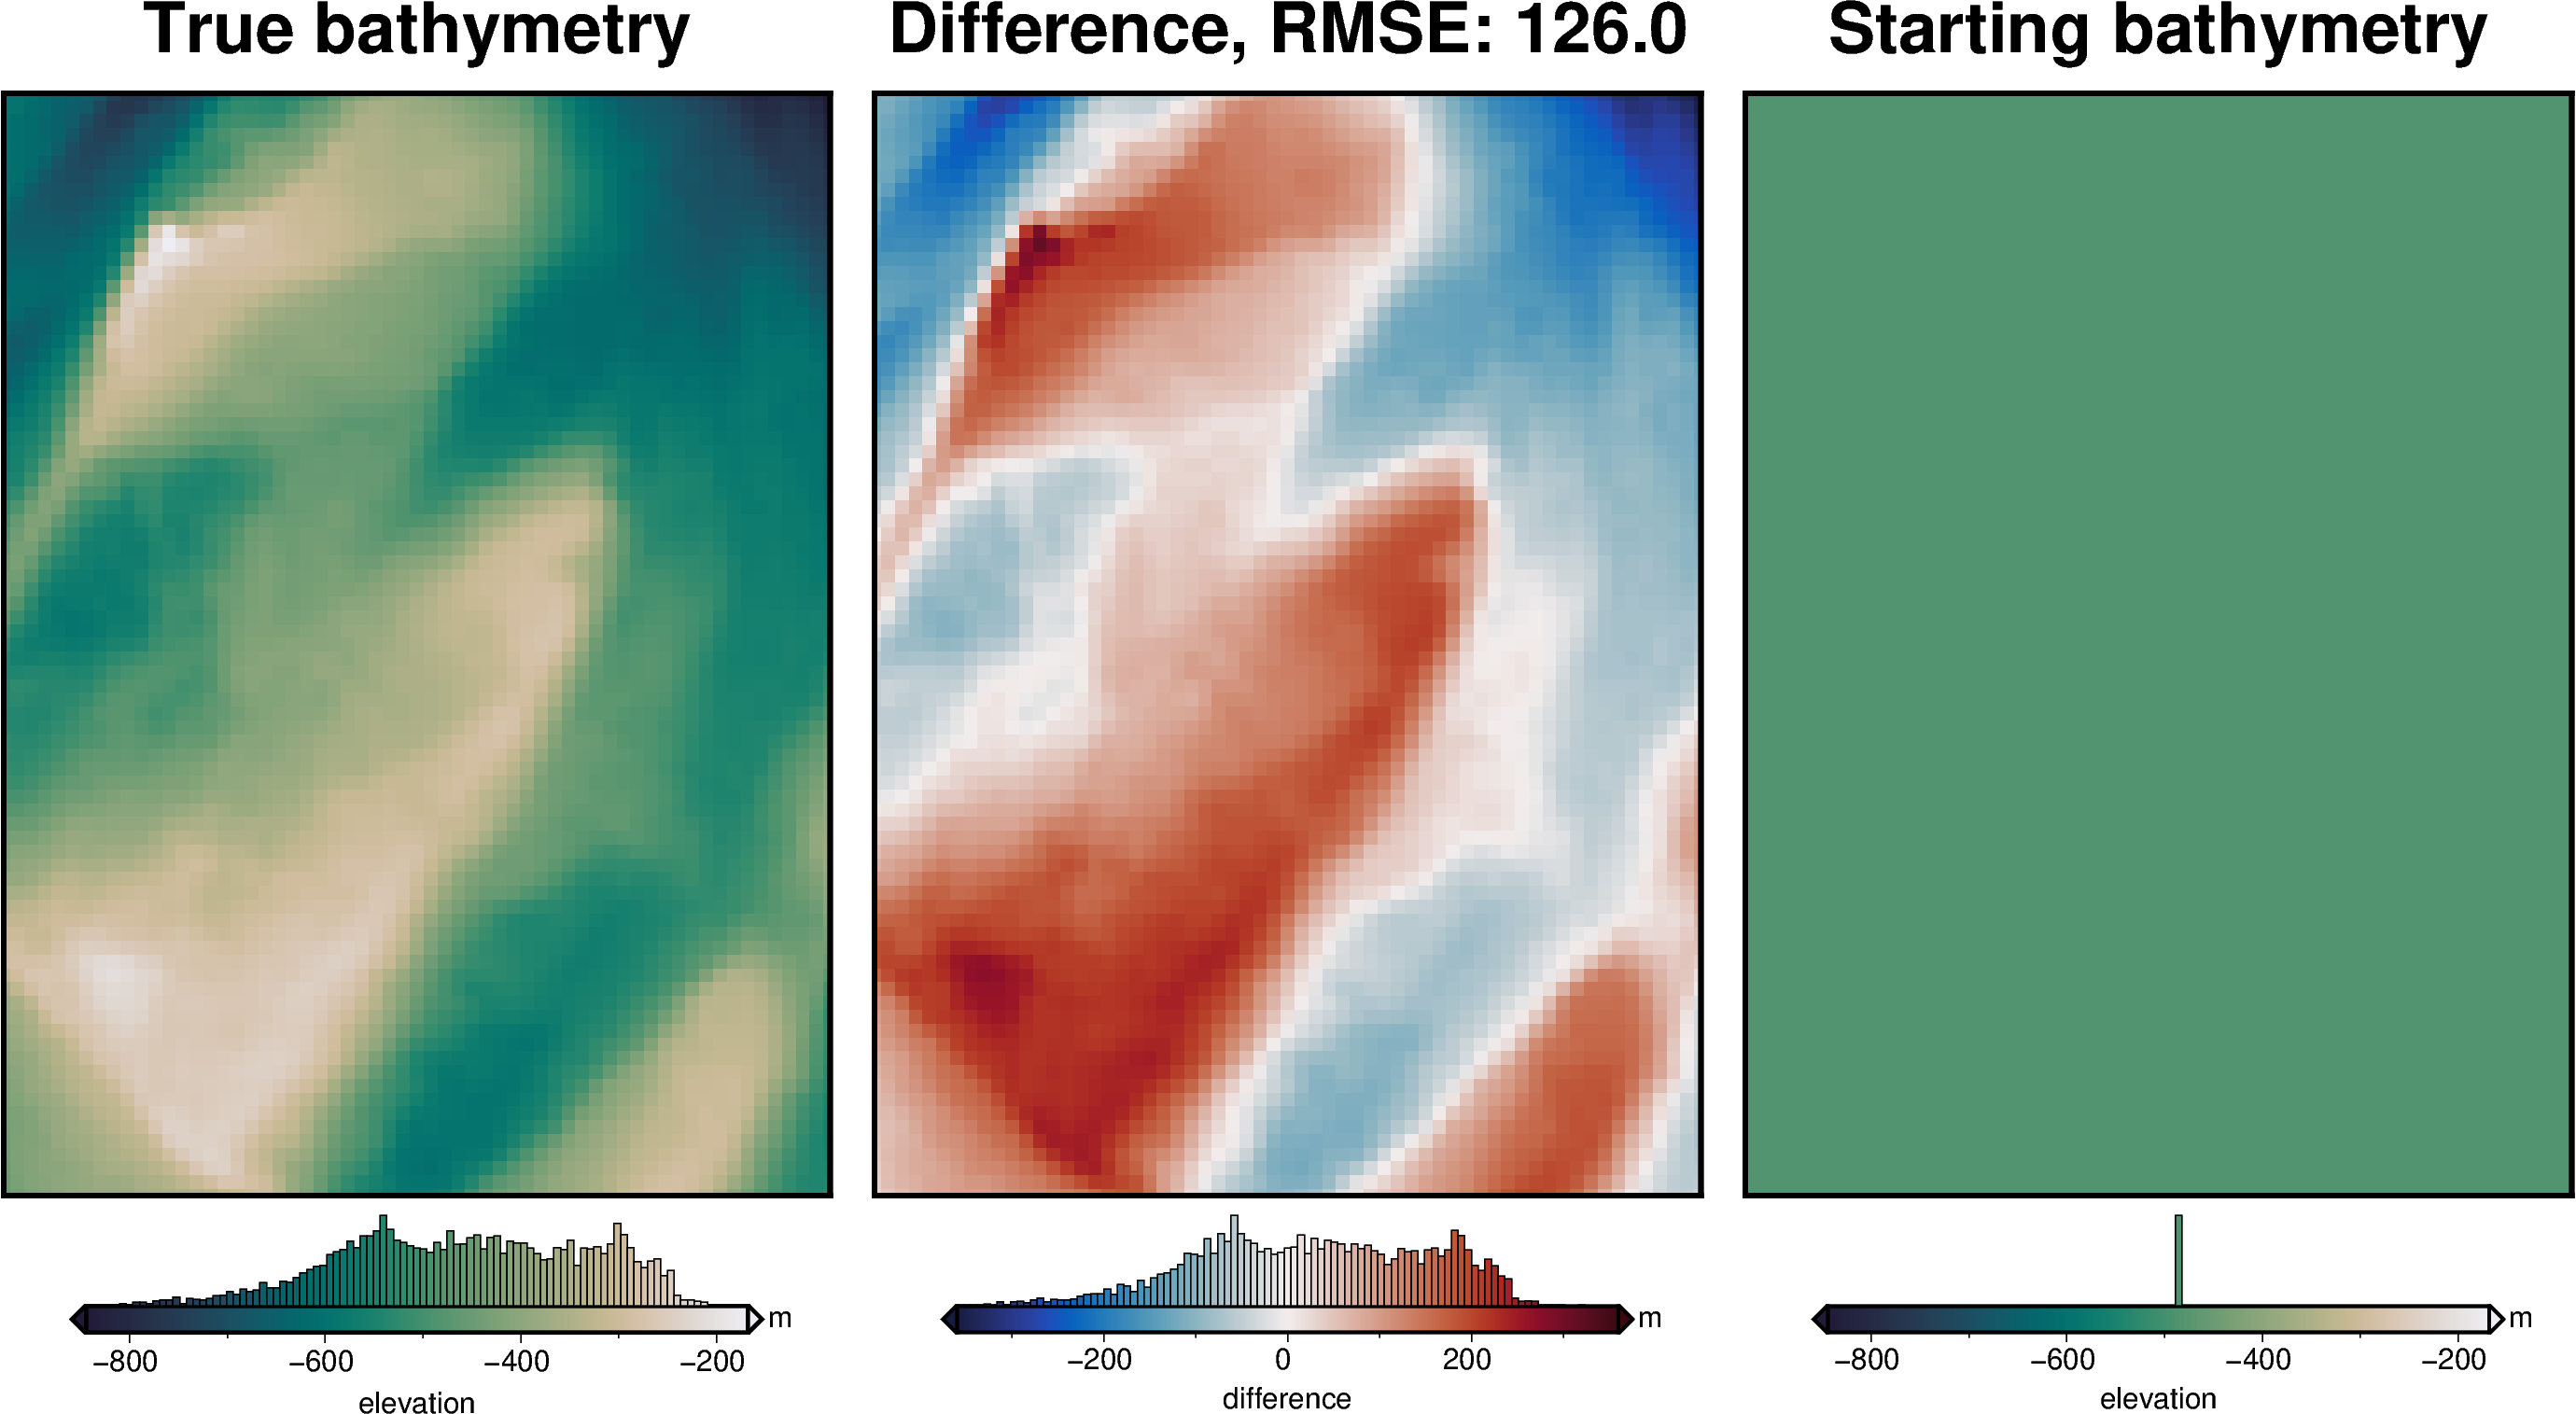

In [5]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    fig_height=10,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True bathymetry",
    grid2_name="Starting bathymetry",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1,
    label_font="16p,Helvetica,black",
)

In [6]:
# the true density contrast is 1476 kg/m3
density_contrast = 1476

# set the reference level from the prisms to 0
zref = 0

density_grid = xr.where(
    starting_bathymetry >=  zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)

grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,bathymetry_grav,basement_grav,disturbance,gravity_anomaly,starting_gravity
0,-1800000.0,-40000.0,1000.0,-28.046289,0,-28.046289,-28.046289,-29.341524
1,-1800000.0,-35000.0,1000.0,-26.714502,0,-26.714502,-26.714502,-29.382051
2,-1800000.0,-30000.0,1000.0,-25.919276,0,-25.919276,-25.919276,-29.412038
3,-1800000.0,-25000.0,1000.0,-25.236960,0,-25.236960,-25.236960,-29.434973
4,-1800000.0,-20000.0,1000.0,-24.610928,0,-24.610928,-24.610928,-29.452985
...,...,...,...,...,...,...,...,...
4936,-1400000.0,240000.0,1000.0,-48.323584,0,-48.323584,-48.323584,-29.452985
4937,-1400000.0,245000.0,1000.0,-48.356131,0,-48.356131,-48.356131,-29.434973
4938,-1400000.0,250000.0,1000.0,-49.079005,0,-49.079005,-49.079005,-29.412038
4939,-1400000.0,255000.0,1000.0,-49.877171,0,-49.877171,-49.877171,-29.382051


In [7]:
regional_grav_kwargs = dict(
    grav_df=grav_df,
    method="constant",
    constant=0,
)
grav_df = regional.regional_separation(**regional_grav_kwargs)

grav_df

,northing,easting,upward,bathymetry_grav,basement_grav,disturbance,gravity_anomaly,starting_gravity,misfit,reg,res
0,-1800000.0,-40000.0,1000.0,-28.046289,0,-28.046289,-28.046289,-29.341524,1.295235,0,1.295235
1,-1800000.0,-35000.0,1000.0,-26.714502,0,-26.714502,-26.714502,-29.382051,2.667549,0,2.667549
2,-1800000.0,-30000.0,1000.0,-25.919276,0,-25.919276,-25.919276,-29.412038,3.492762,0,3.492762
3,-1800000.0,-25000.0,1000.0,-25.236960,0,-25.236960,-25.236960,-29.434973,4.198013,0,4.198013
4,-1800000.0,-20000.0,1000.0,-24.610928,0,-24.610928,-24.610928,-29.452985,4.842057,0,4.842057
...,...,...,...,...,...,...,...,...,...,...,...
4936,-1400000.0,240000.0,1000.0,-48.323584,0,-48.323584,-48.323584,-29.452985,-18.870599,0,-18.870599
4937,-1400000.0,245000.0,1000.0,-48.356131,0,-48.356131,-48.356131,-29.434973,-18.921158,0,-18.921158
4938,-1400000.0,250000.0,1000.0,-49.079005,0,-49.079005,-49.079005,-29.412038,-19.666967,0,-19.666967
4939,-1400000.0,255000.0,1000.0,-49.877171,0,-49.877171,-49.877171,-29.382051,-20.495120,0,-20.495120


makecpt [ERROR]: Option T: min >= max


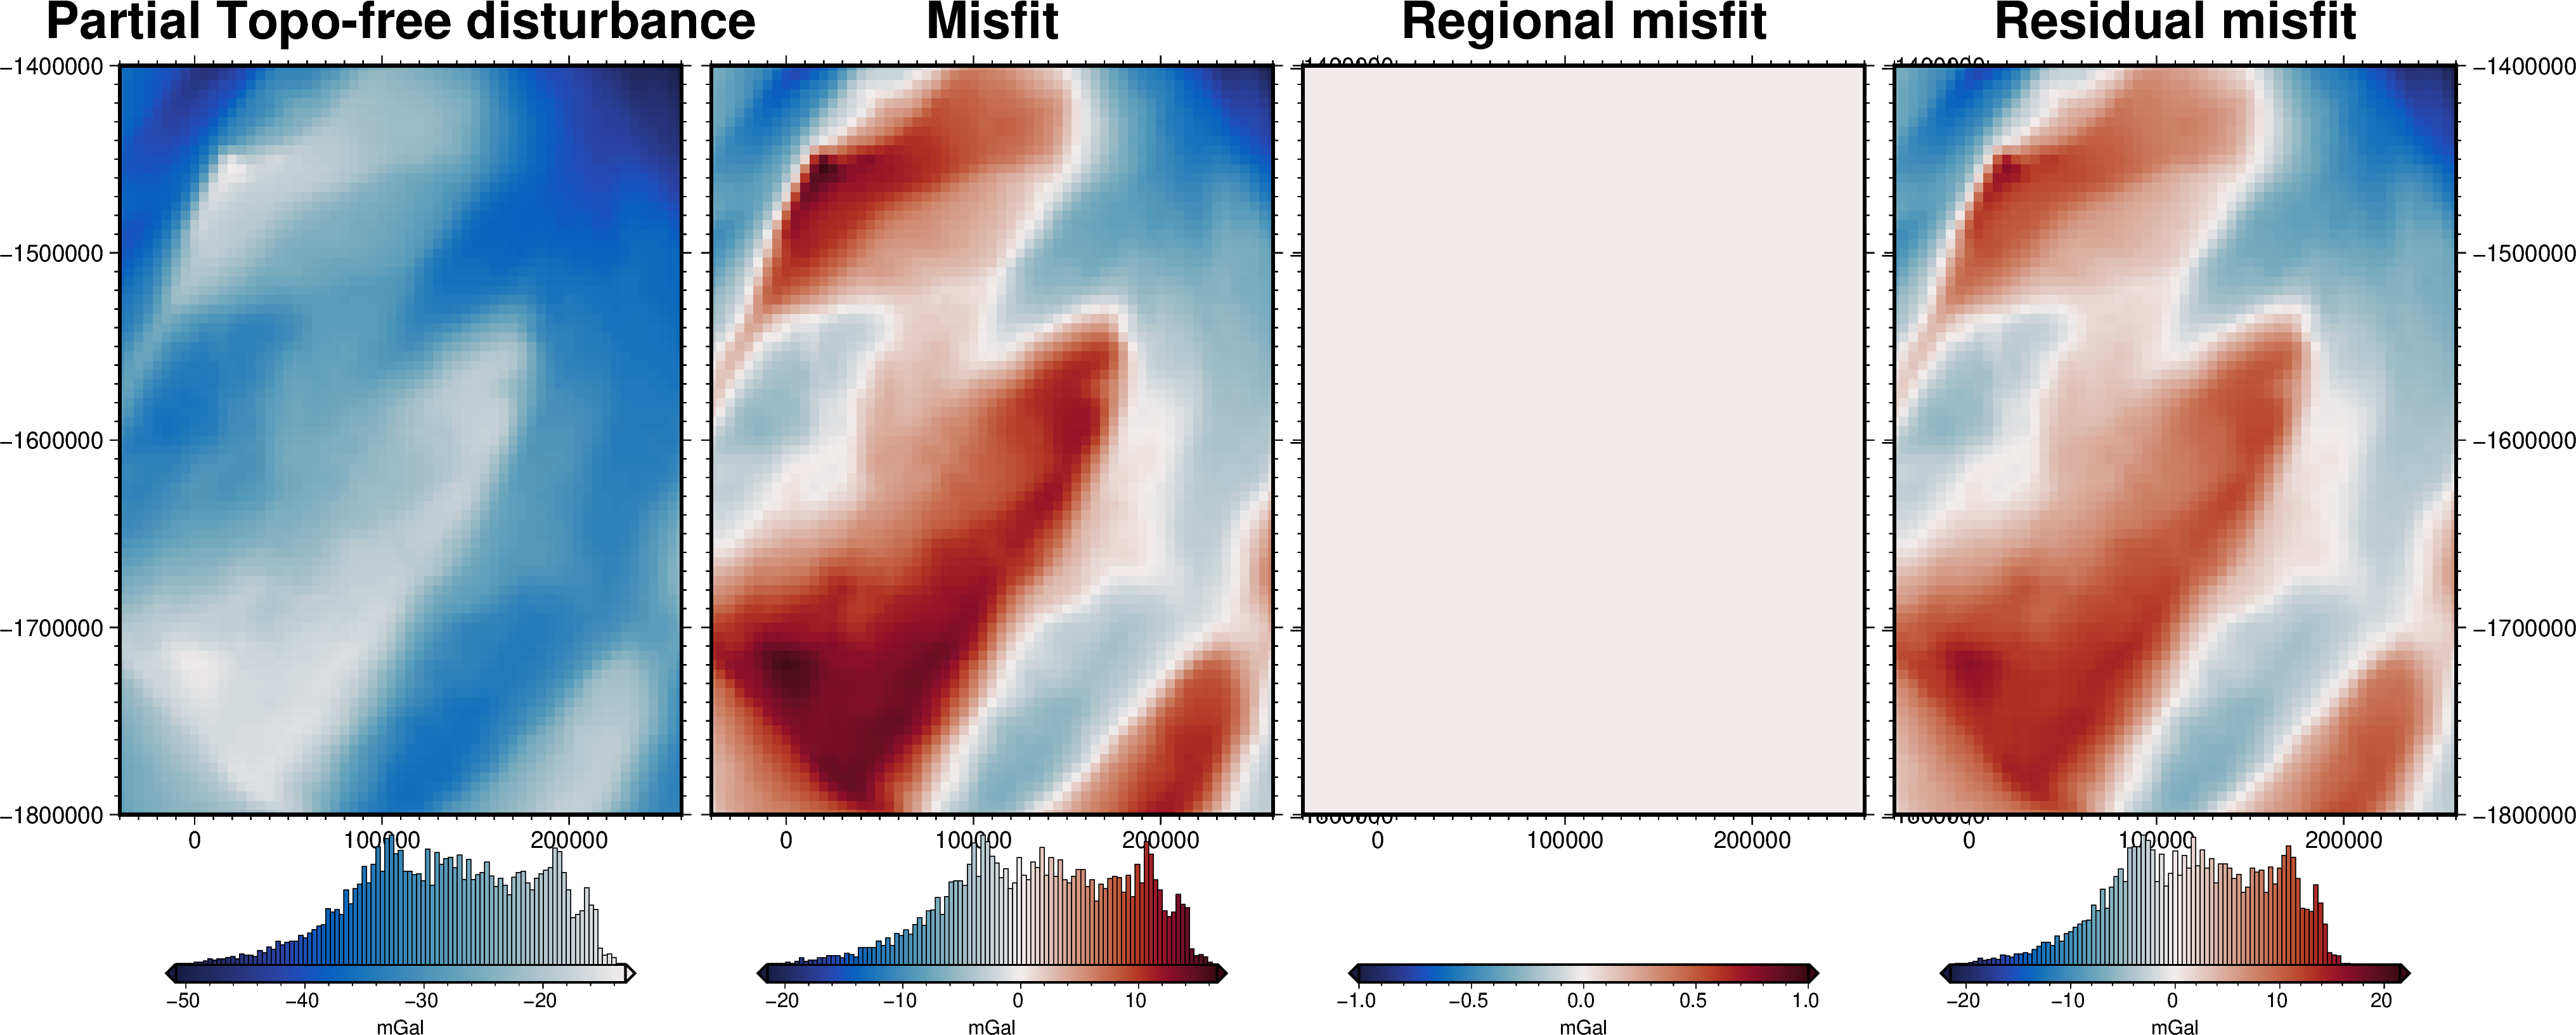

In [8]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Partial Topo-free disturbance",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)
fig.show()

# Run initial inversion
choose a damping value and use the inversion results to set appropriate stopping criteria.

In [9]:
# grav_df.uncert.values.mean() ** .5
.2*.5

0.1

In [10]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": .2**.5, # square root of the gravity noise
    "delta_l2_norm_tolerance": 1.008,
}


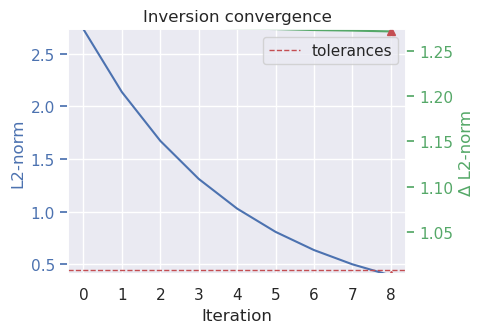

In [71]:
# run the inversion workflow
inversion_results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_prisms=starting_prisms,
    solver_damping=0.01,
    fname="../../results/Ross_Sea_01",
    plot_dynamic_convergence=True,
    **kwargs,
)

In [72]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

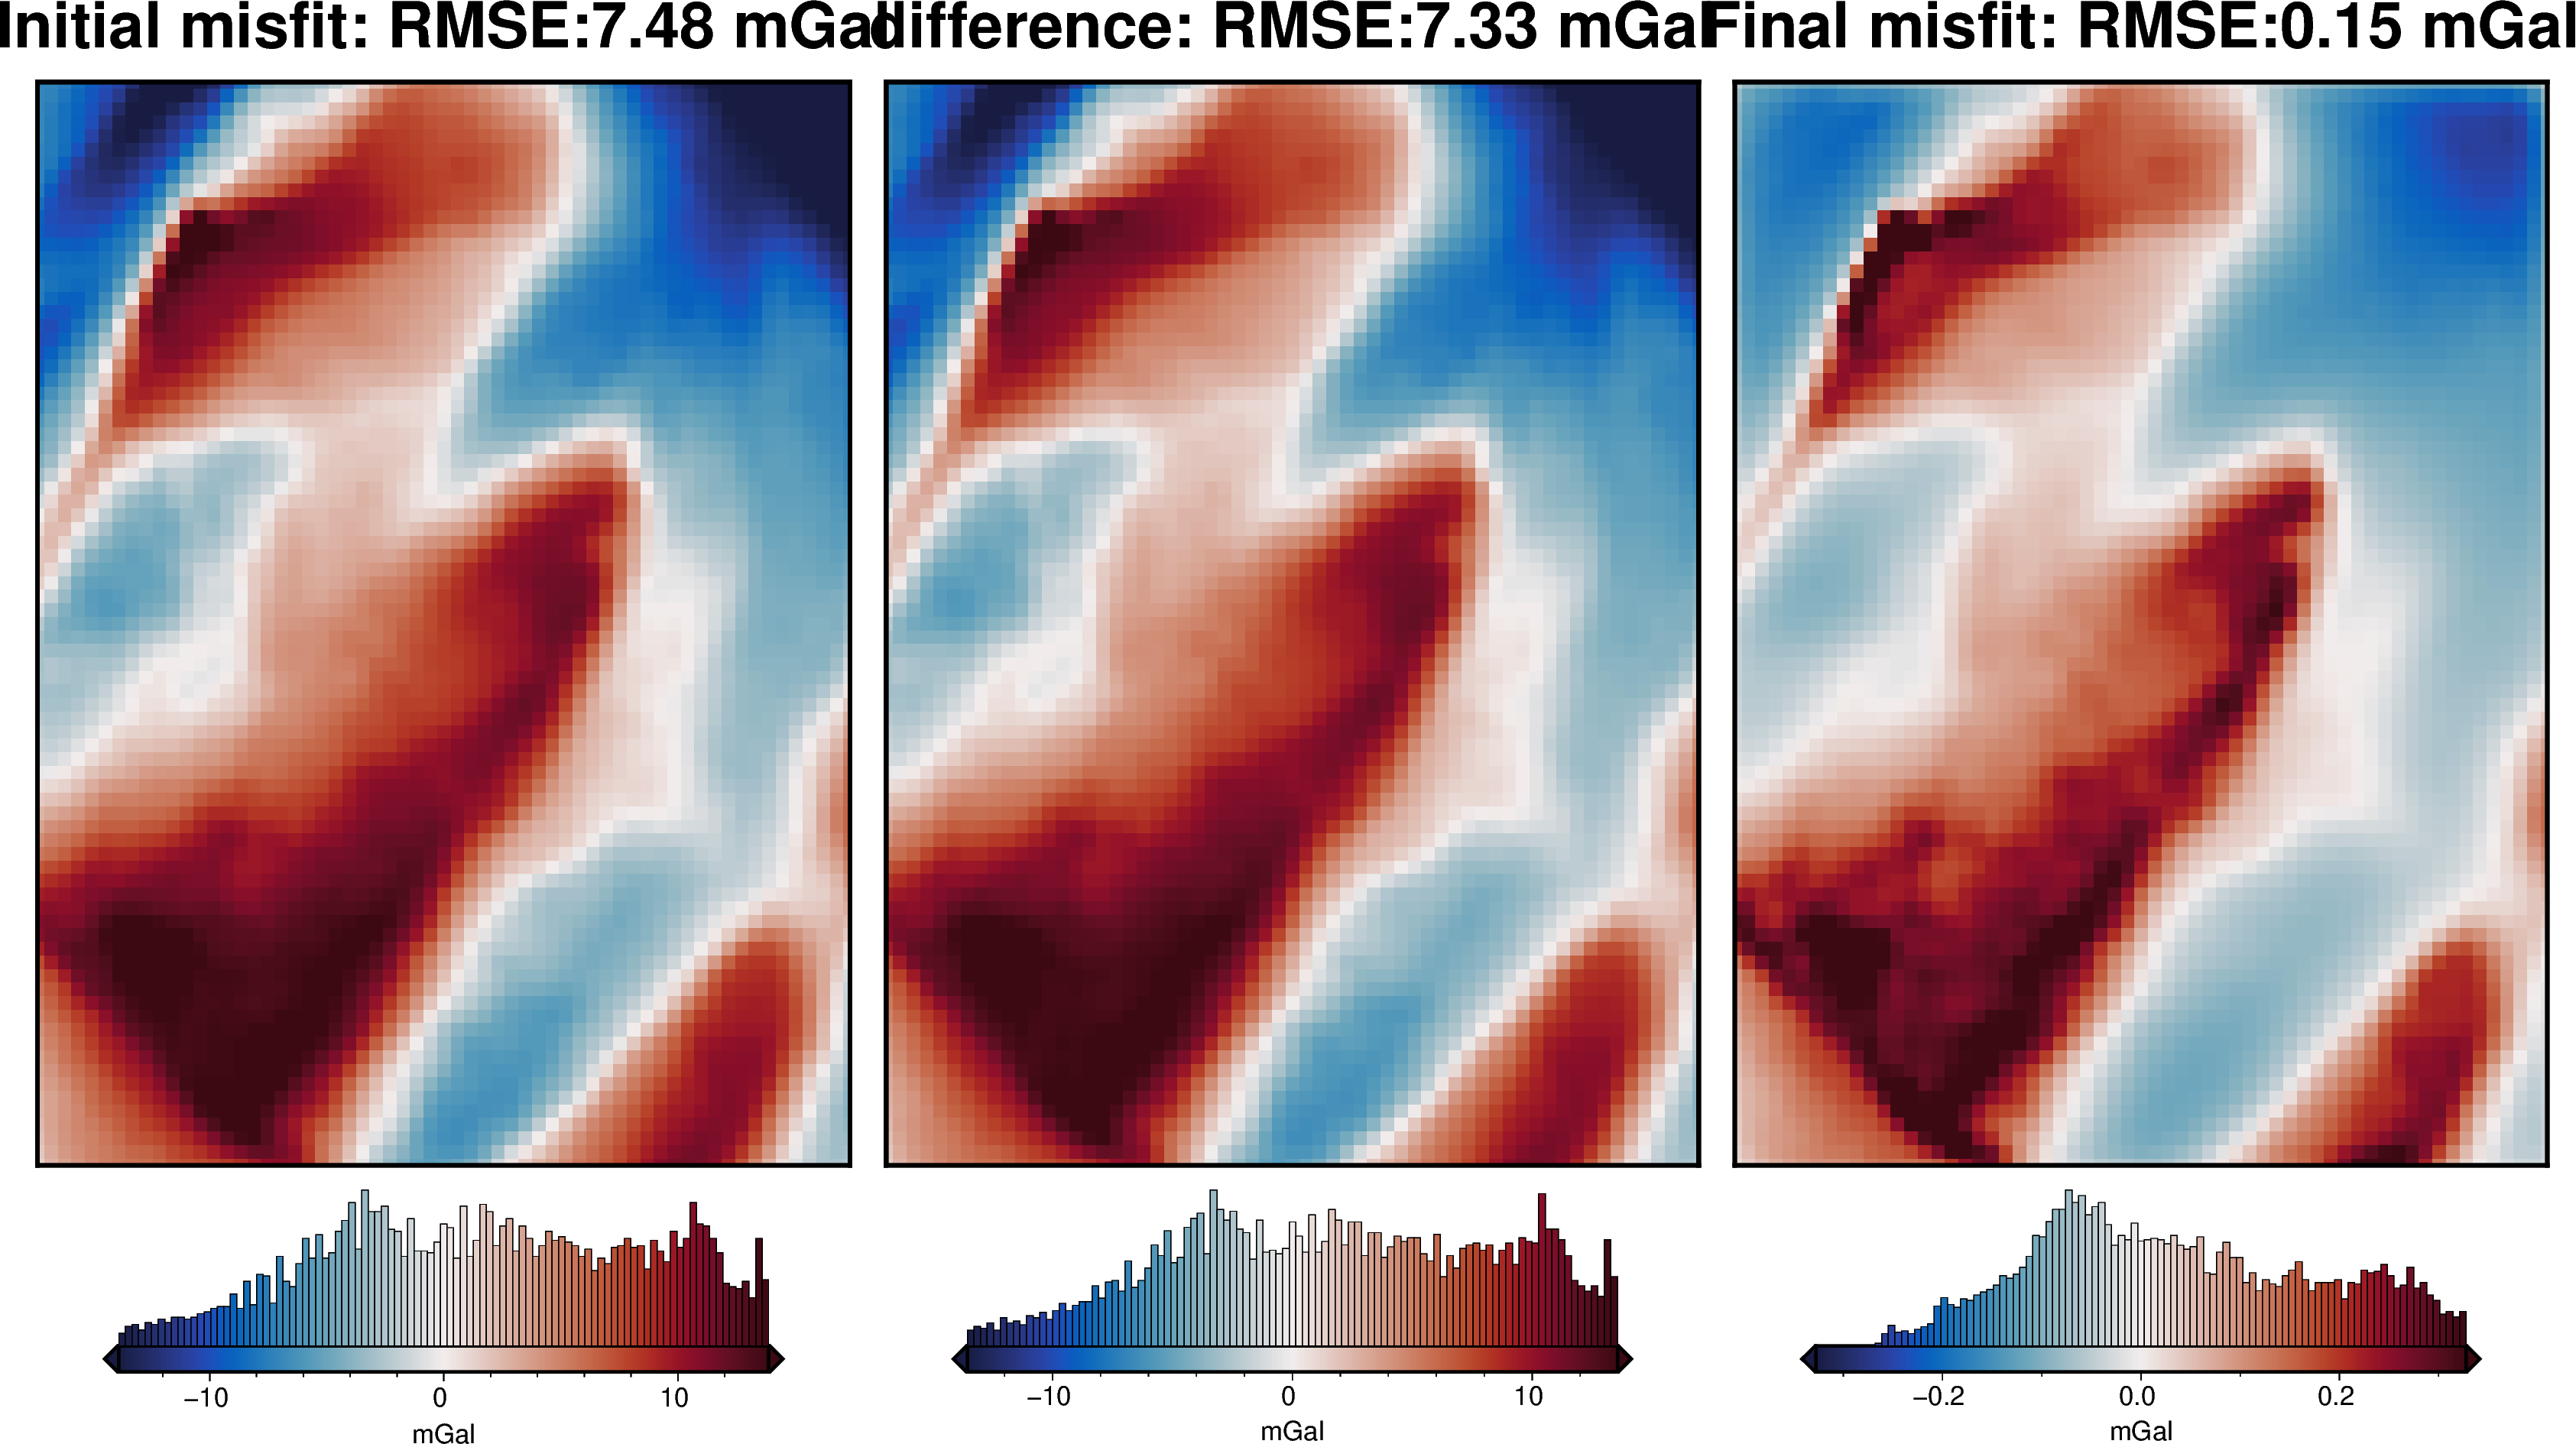

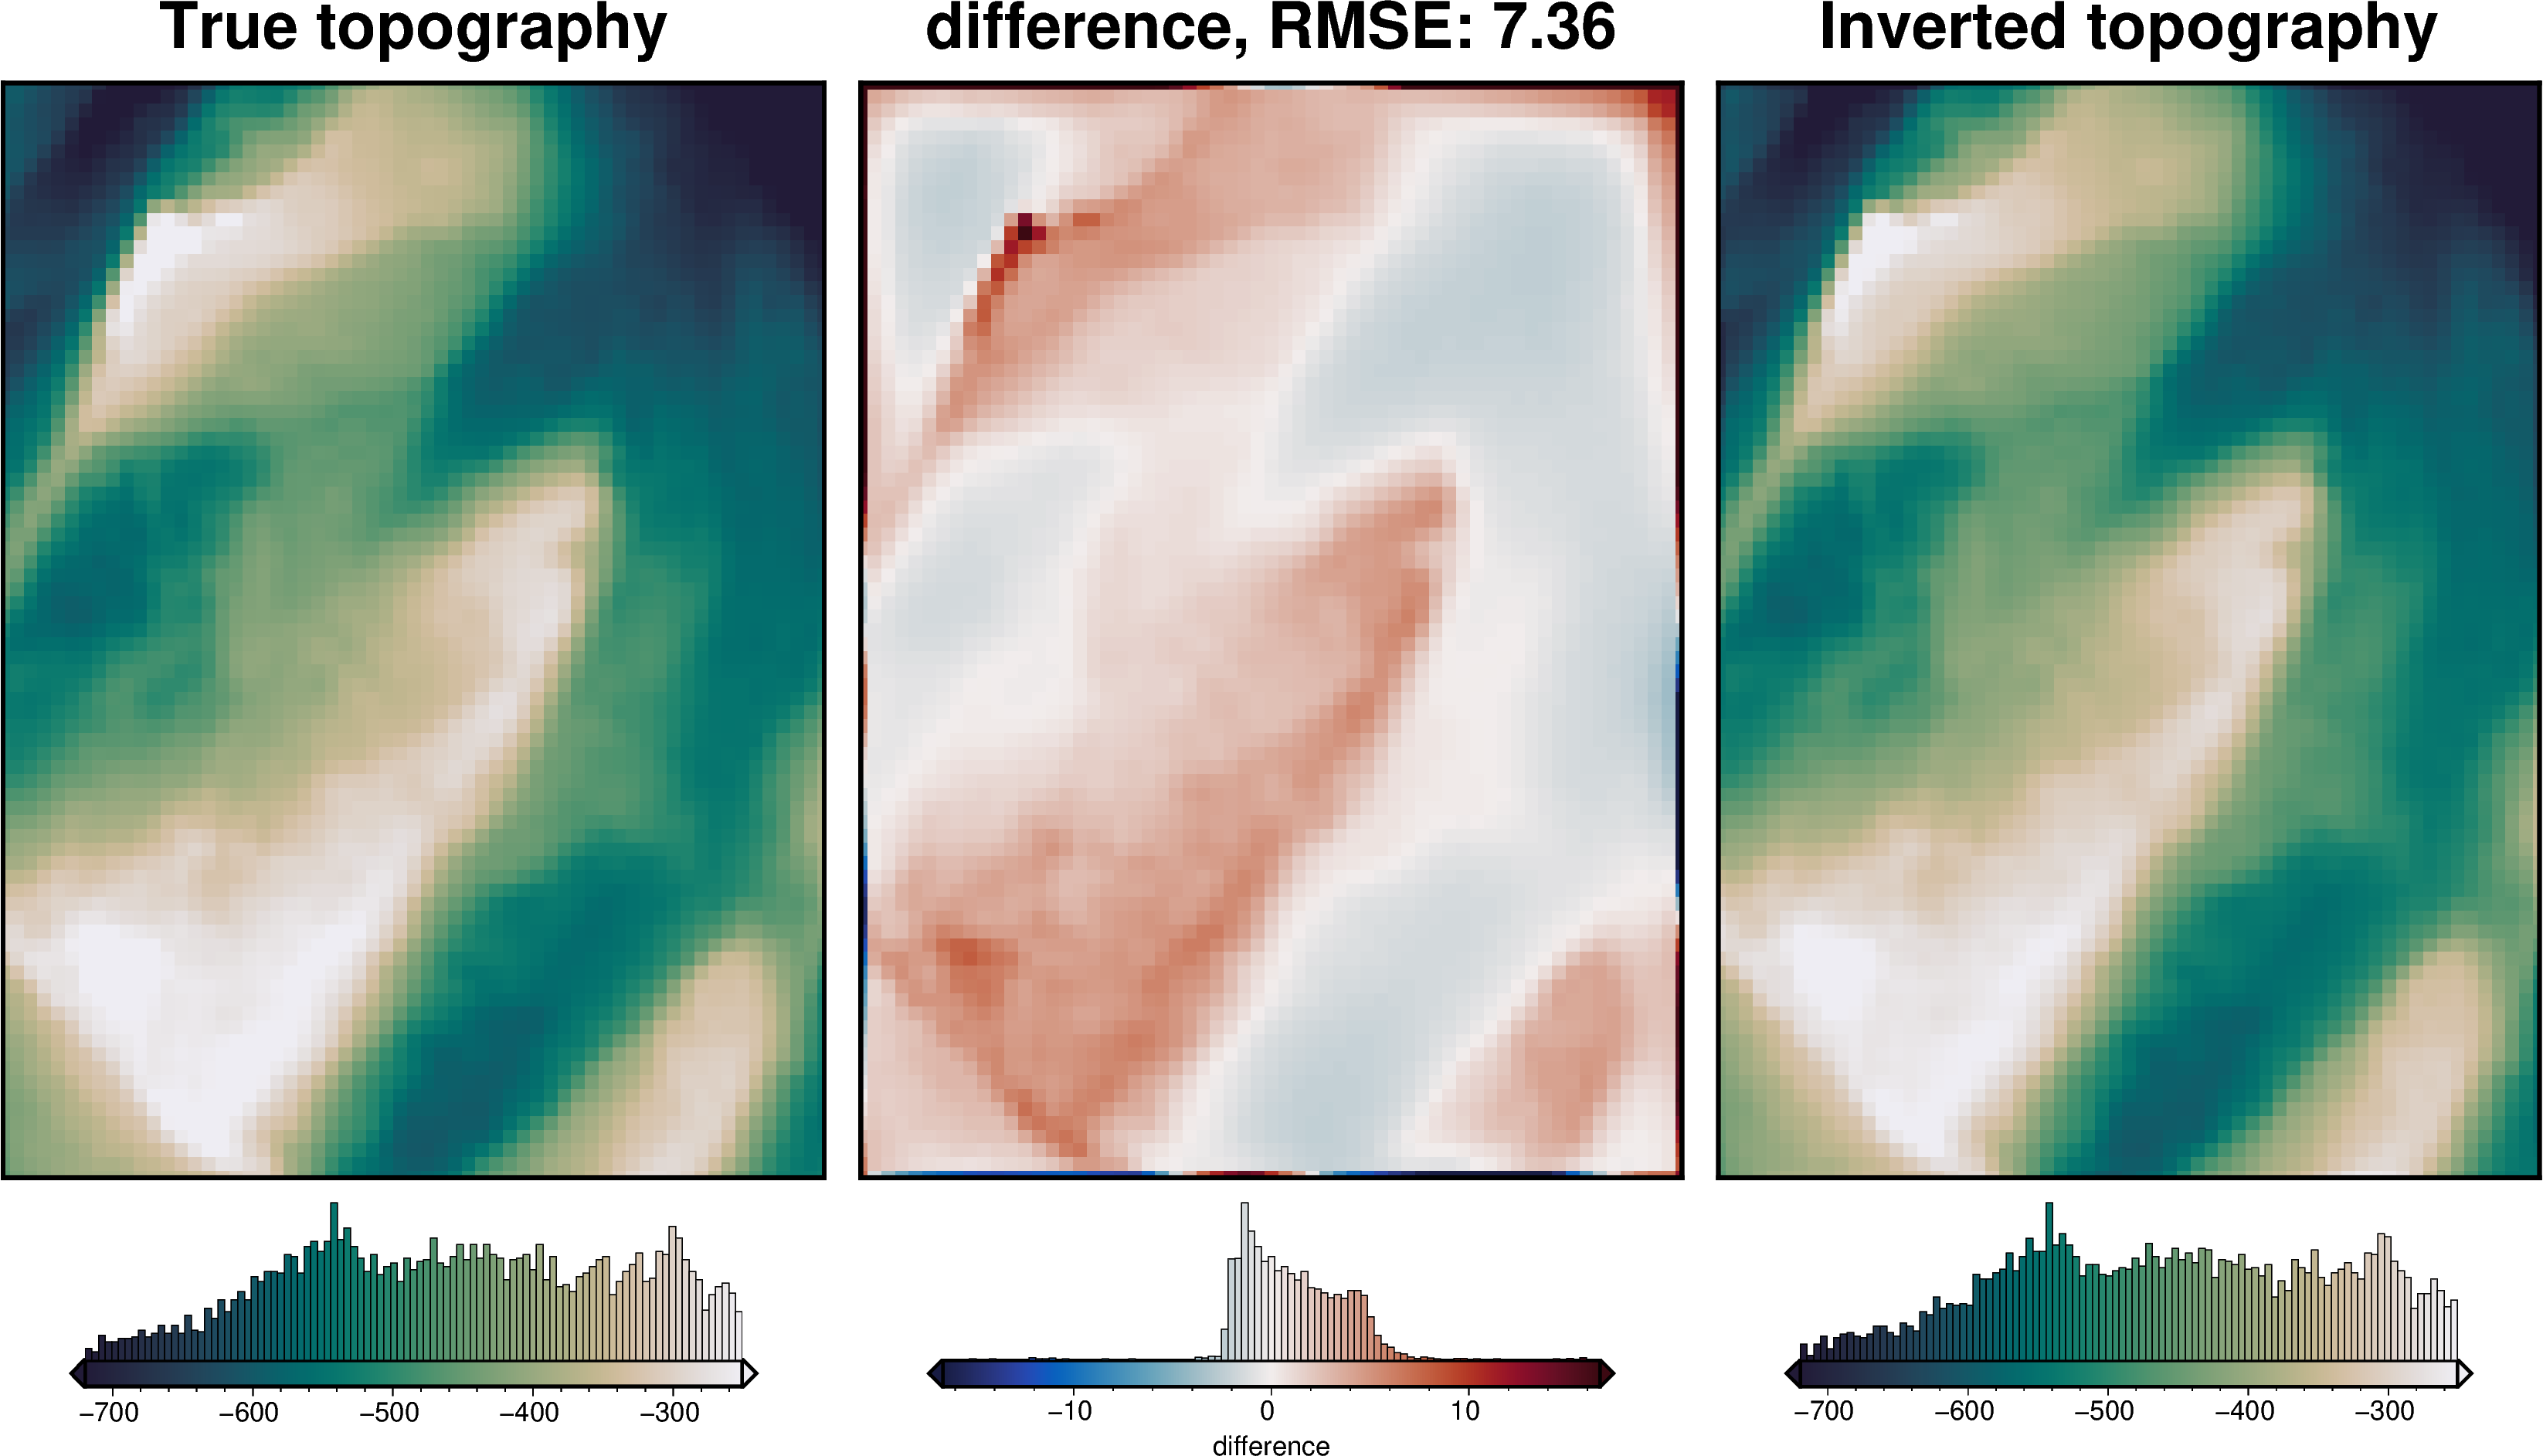

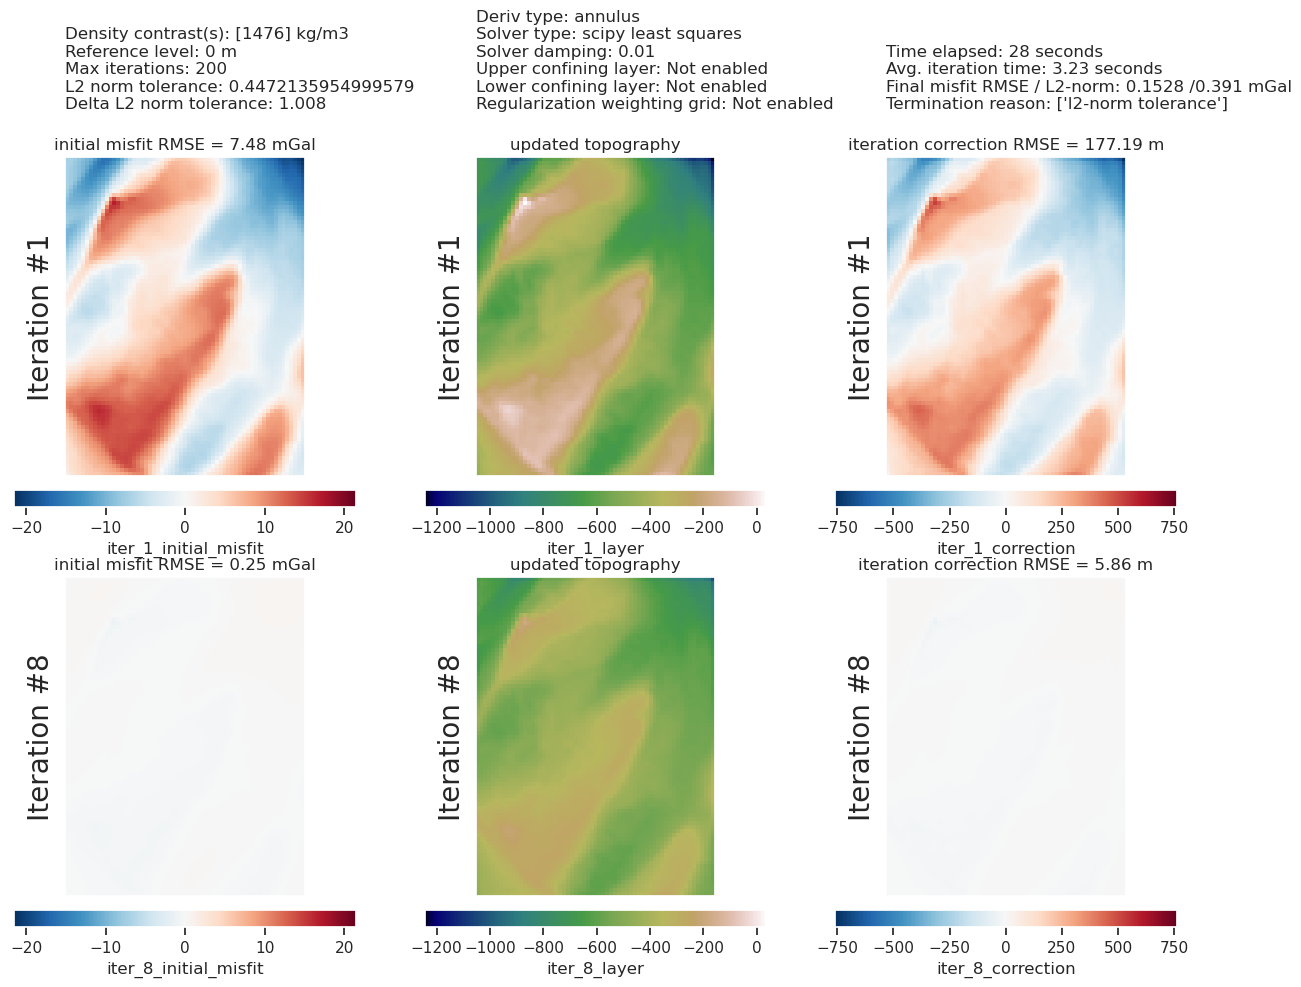

In [73]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    # plot_iter_results=False,
    plot_topo_results=False,
    # plot_grav_results=False,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
)

# Damping Cross Validation

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_01_damping_cv'
INFO:invert4geom:running damping cross validation


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.05043628221313192}
INFO:invert4geom:	scores: [0.1298634035252866]
INFO:invert4geom:results saved to ../../results/Ross_Sea_01_damping_cv_results.pickle.pickle


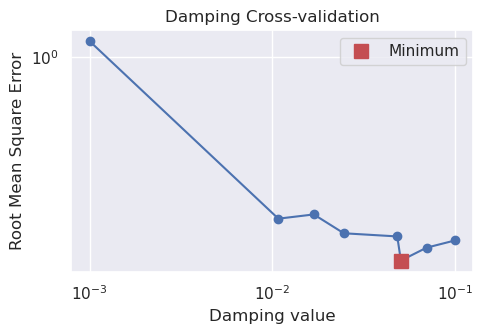

In [74]:
logging.getLogger().setLevel(logging.INFO)

# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_prisms=starting_prisms,
    # for creating test/train splits
    grav_spacing=spacing,
    inversion_region=inversion_region,
    run_damping_cv=True,
    damping_limits=(0.001, 0.1),
    damping_cv_trials=8,
    plot_cv=True,
    fname="../../results/Ross_Sea_01_damping_cv",
    # plot_dynamic_convergence=True,
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [11]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_01_damping_cv_results.pickle").open("rb") as f:
    results = pickle.load(f)

# load study
with pathlib.Path("../../results/Ross_Sea_01_damping_cv_damping_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [12]:
best_damping = parameters.get("Solver damping")
best_damping

0.05043628221313192

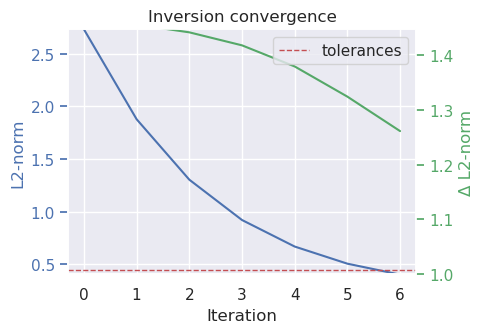

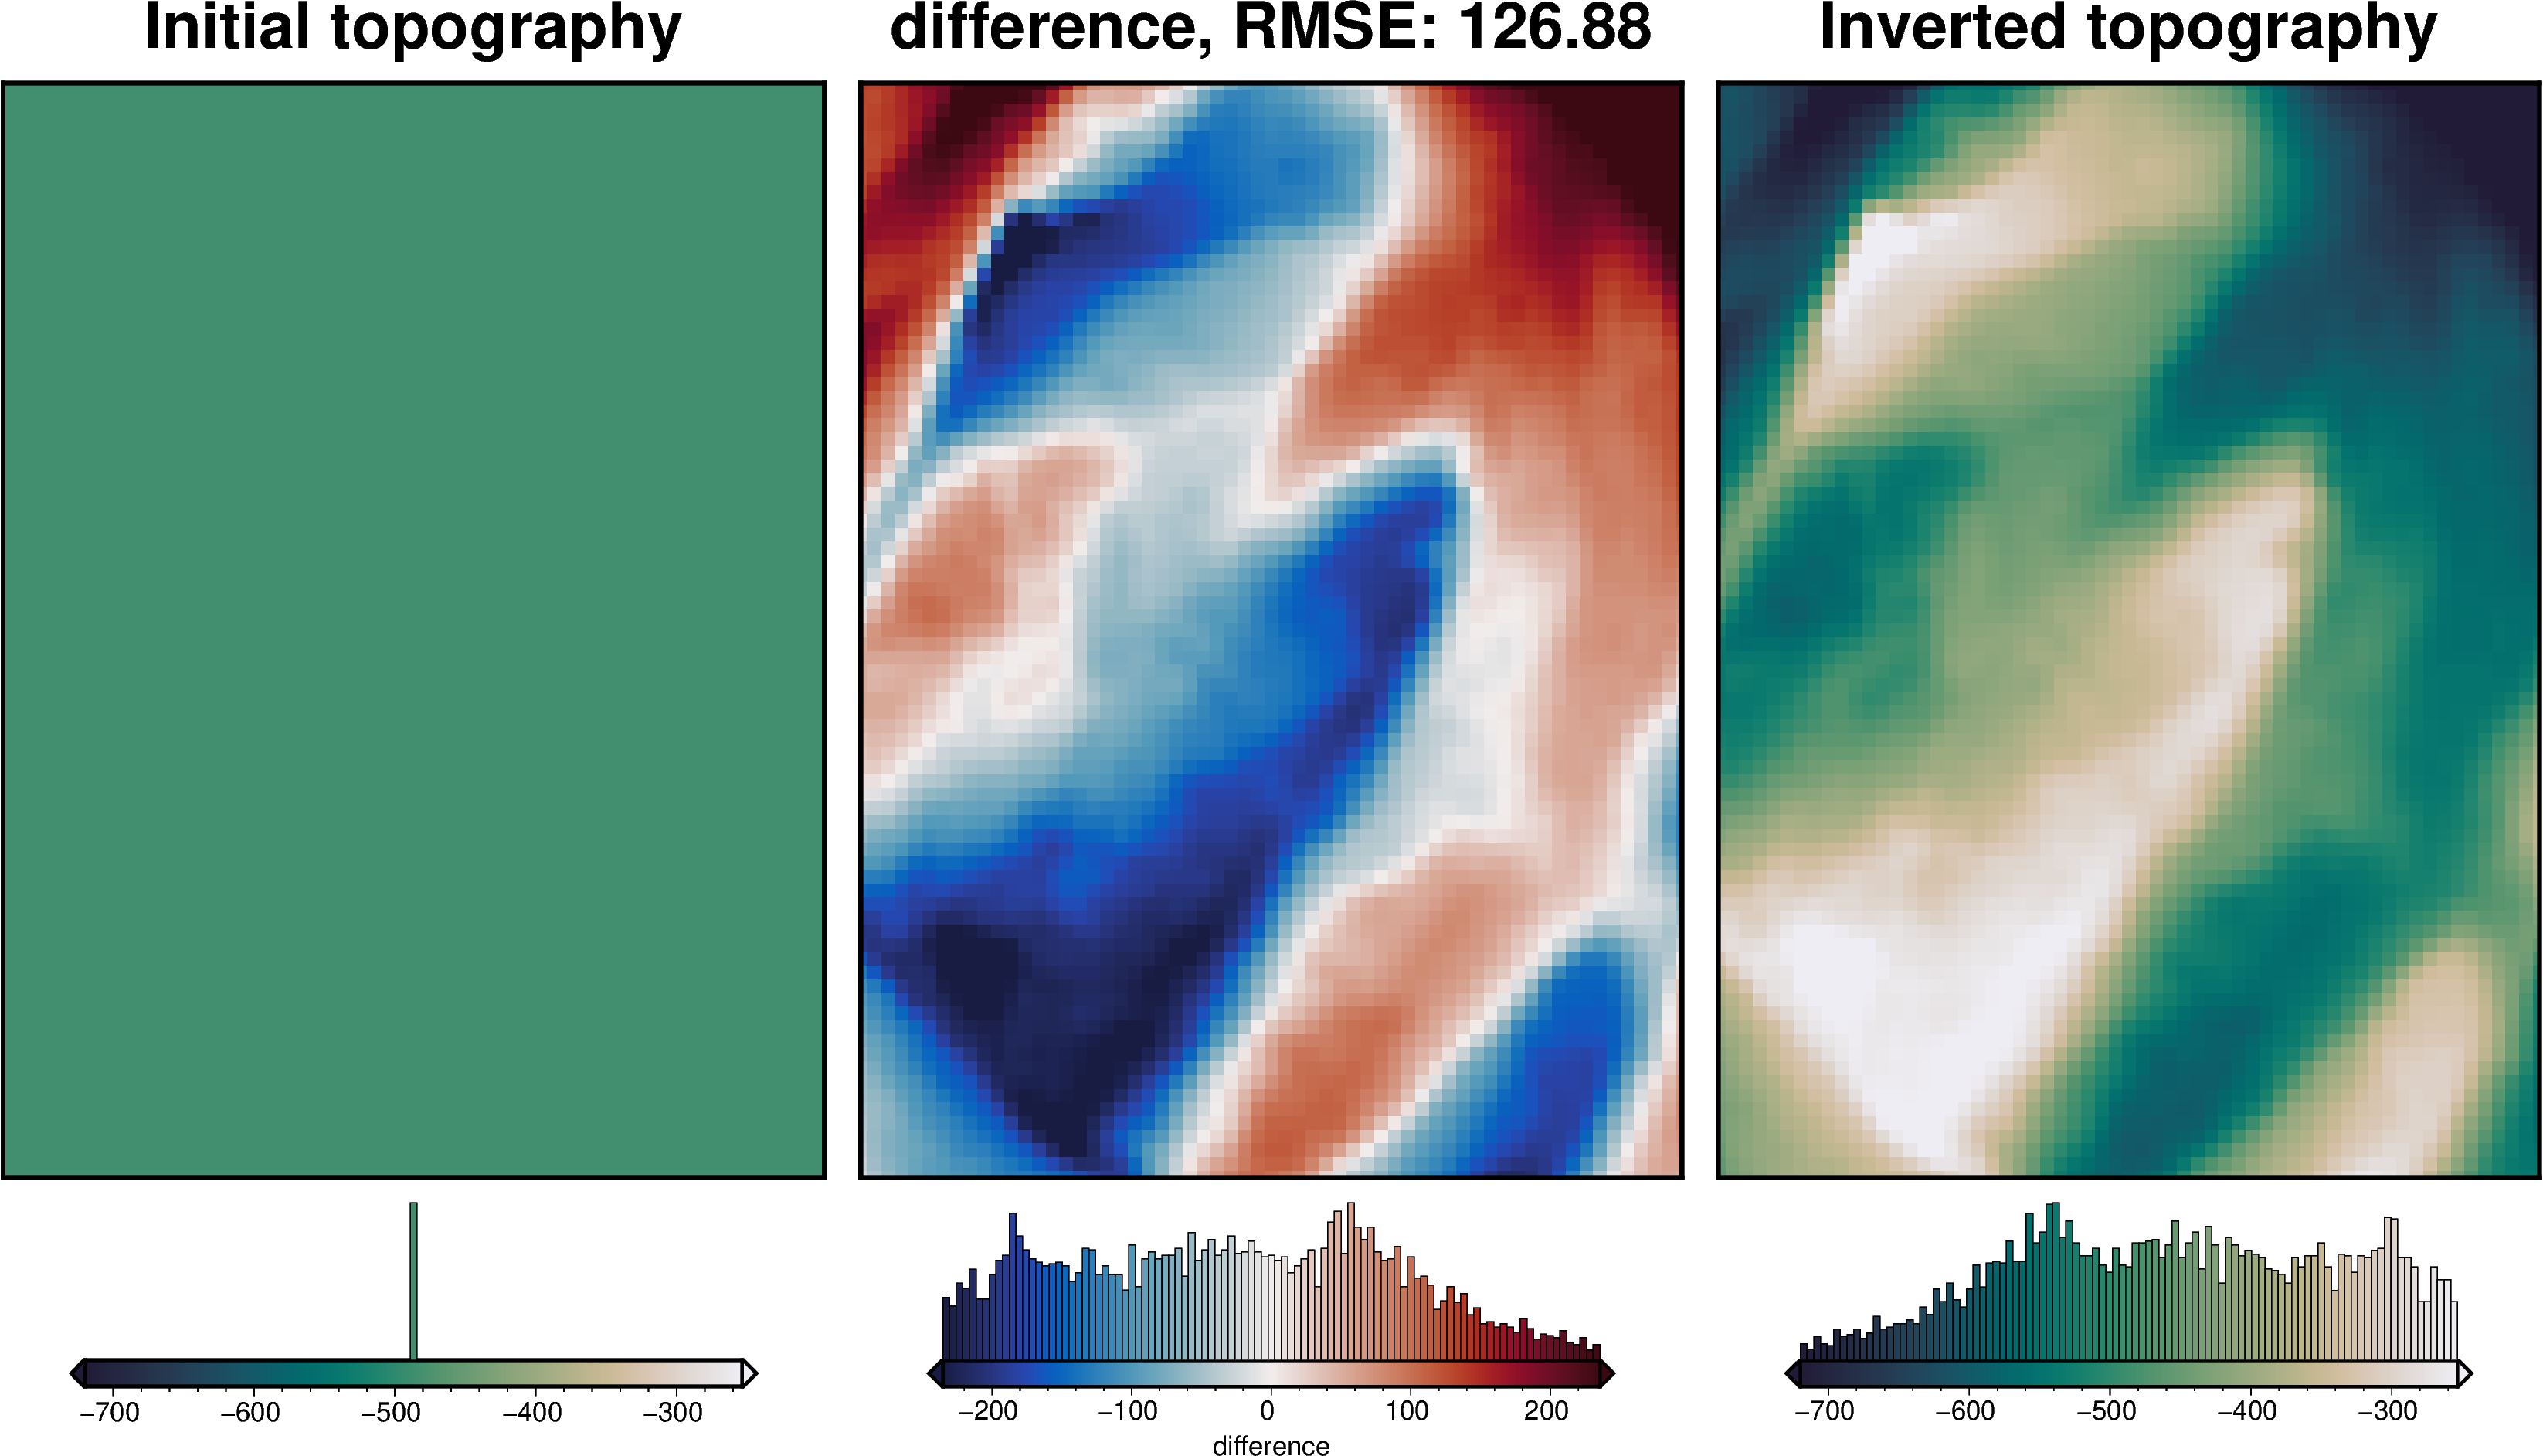

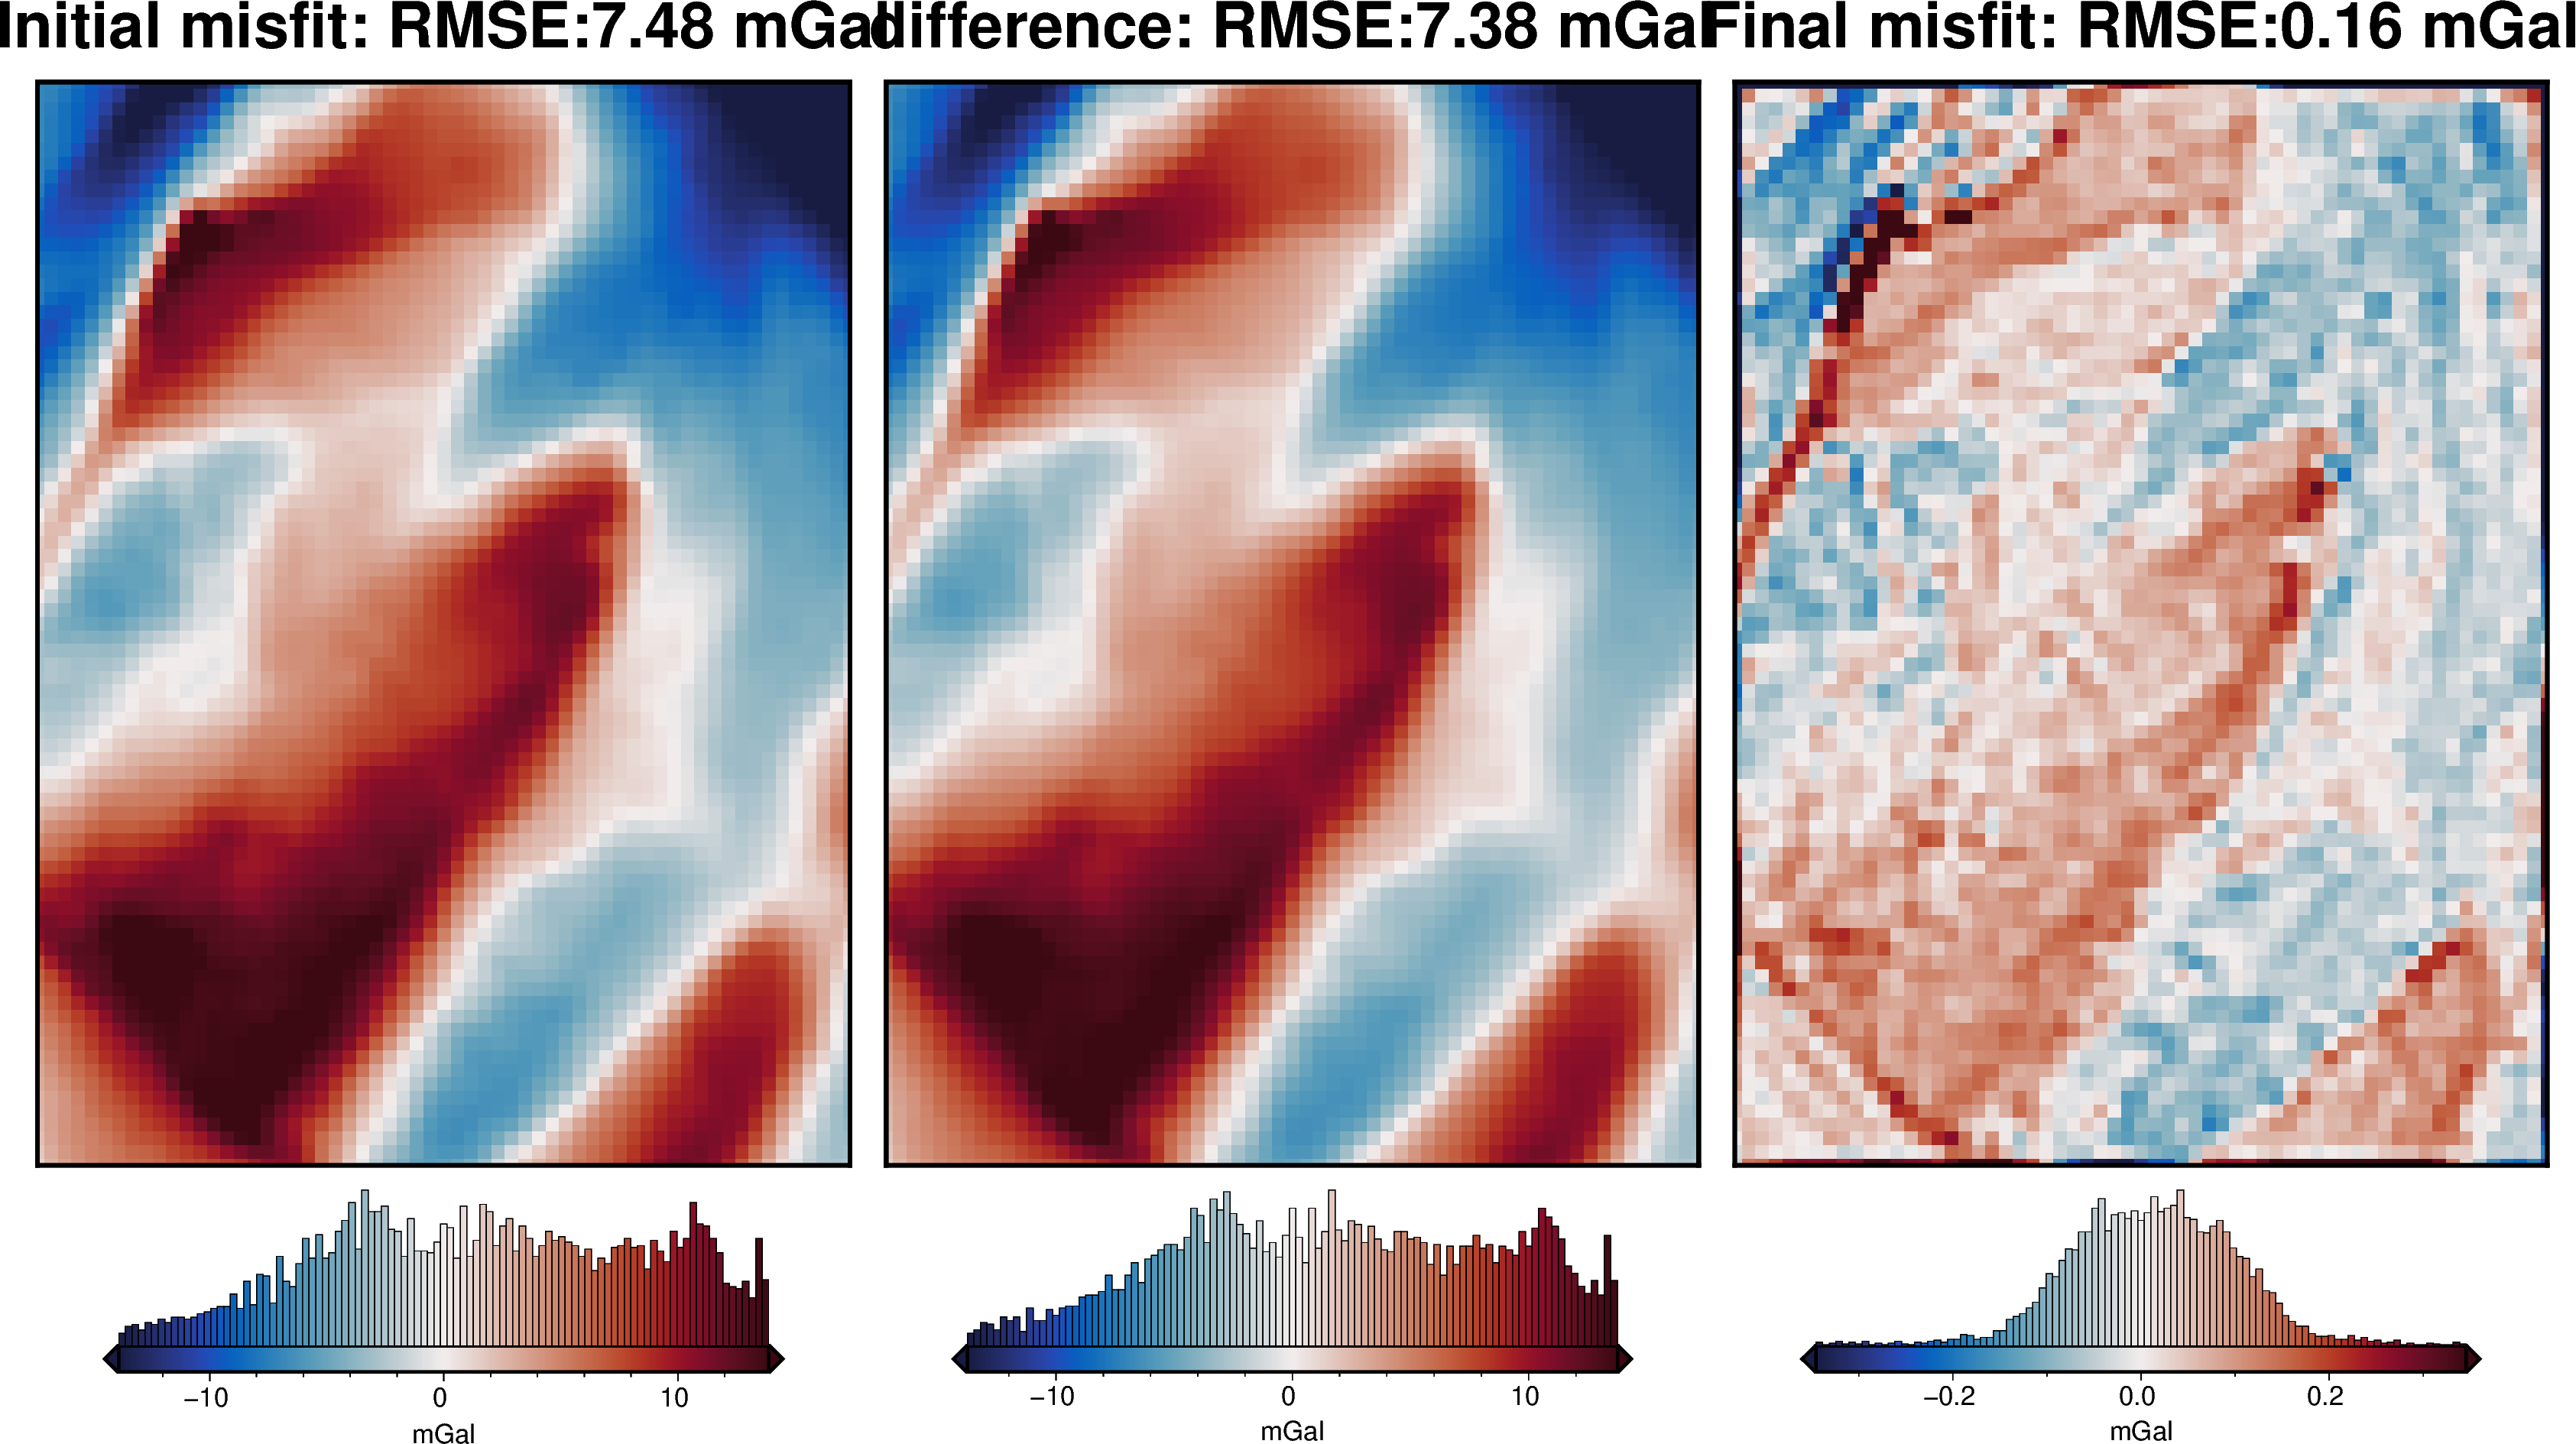

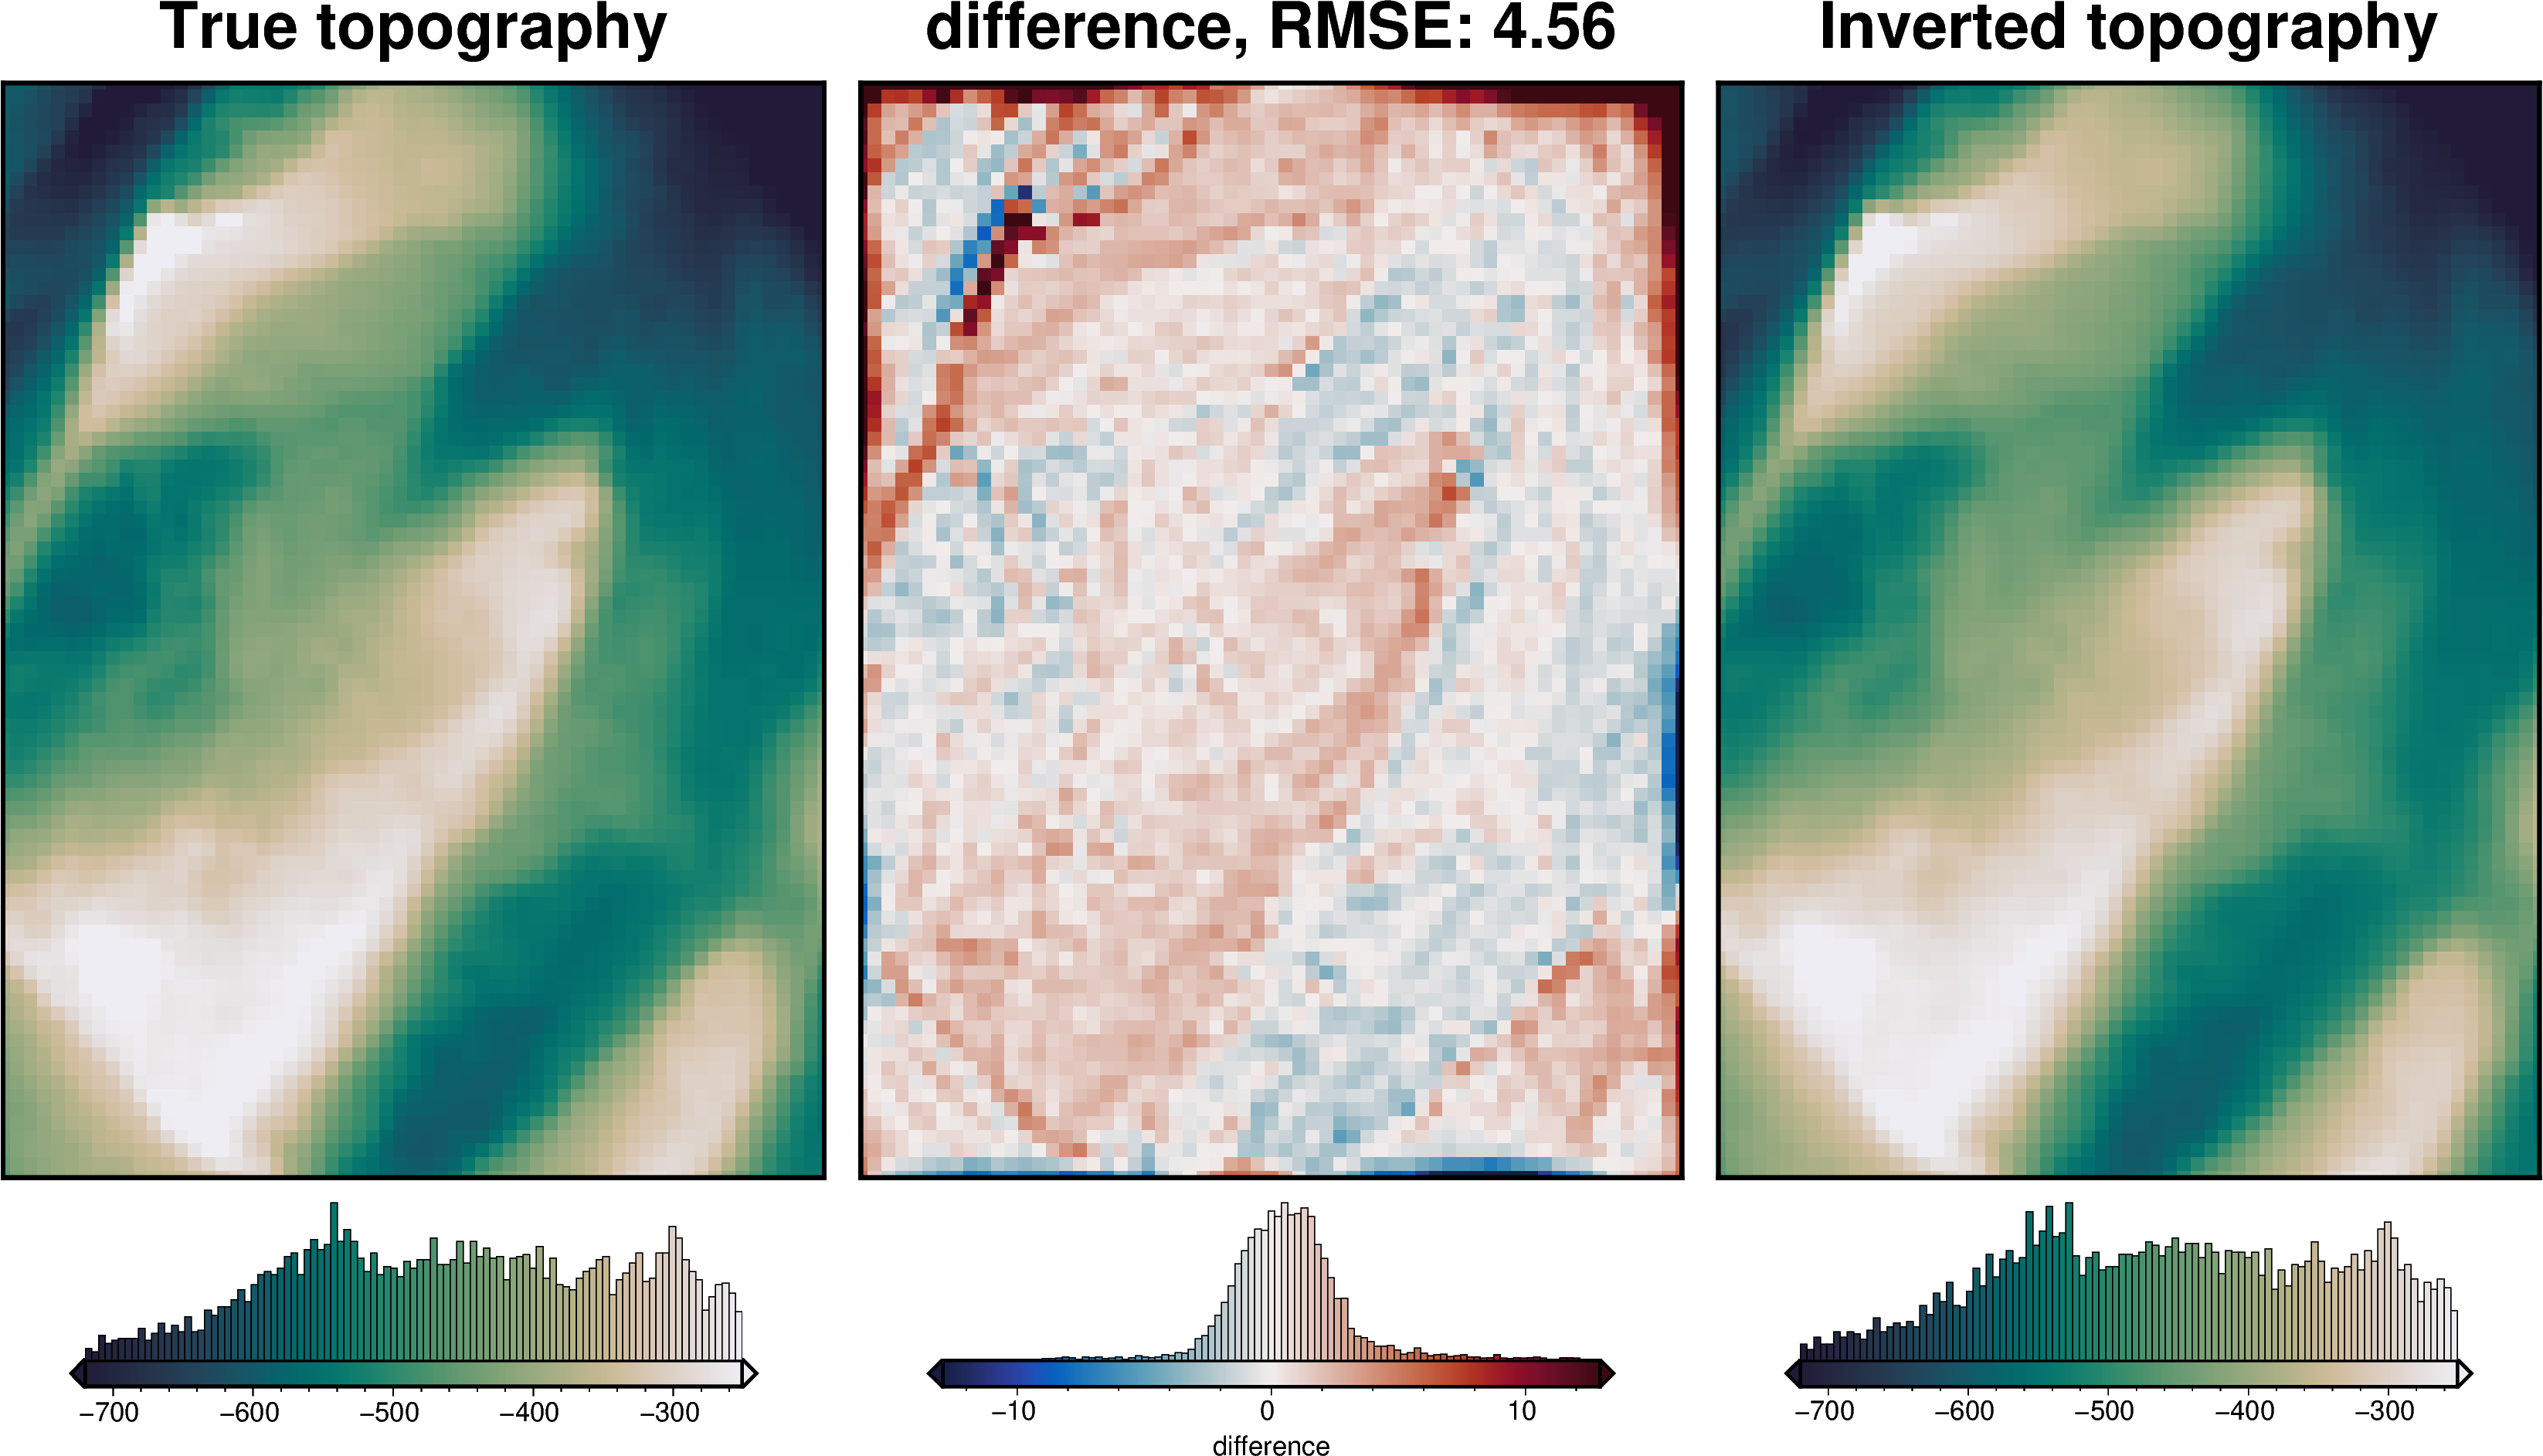

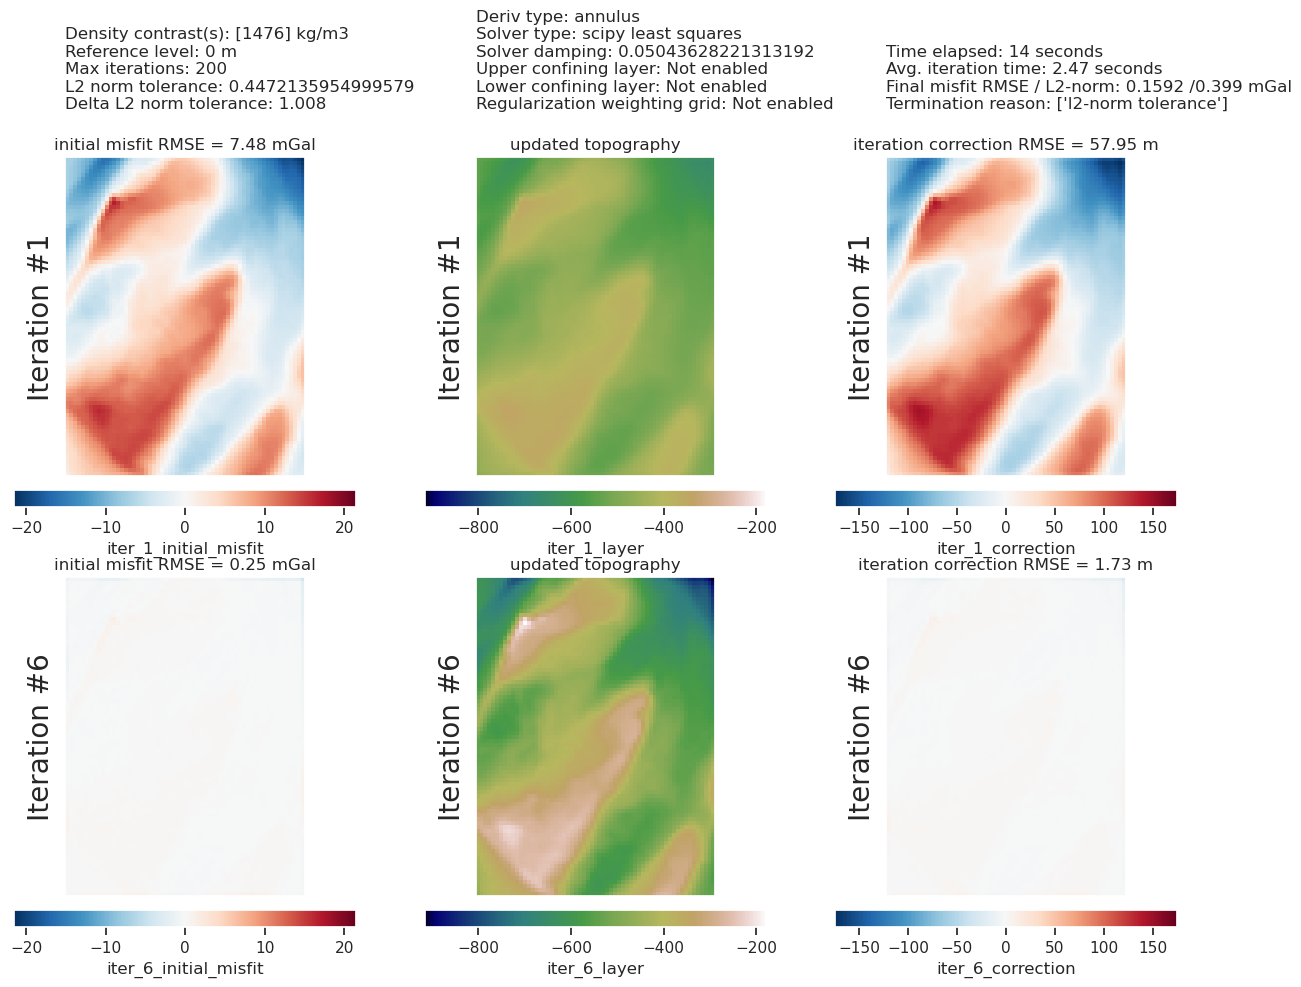

In [13]:
plotting.plot_convergence(
    grav_results,
    params=parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
)

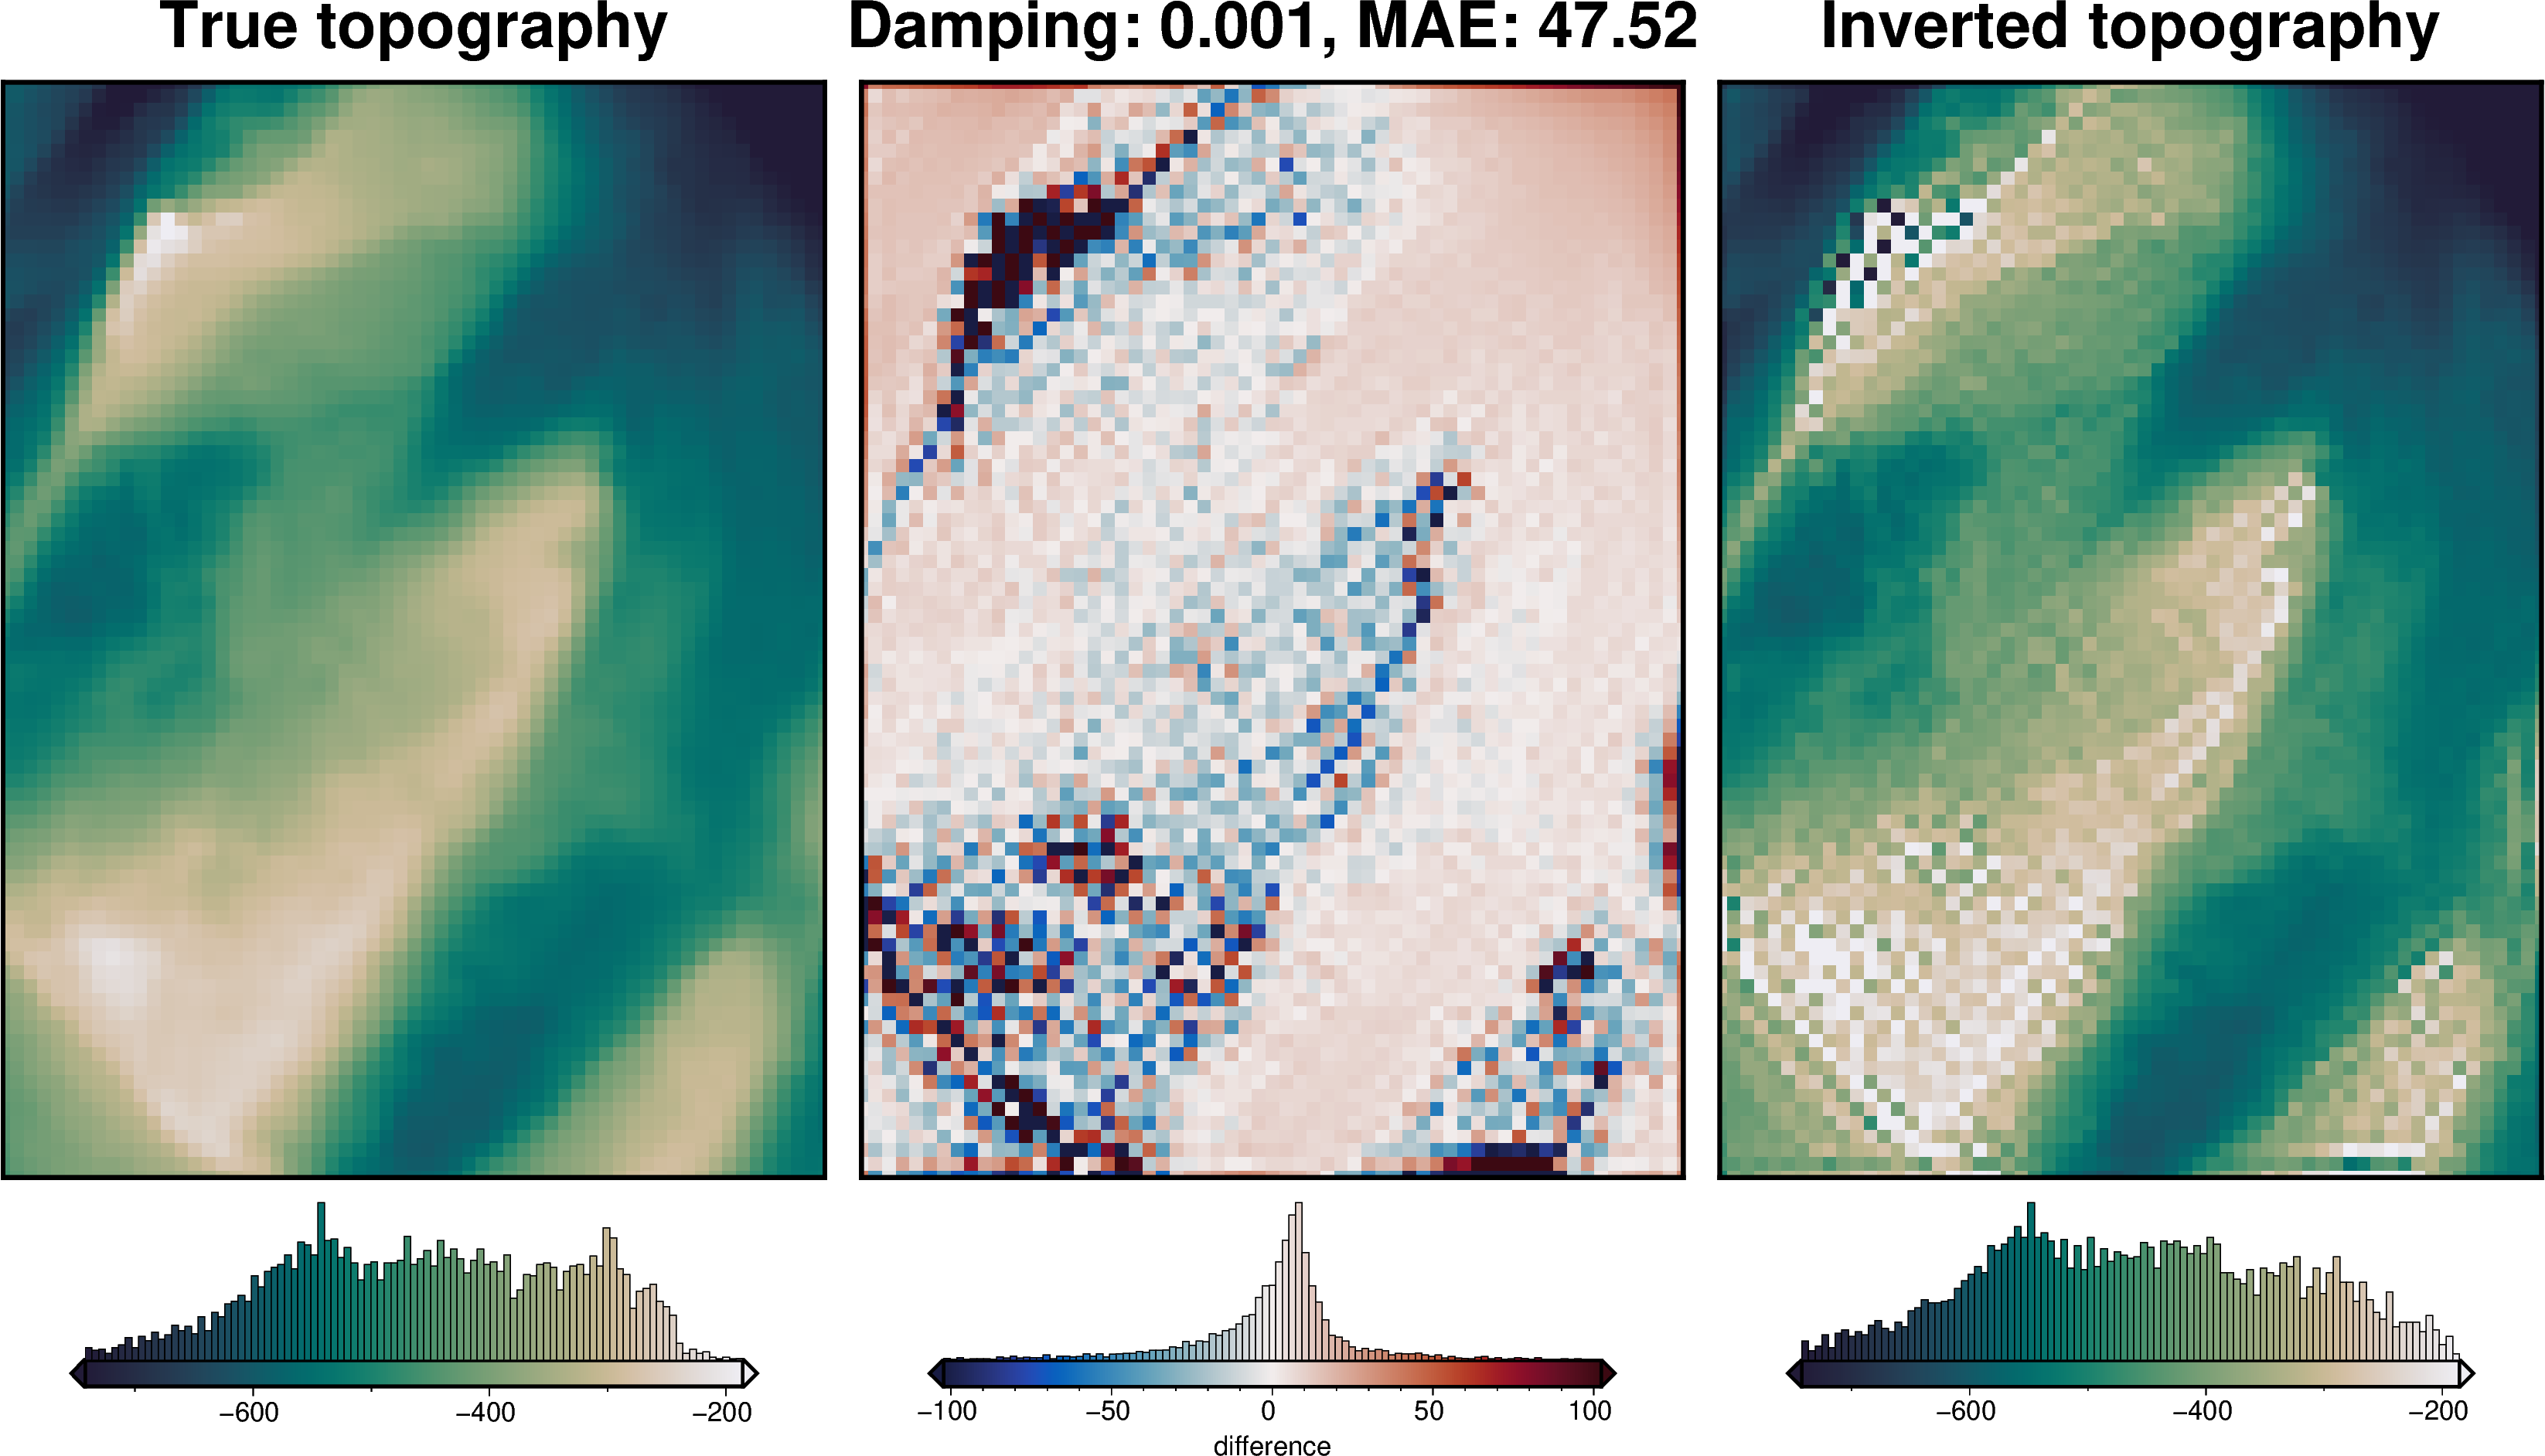

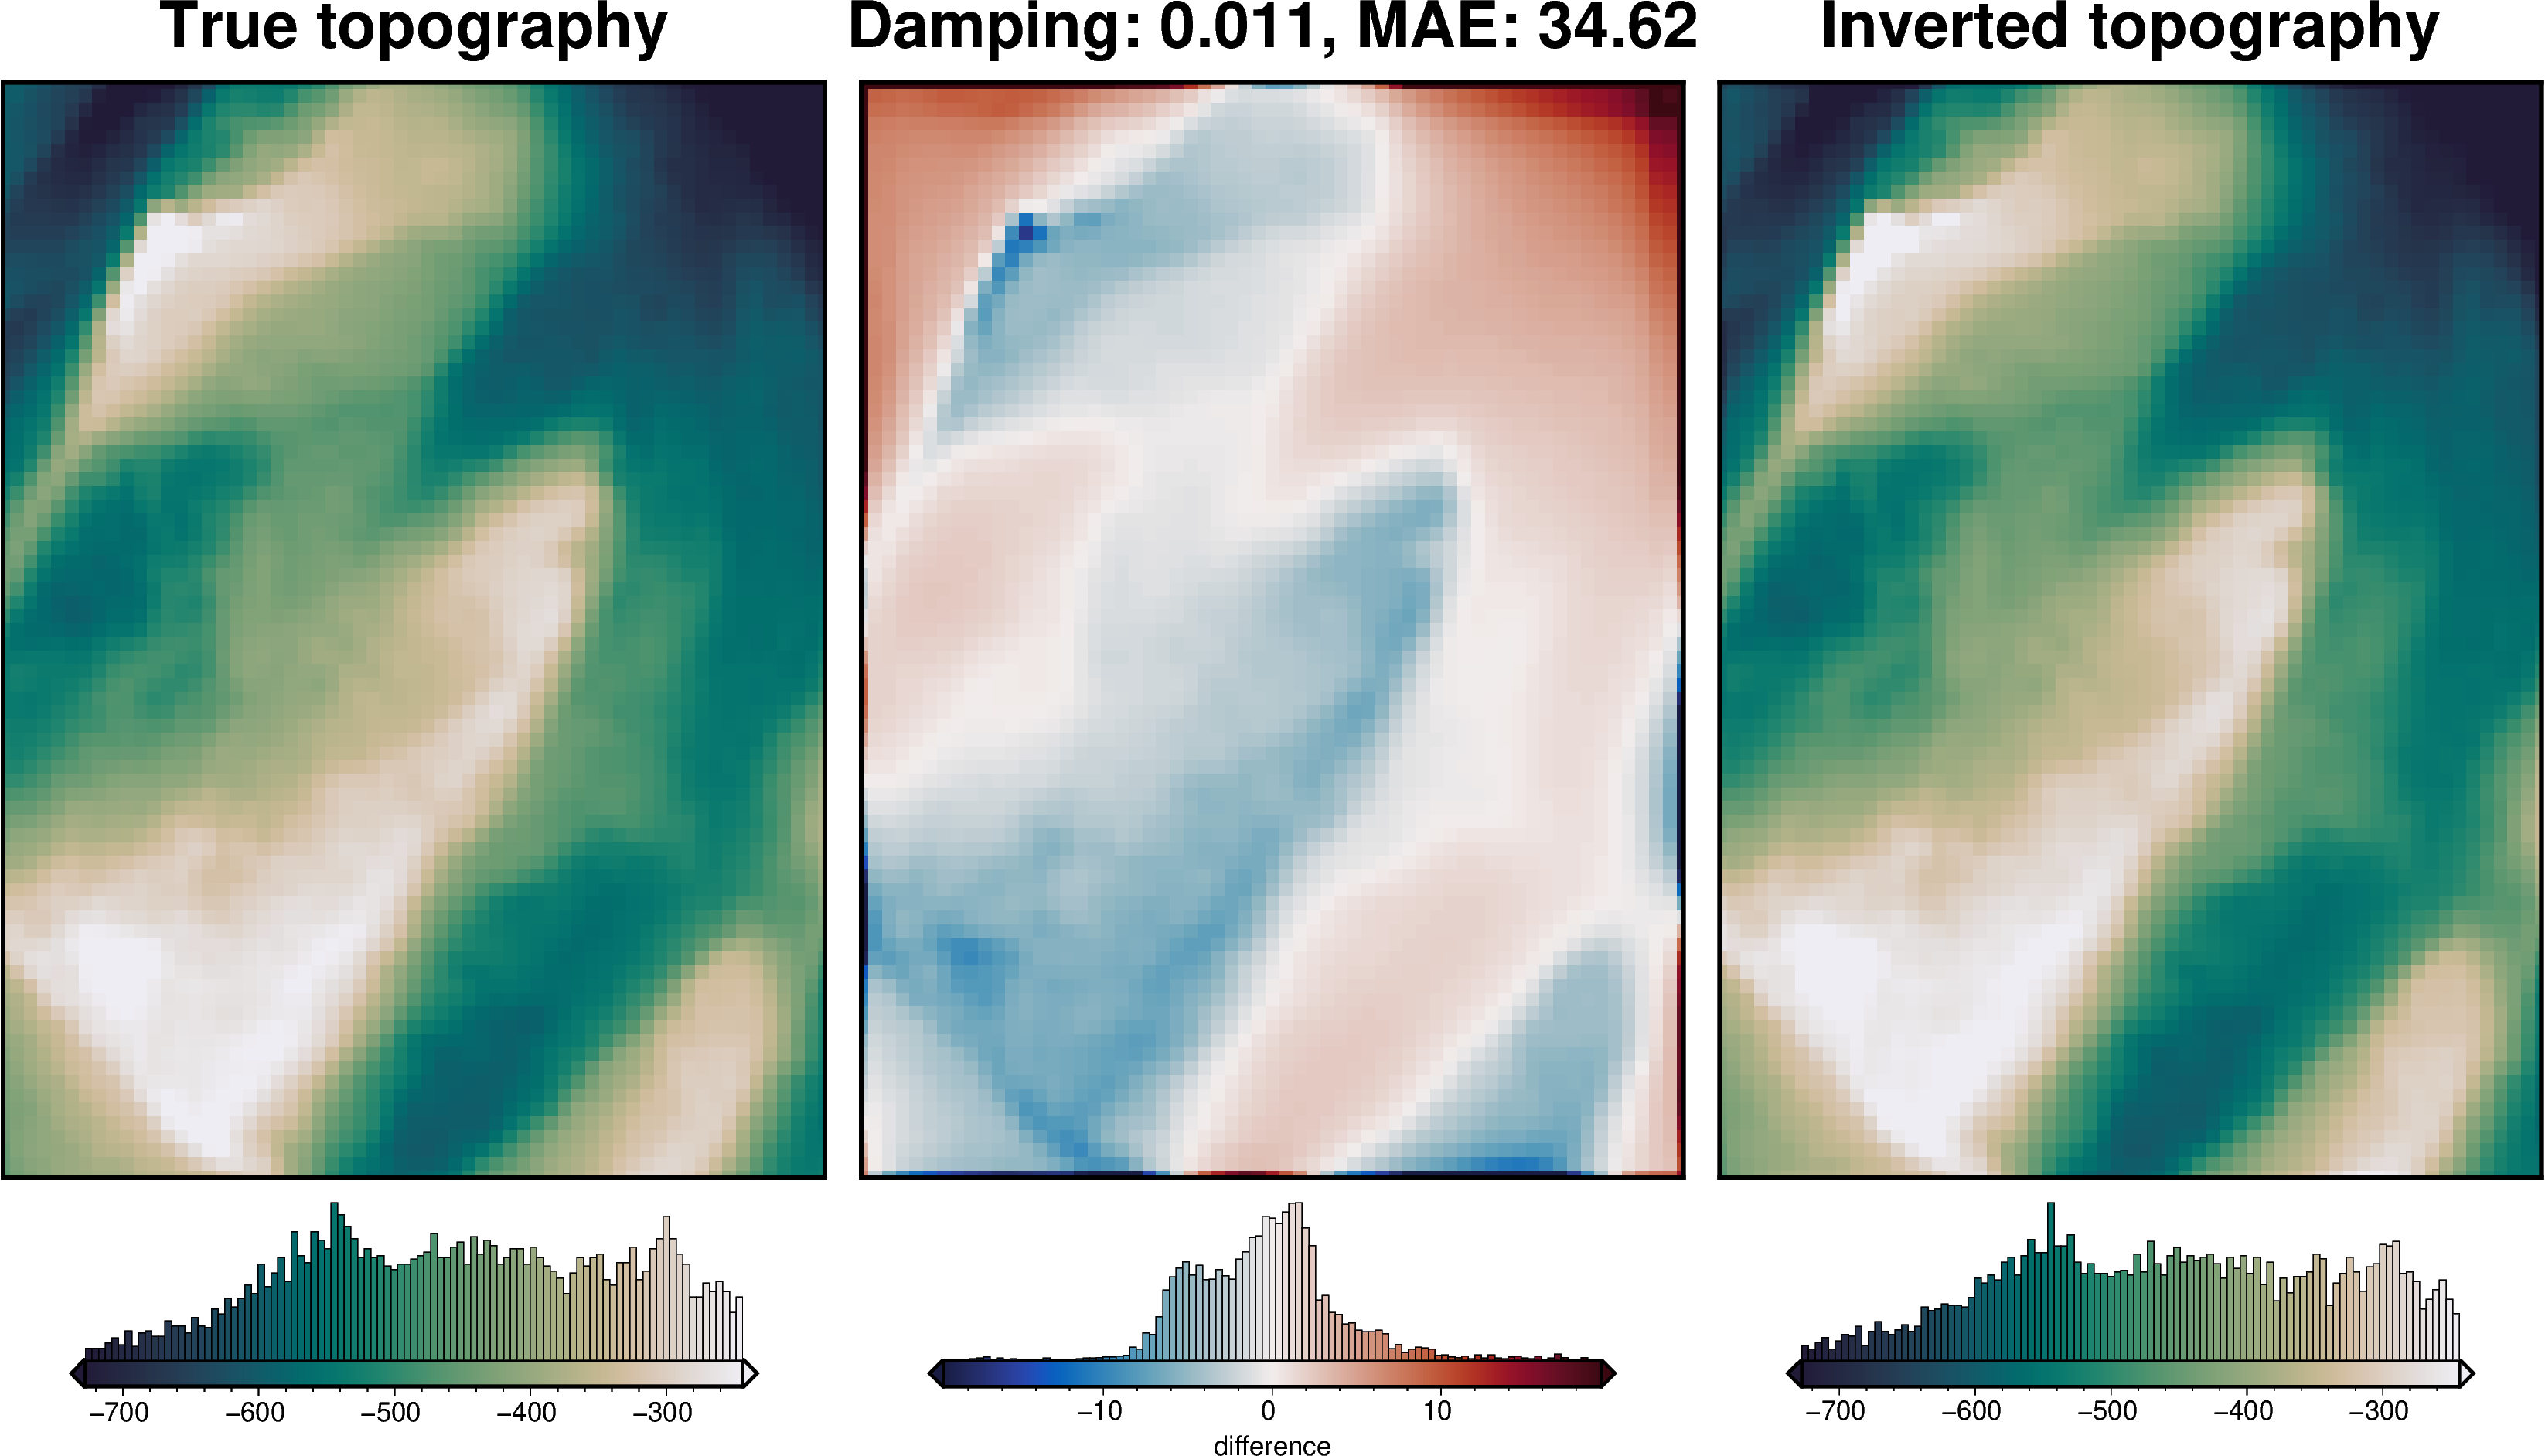

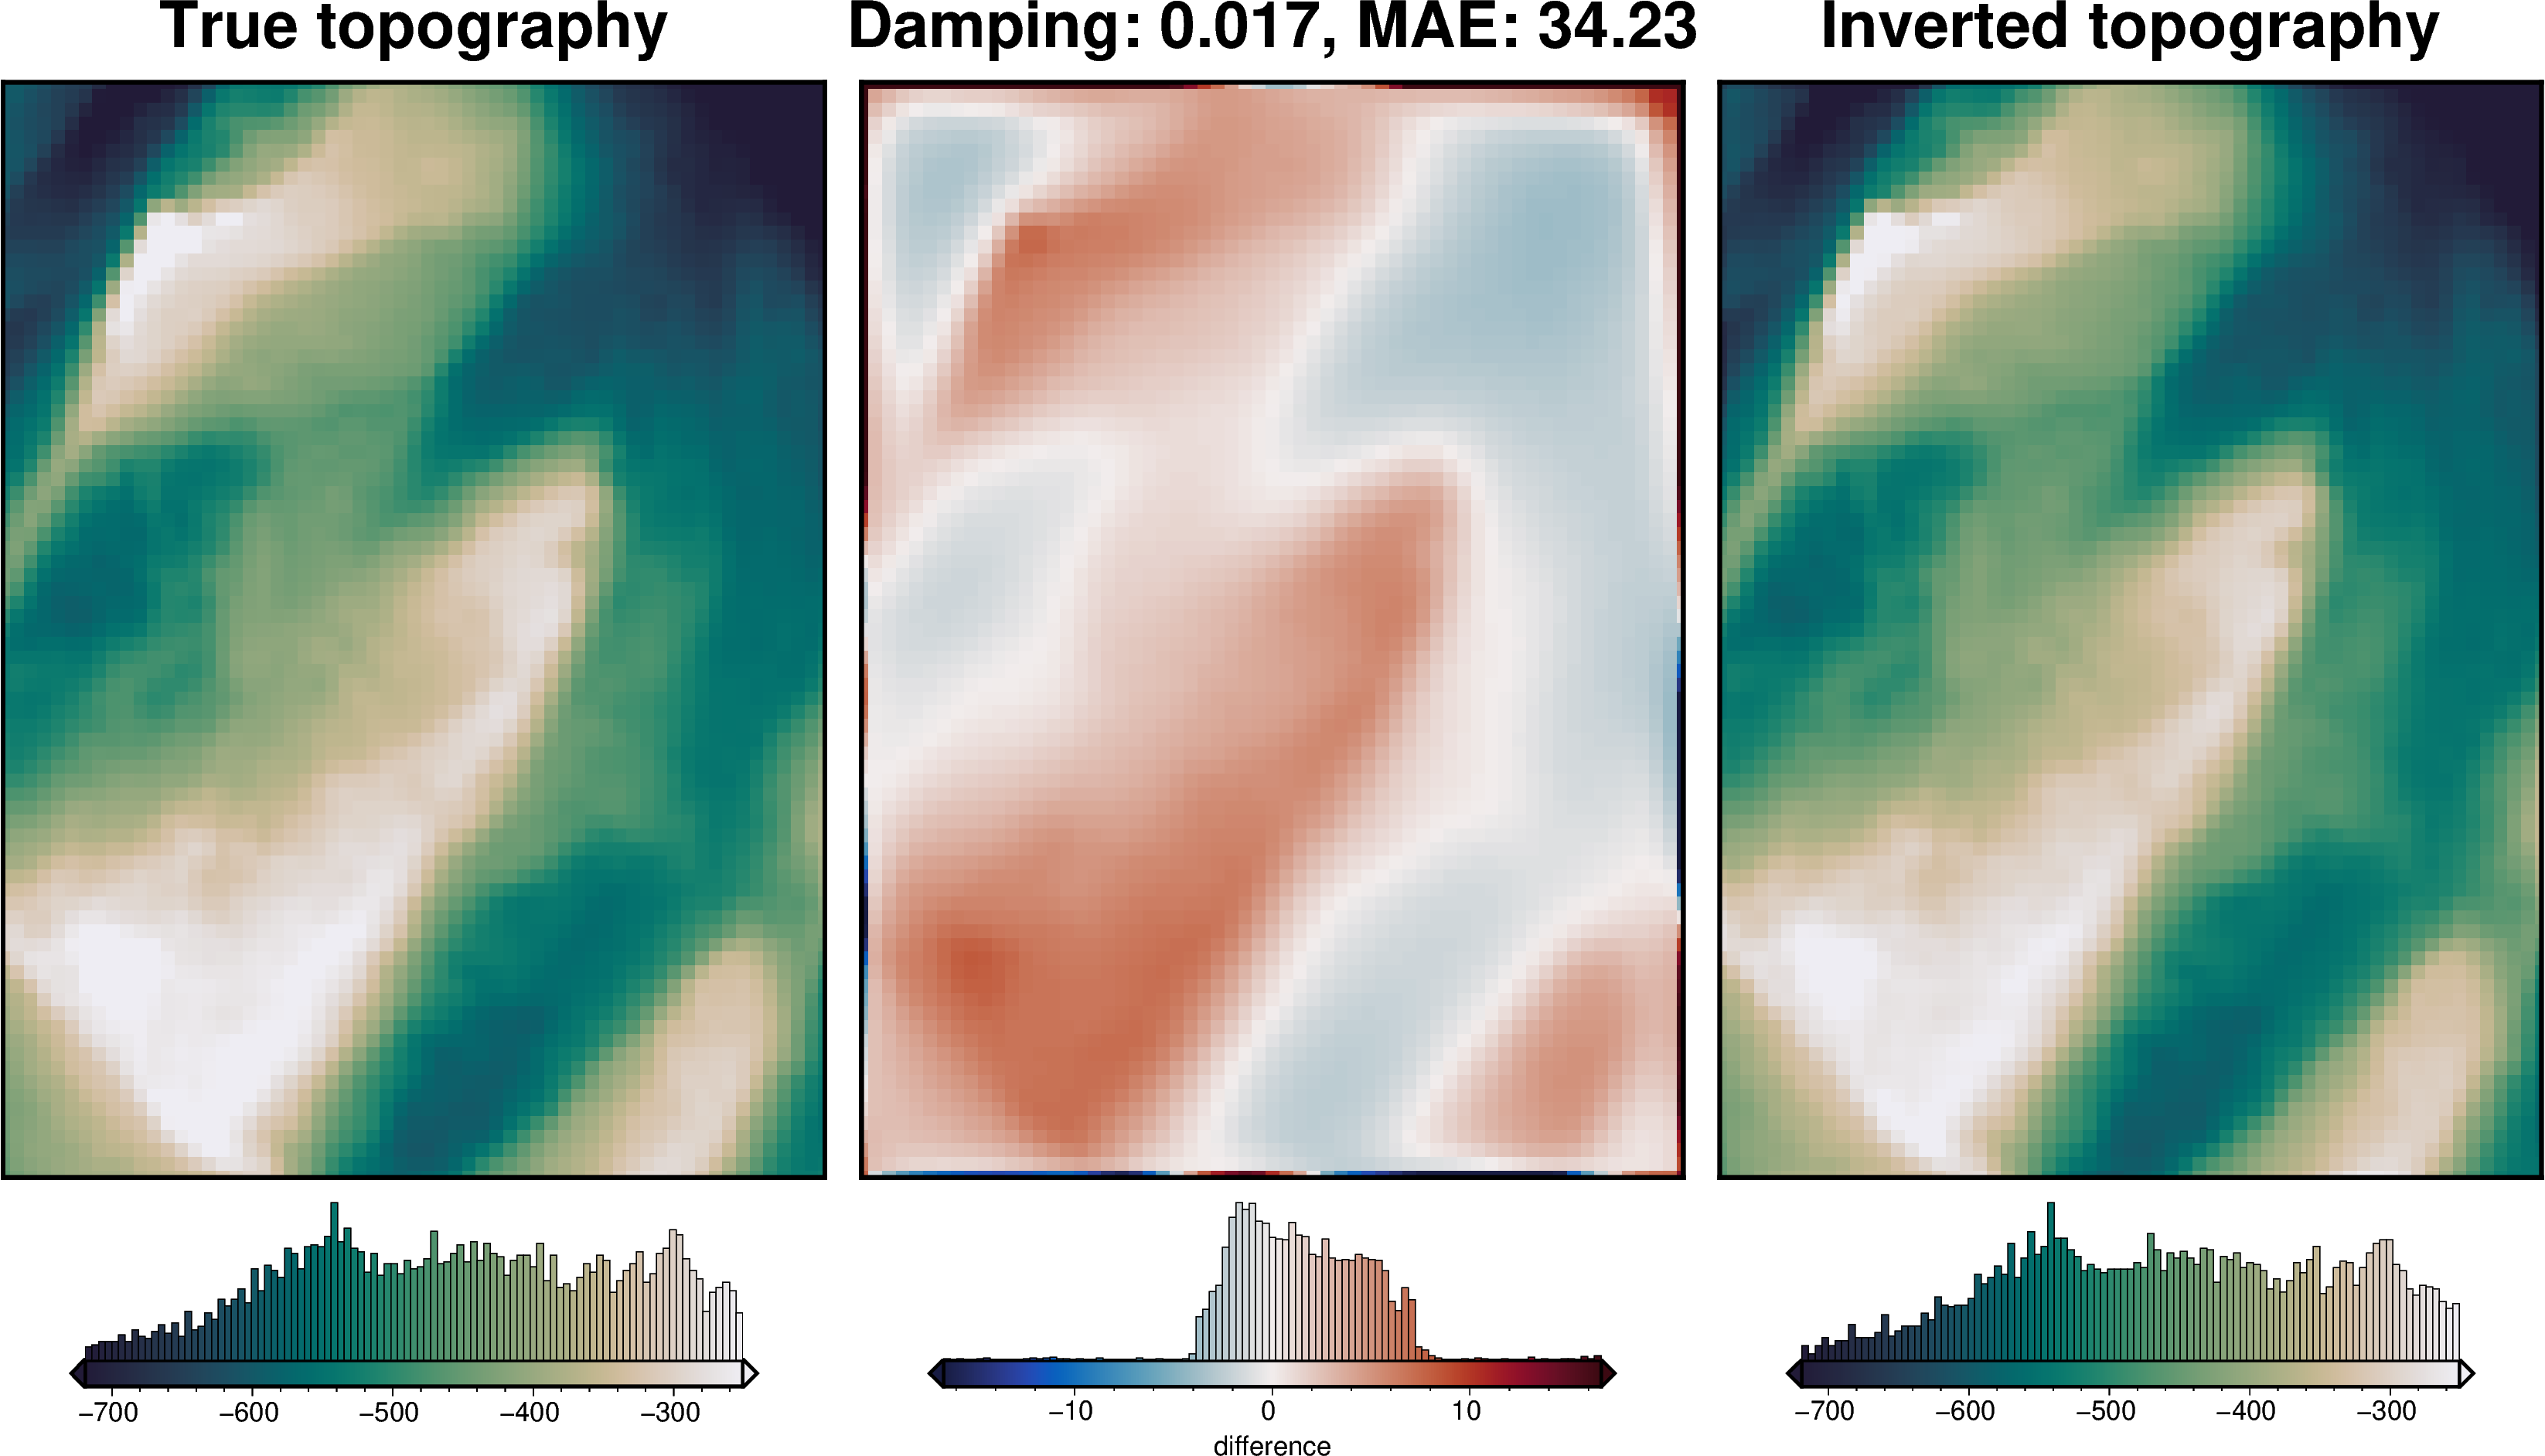

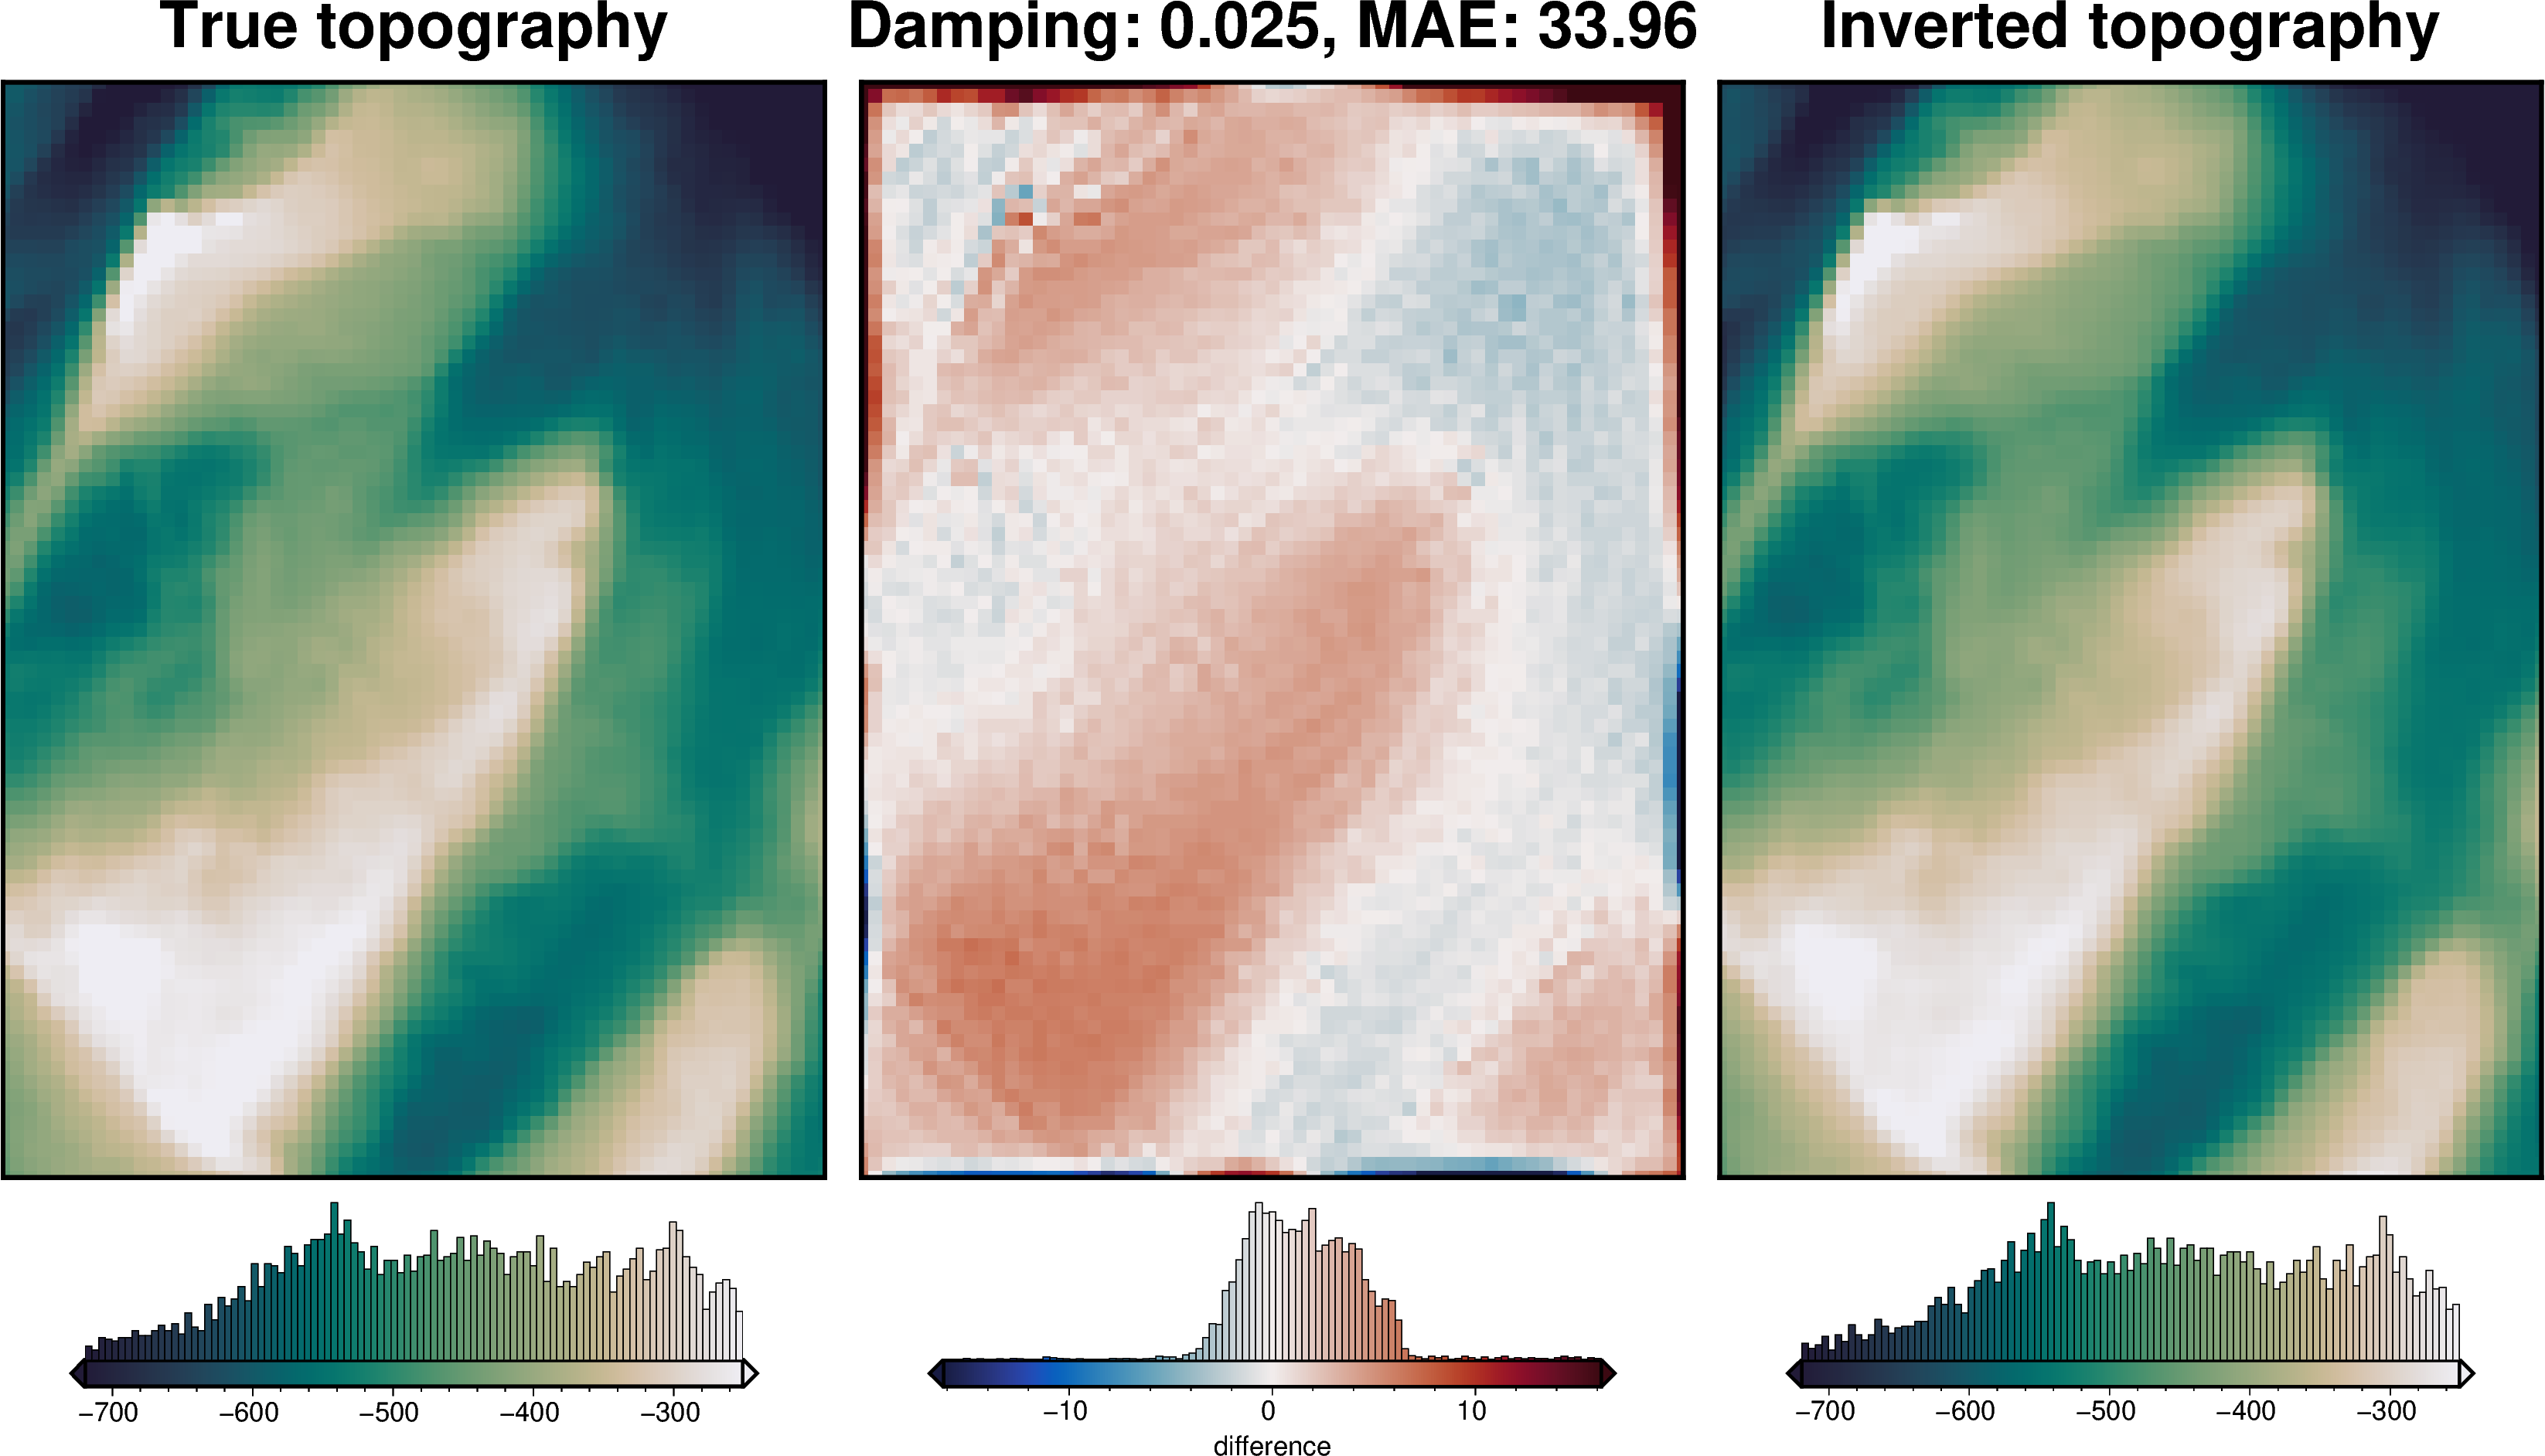

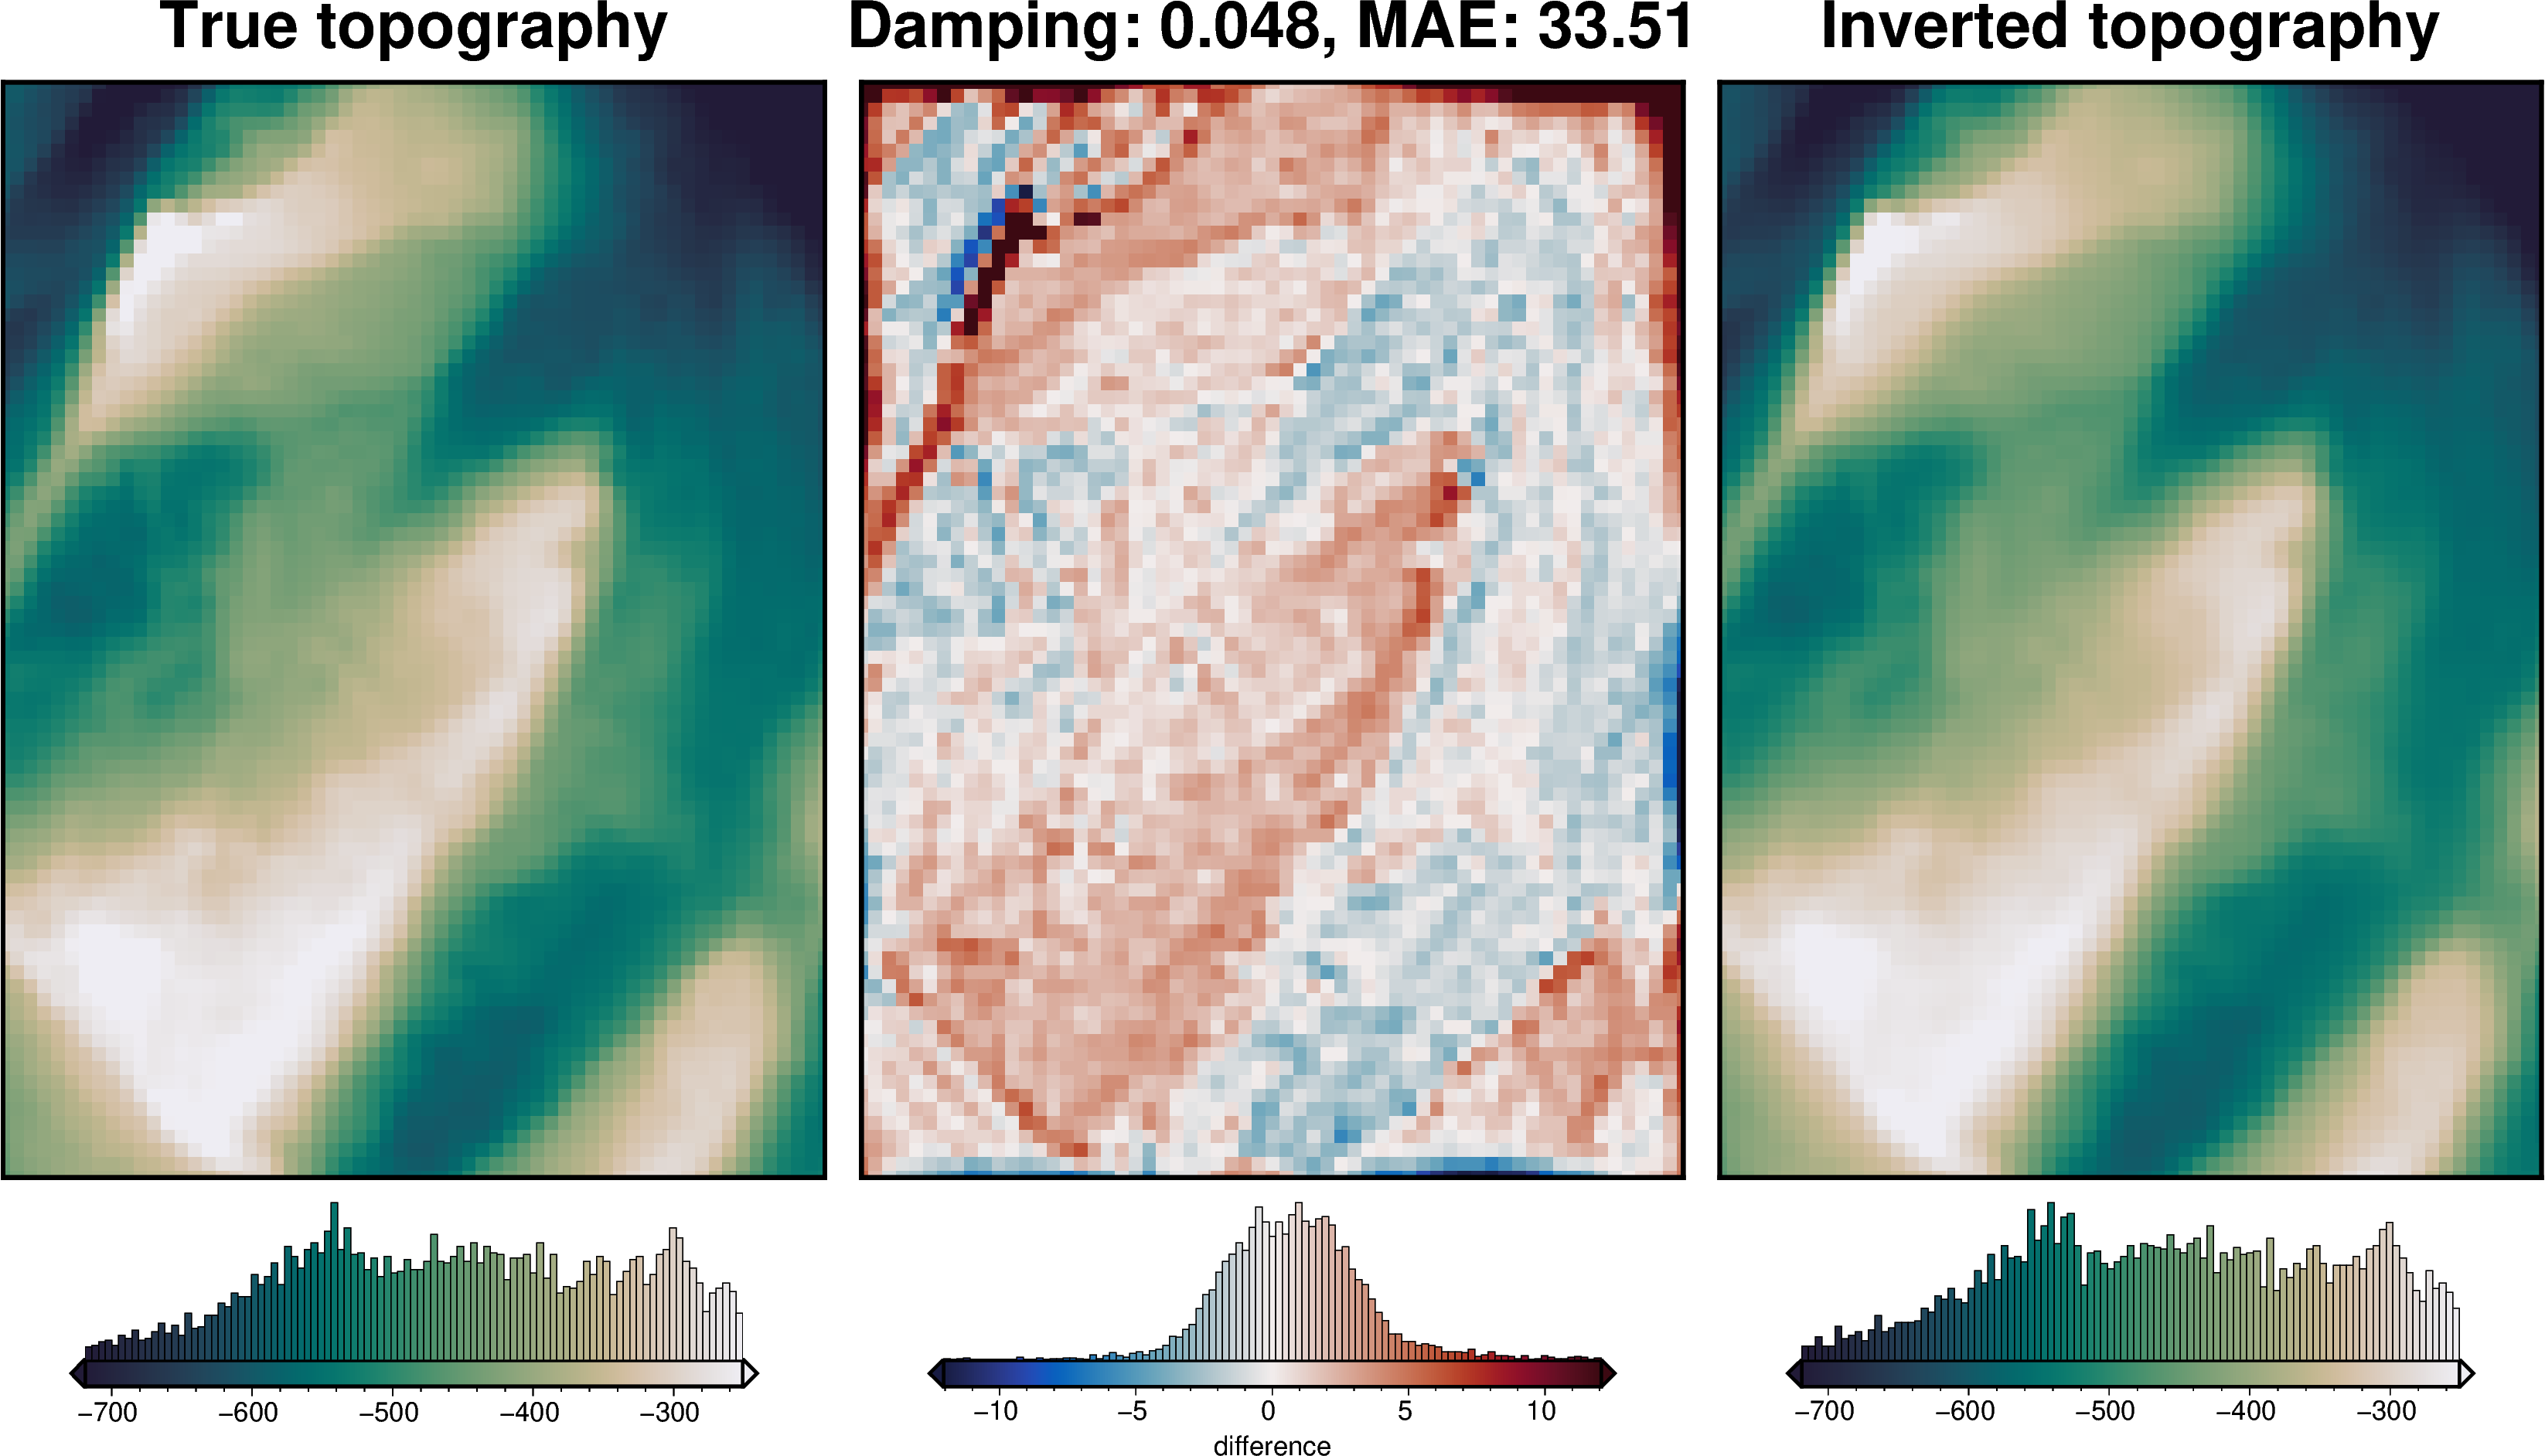

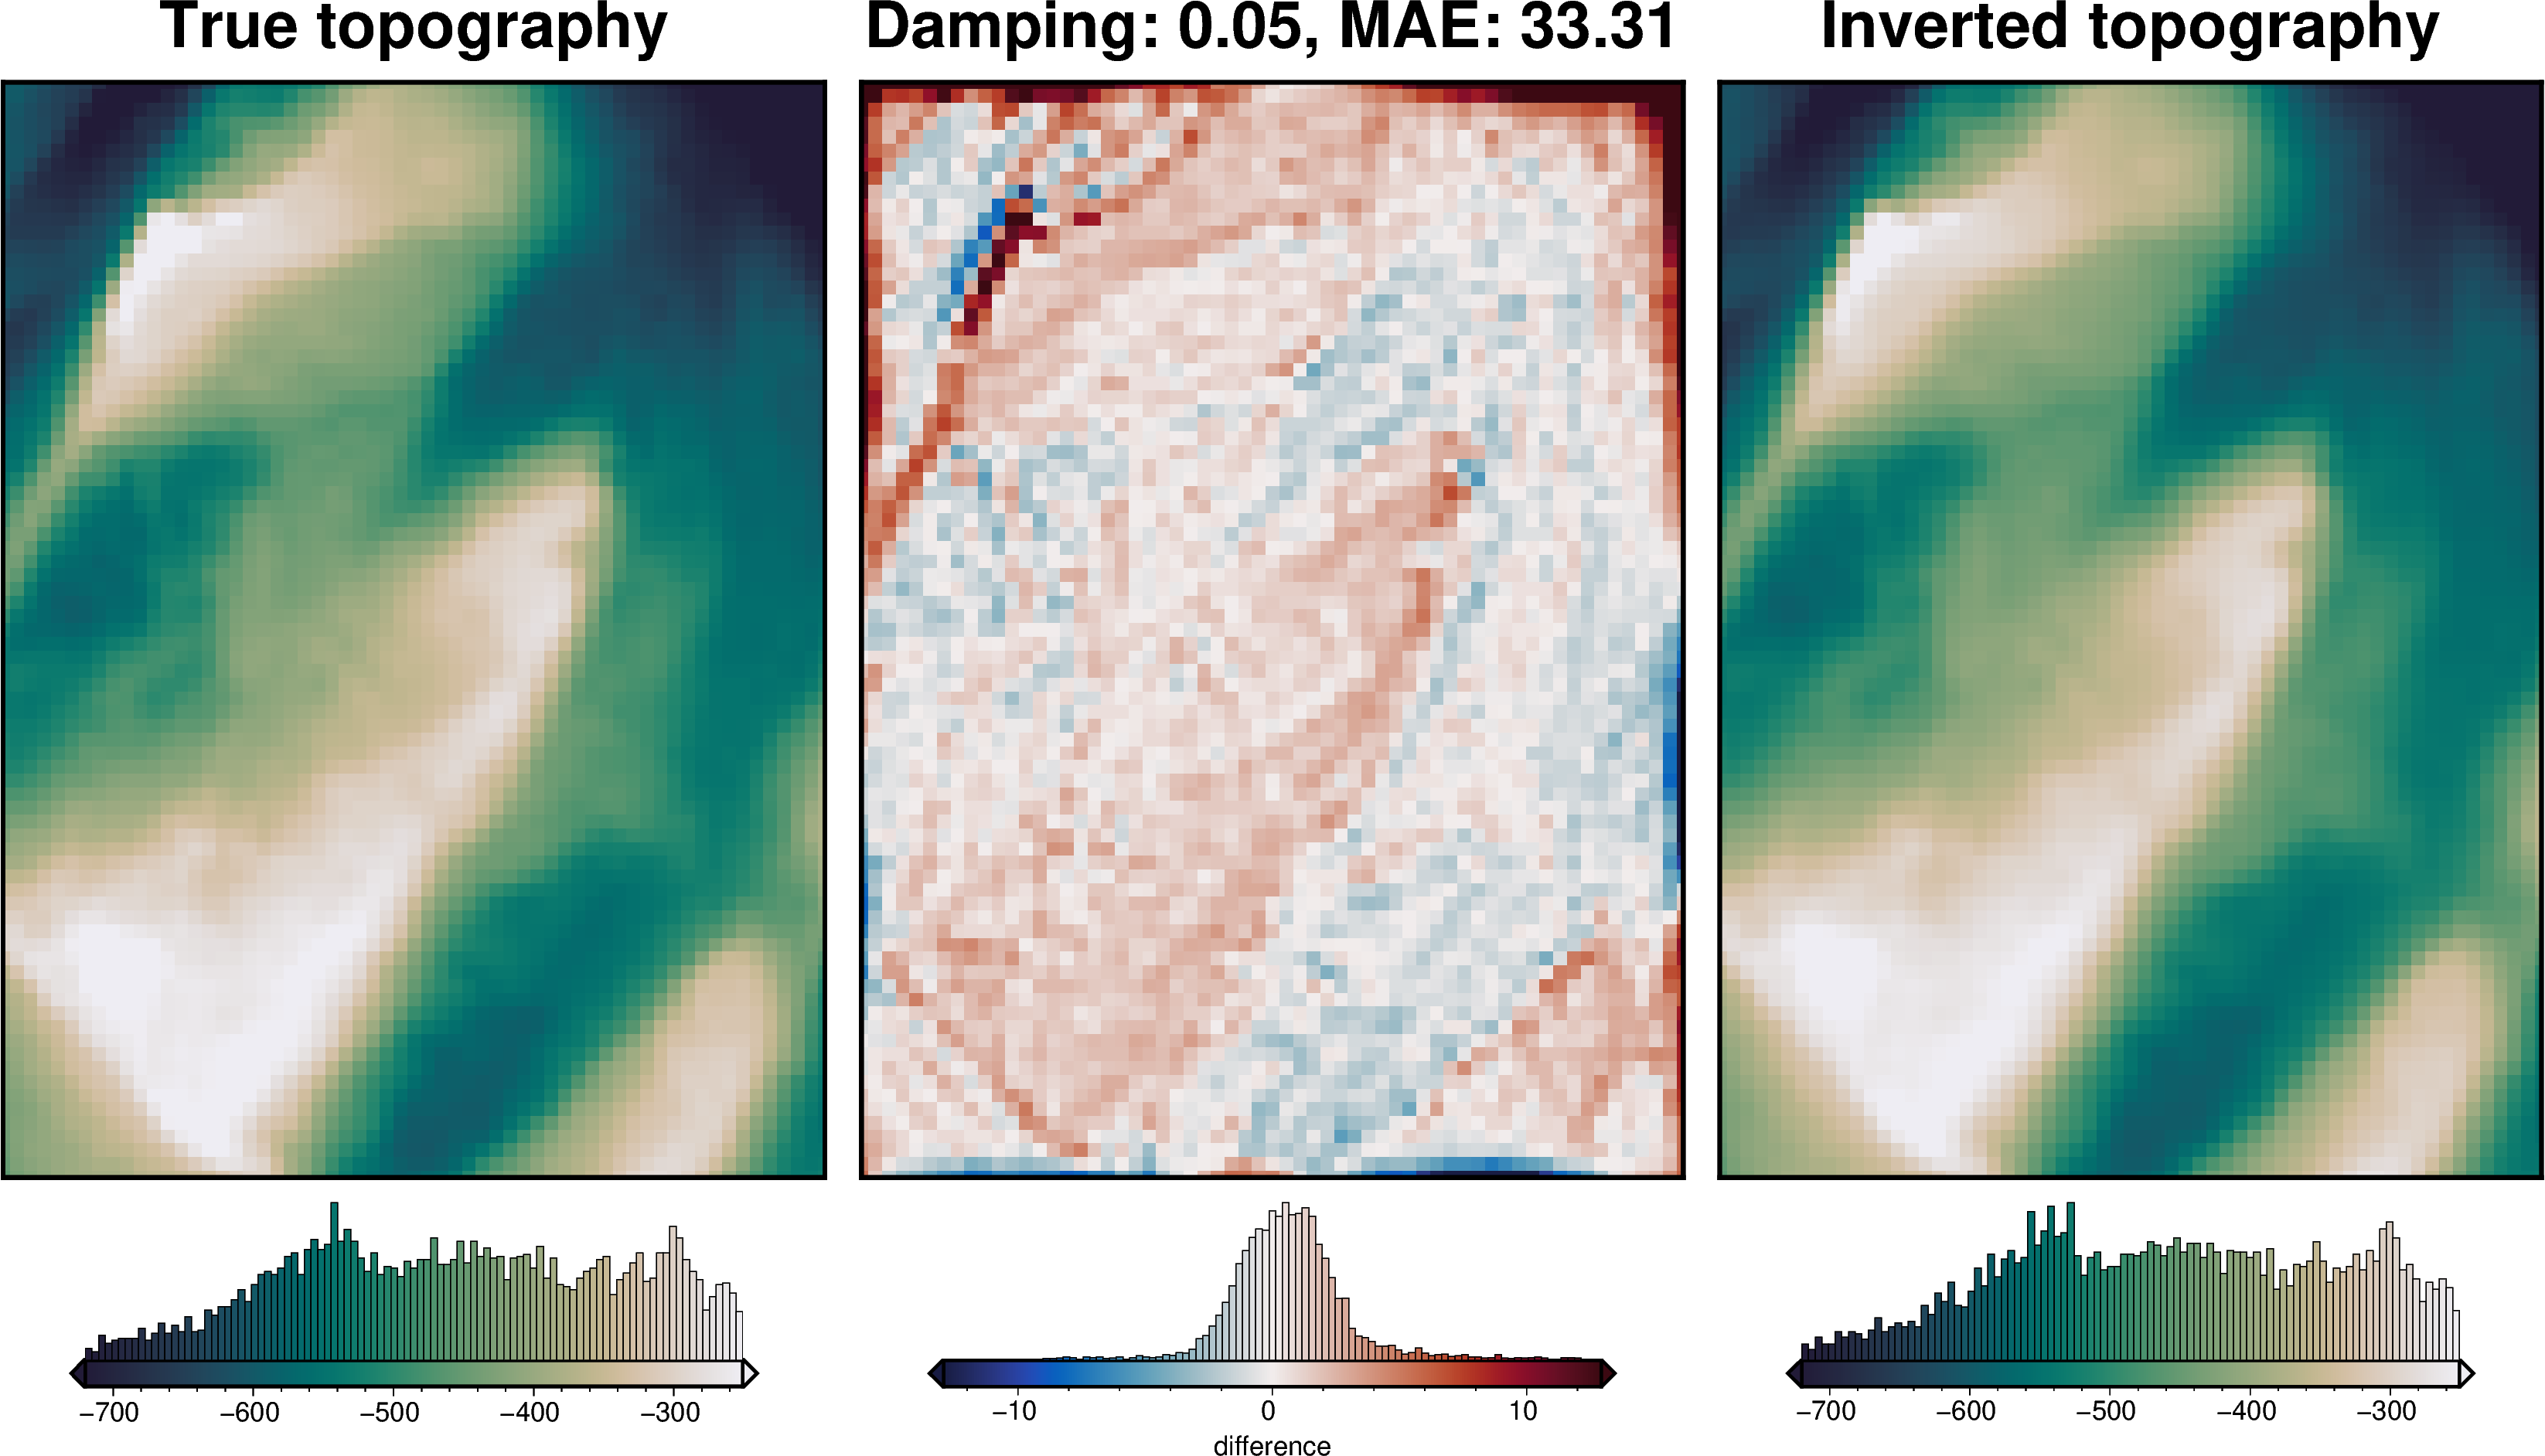

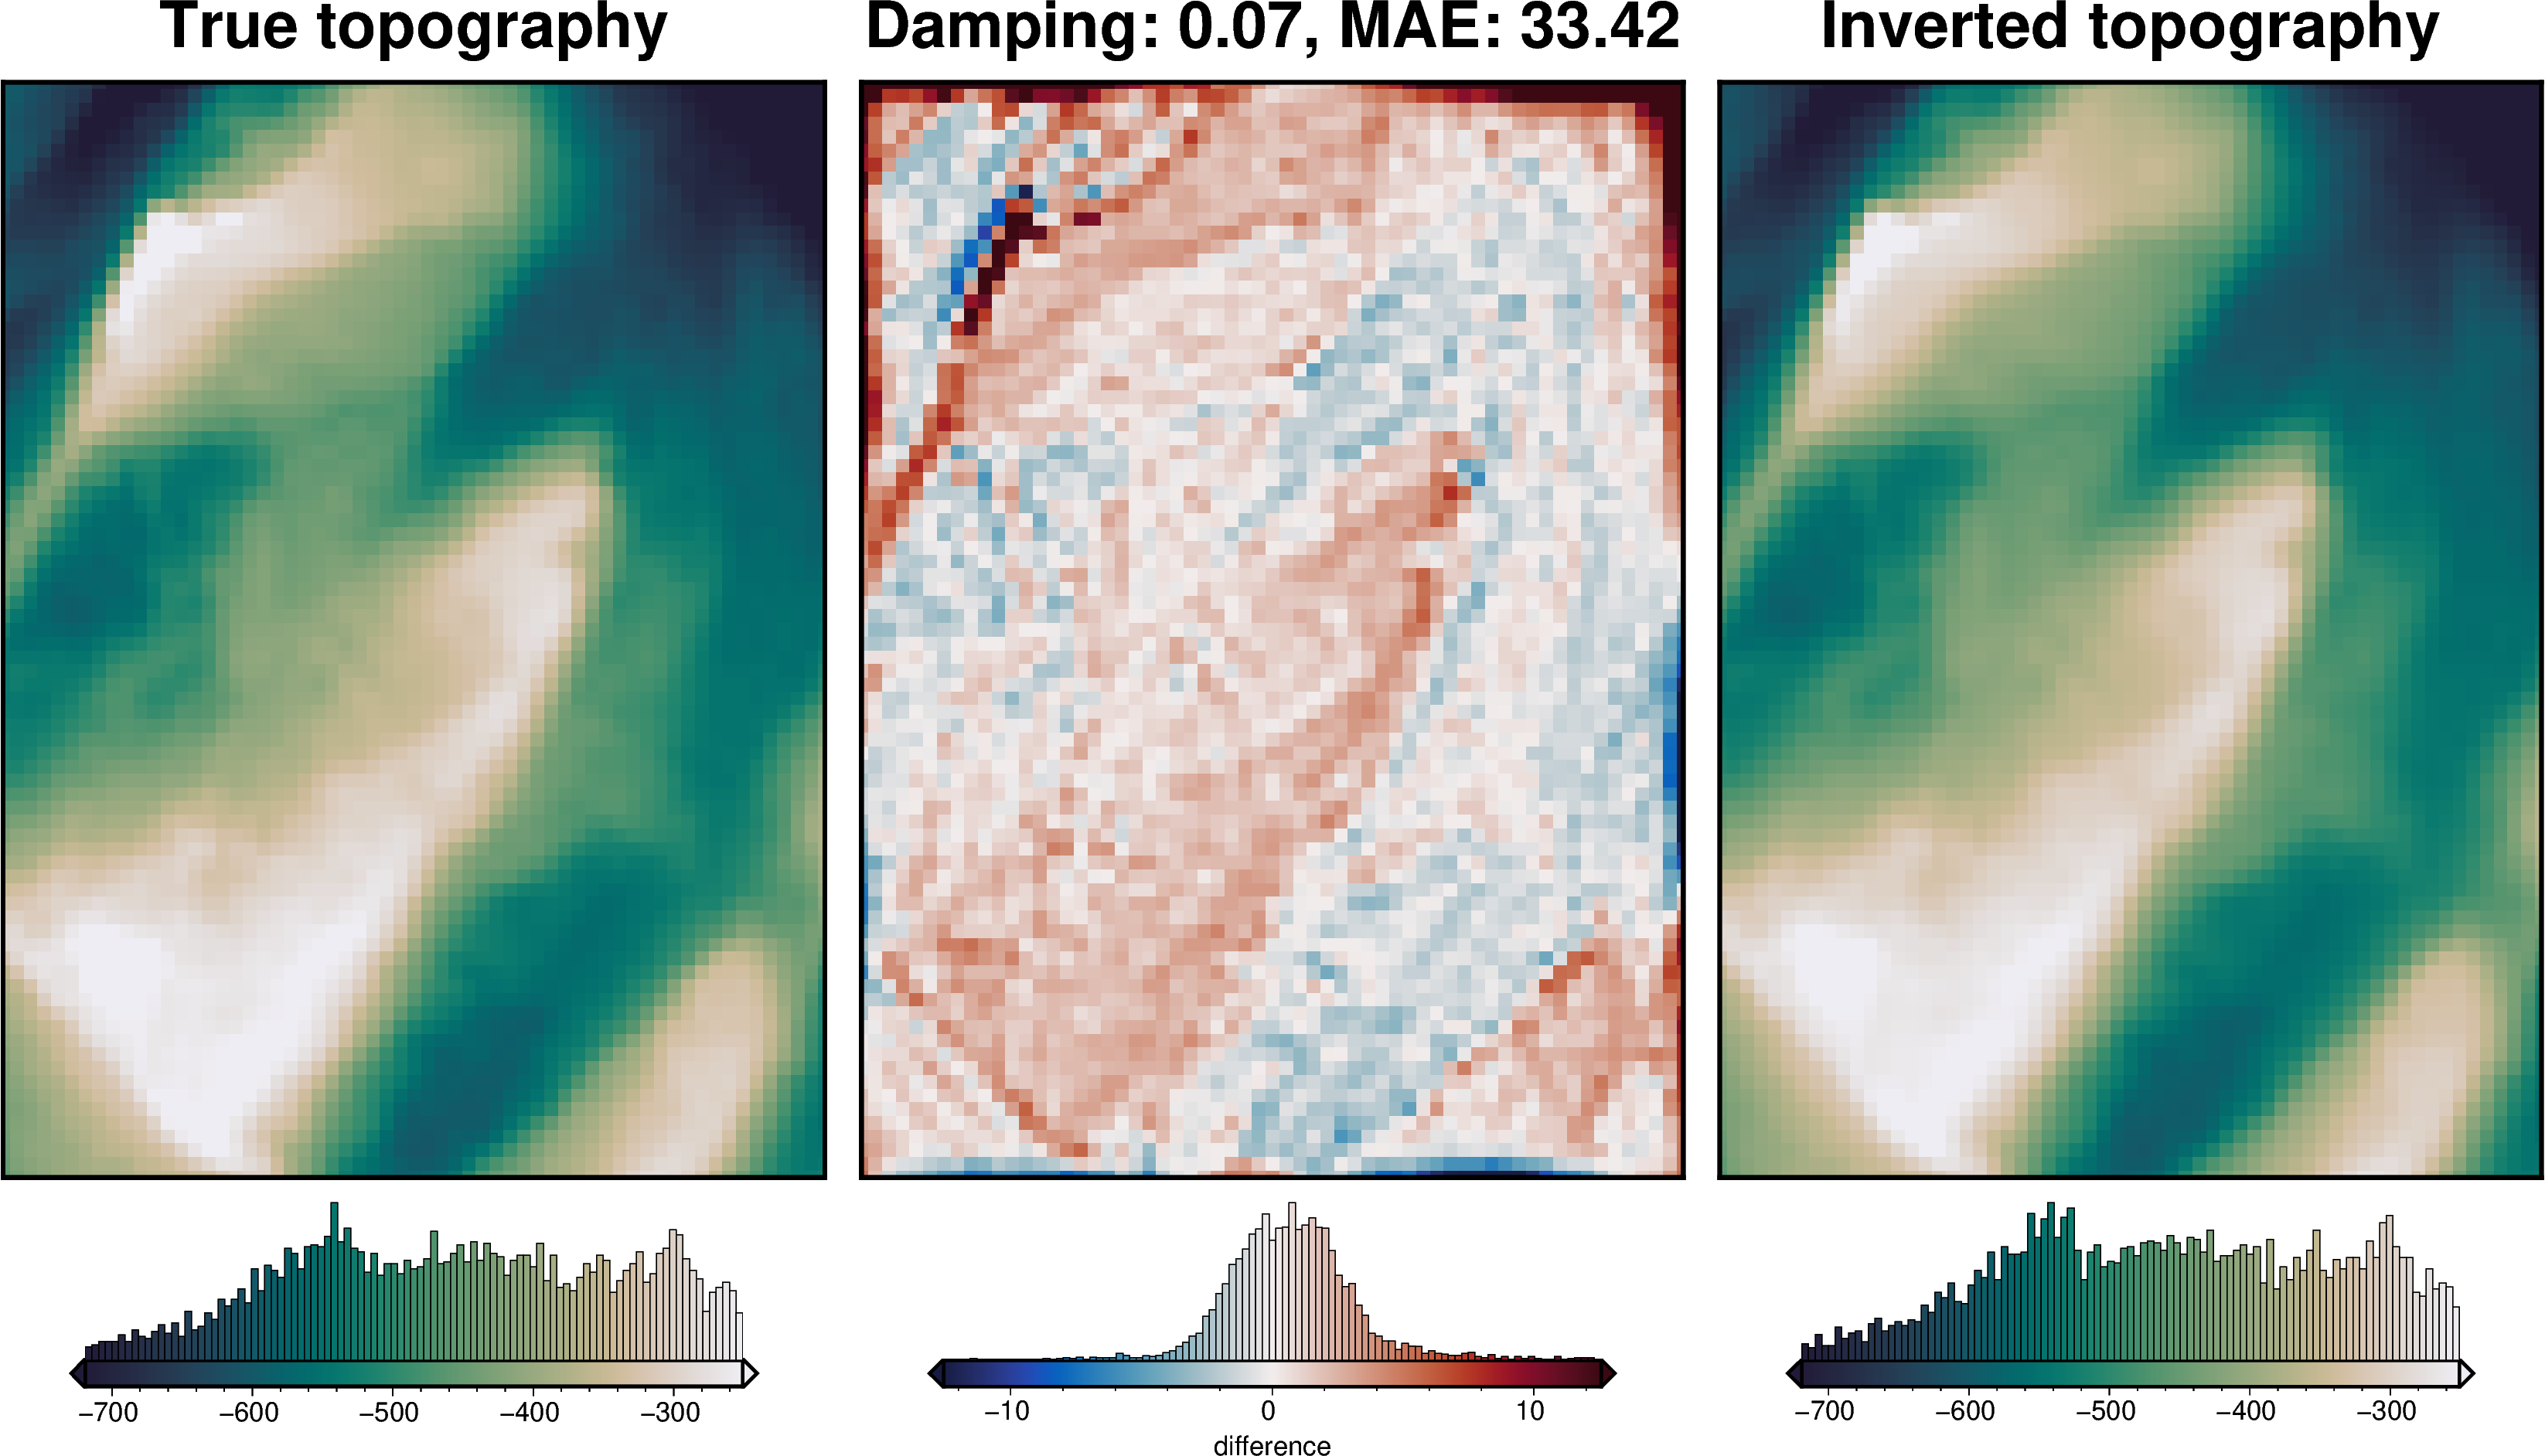

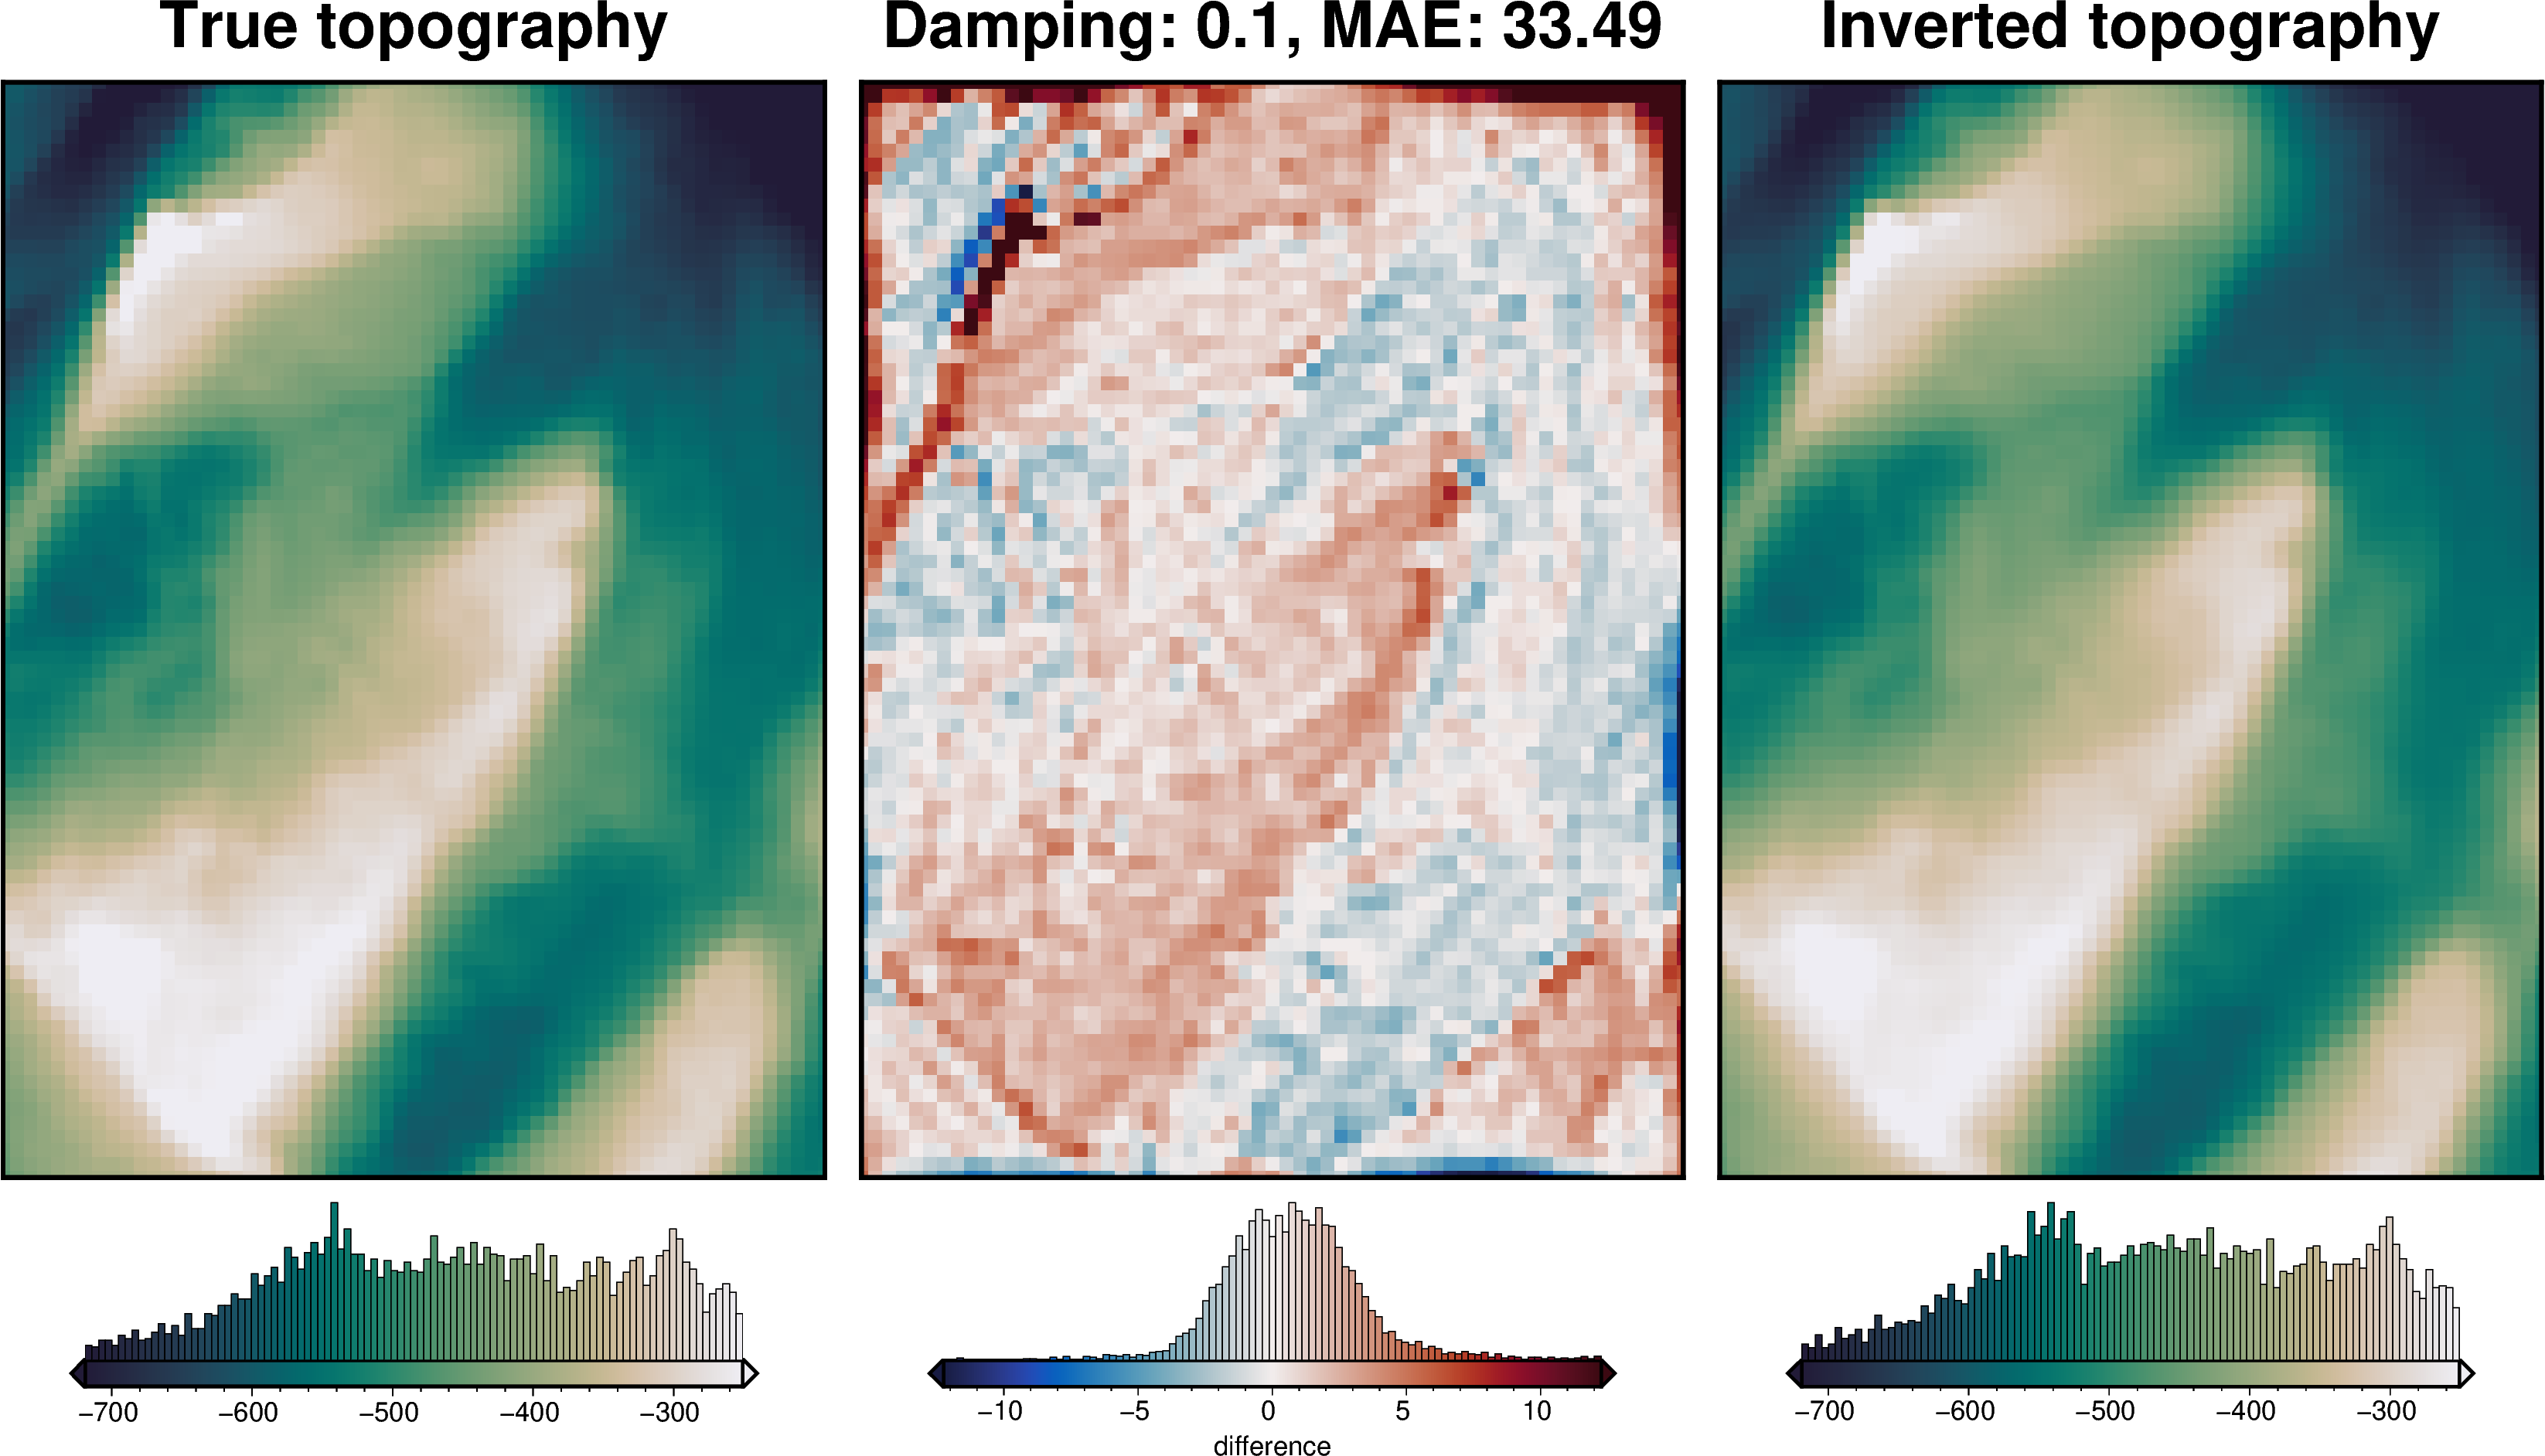

In [24]:
dampings = [
    (t.params["damping"], t.user_attrs["results"][0]) for t in study.get_trials()
]
dampings = sorted(dampings, key=lambda x: x[0])

for damp, df in dampings:
    final_topography = df.set_index(["northing", "easting"]).to_xarray().topo

    _ = polar_utils.grd_compare(
        bathymetry,
        final_topography,
        region=inversion_region,
        plot=True,
        grid1_name="True topography",
        grid2_name="Inverted topography",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title=f"Damping: {round(damp,3)}, MAE: {round(float(np.mean(np.abs(bathymetry-final_topography))),2)}",
        rmse_in_title=False,
        grounding_line=False,
        reverse_cpt=True,
        cmap="rain",
    )

# Uncertainty analysis

## Inversion error

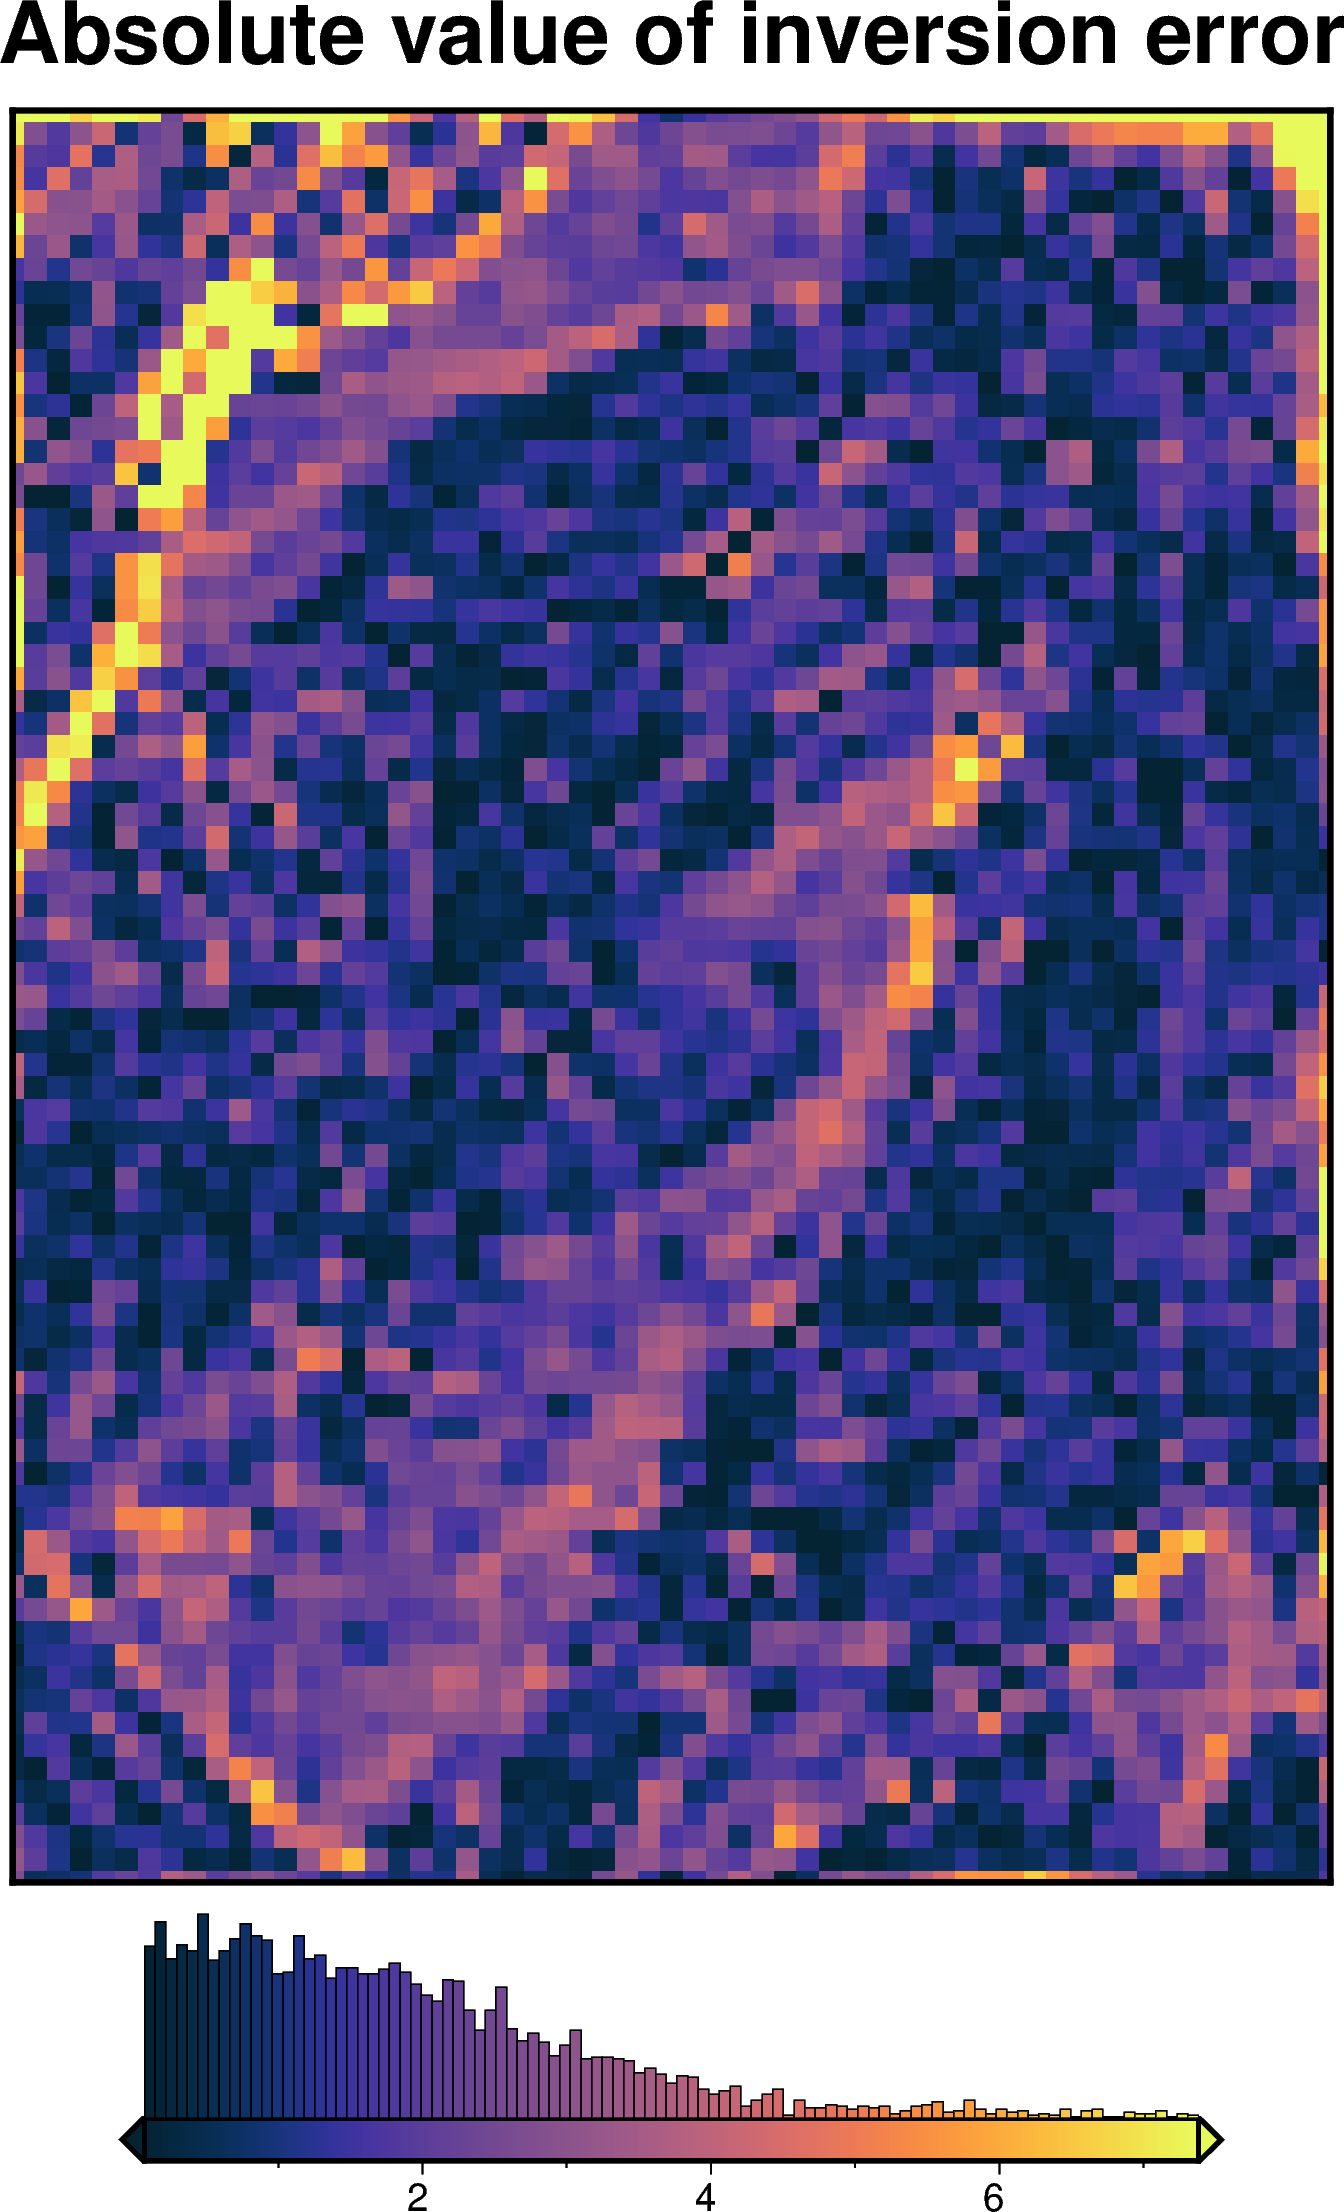

In [270]:
inversion_error = np.abs(bathymetry - final_topography)

fig = maps.plot_grd(
    inversion_error,
    region=vd.pad_region(inversion_region, -spacing),
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
)
fig.show()

In [24]:
# kwargs to reuse for all uncertainty analyses
uncert_kwargs = dict(
    grav_df=grav_df,
    density_contrast=density_contrast,
    zref=zref,
    starting_prisms=starting_prisms,
    starting_topography=starting_bathymetry,
    regional_grav_kwargs=regional_grav_kwargs,
    **kwargs,
)

## get standard deviation of solver damping values

In [ ]:
# load study
with pathlib.Path("../../results/Ross_Sea_01_damping_cv_damping_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe().drop(columns=["user_attrs_results"])
study_df=study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2=study_df[(np.abs(study_df.value_zscore) < 2)]

stdev = np.log10(study_df2.params_damping).std()
print(f"calculated stdev: {stdev}")

# pick damping standard deviation based on optimization
# stdev = .05
print(f"using stdev: {stdev}")

calculated stdev: 0.348280491522169
using stdev: 0.348280491522169


best: 0.05043628221313192 
std: 0.348280491522169 
+1std: 0.1124665978124903 
-1std: 0.0226184361664773


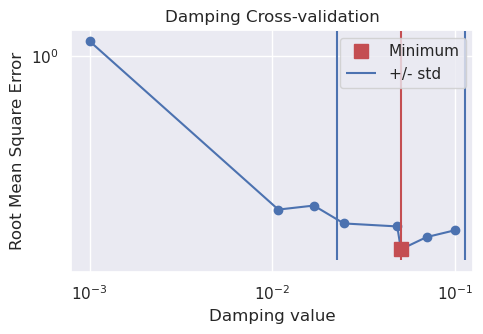

In [26]:
fig = plotting.plot_cv_scores(
    study.trials_dataframe().value.values,
    study.trials_dataframe().params_damping.values,
    param_name="Damping",
    logx=True,
    logy=True,
)
ax = fig.axes[0]

best = float(study_df2.params_damping.iloc[0])
upper = float(10**(np.log10(best)+stdev))
lower = float(10**(np.log10(best)-stdev))

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.06629895508438347, min: 0.013485673364437727, max: 0.18863118620319244
INFO:invert4geom:all 10 runs already complete, loading results from files.


stochastic ensemble: 0it [00:00, ?it/s]

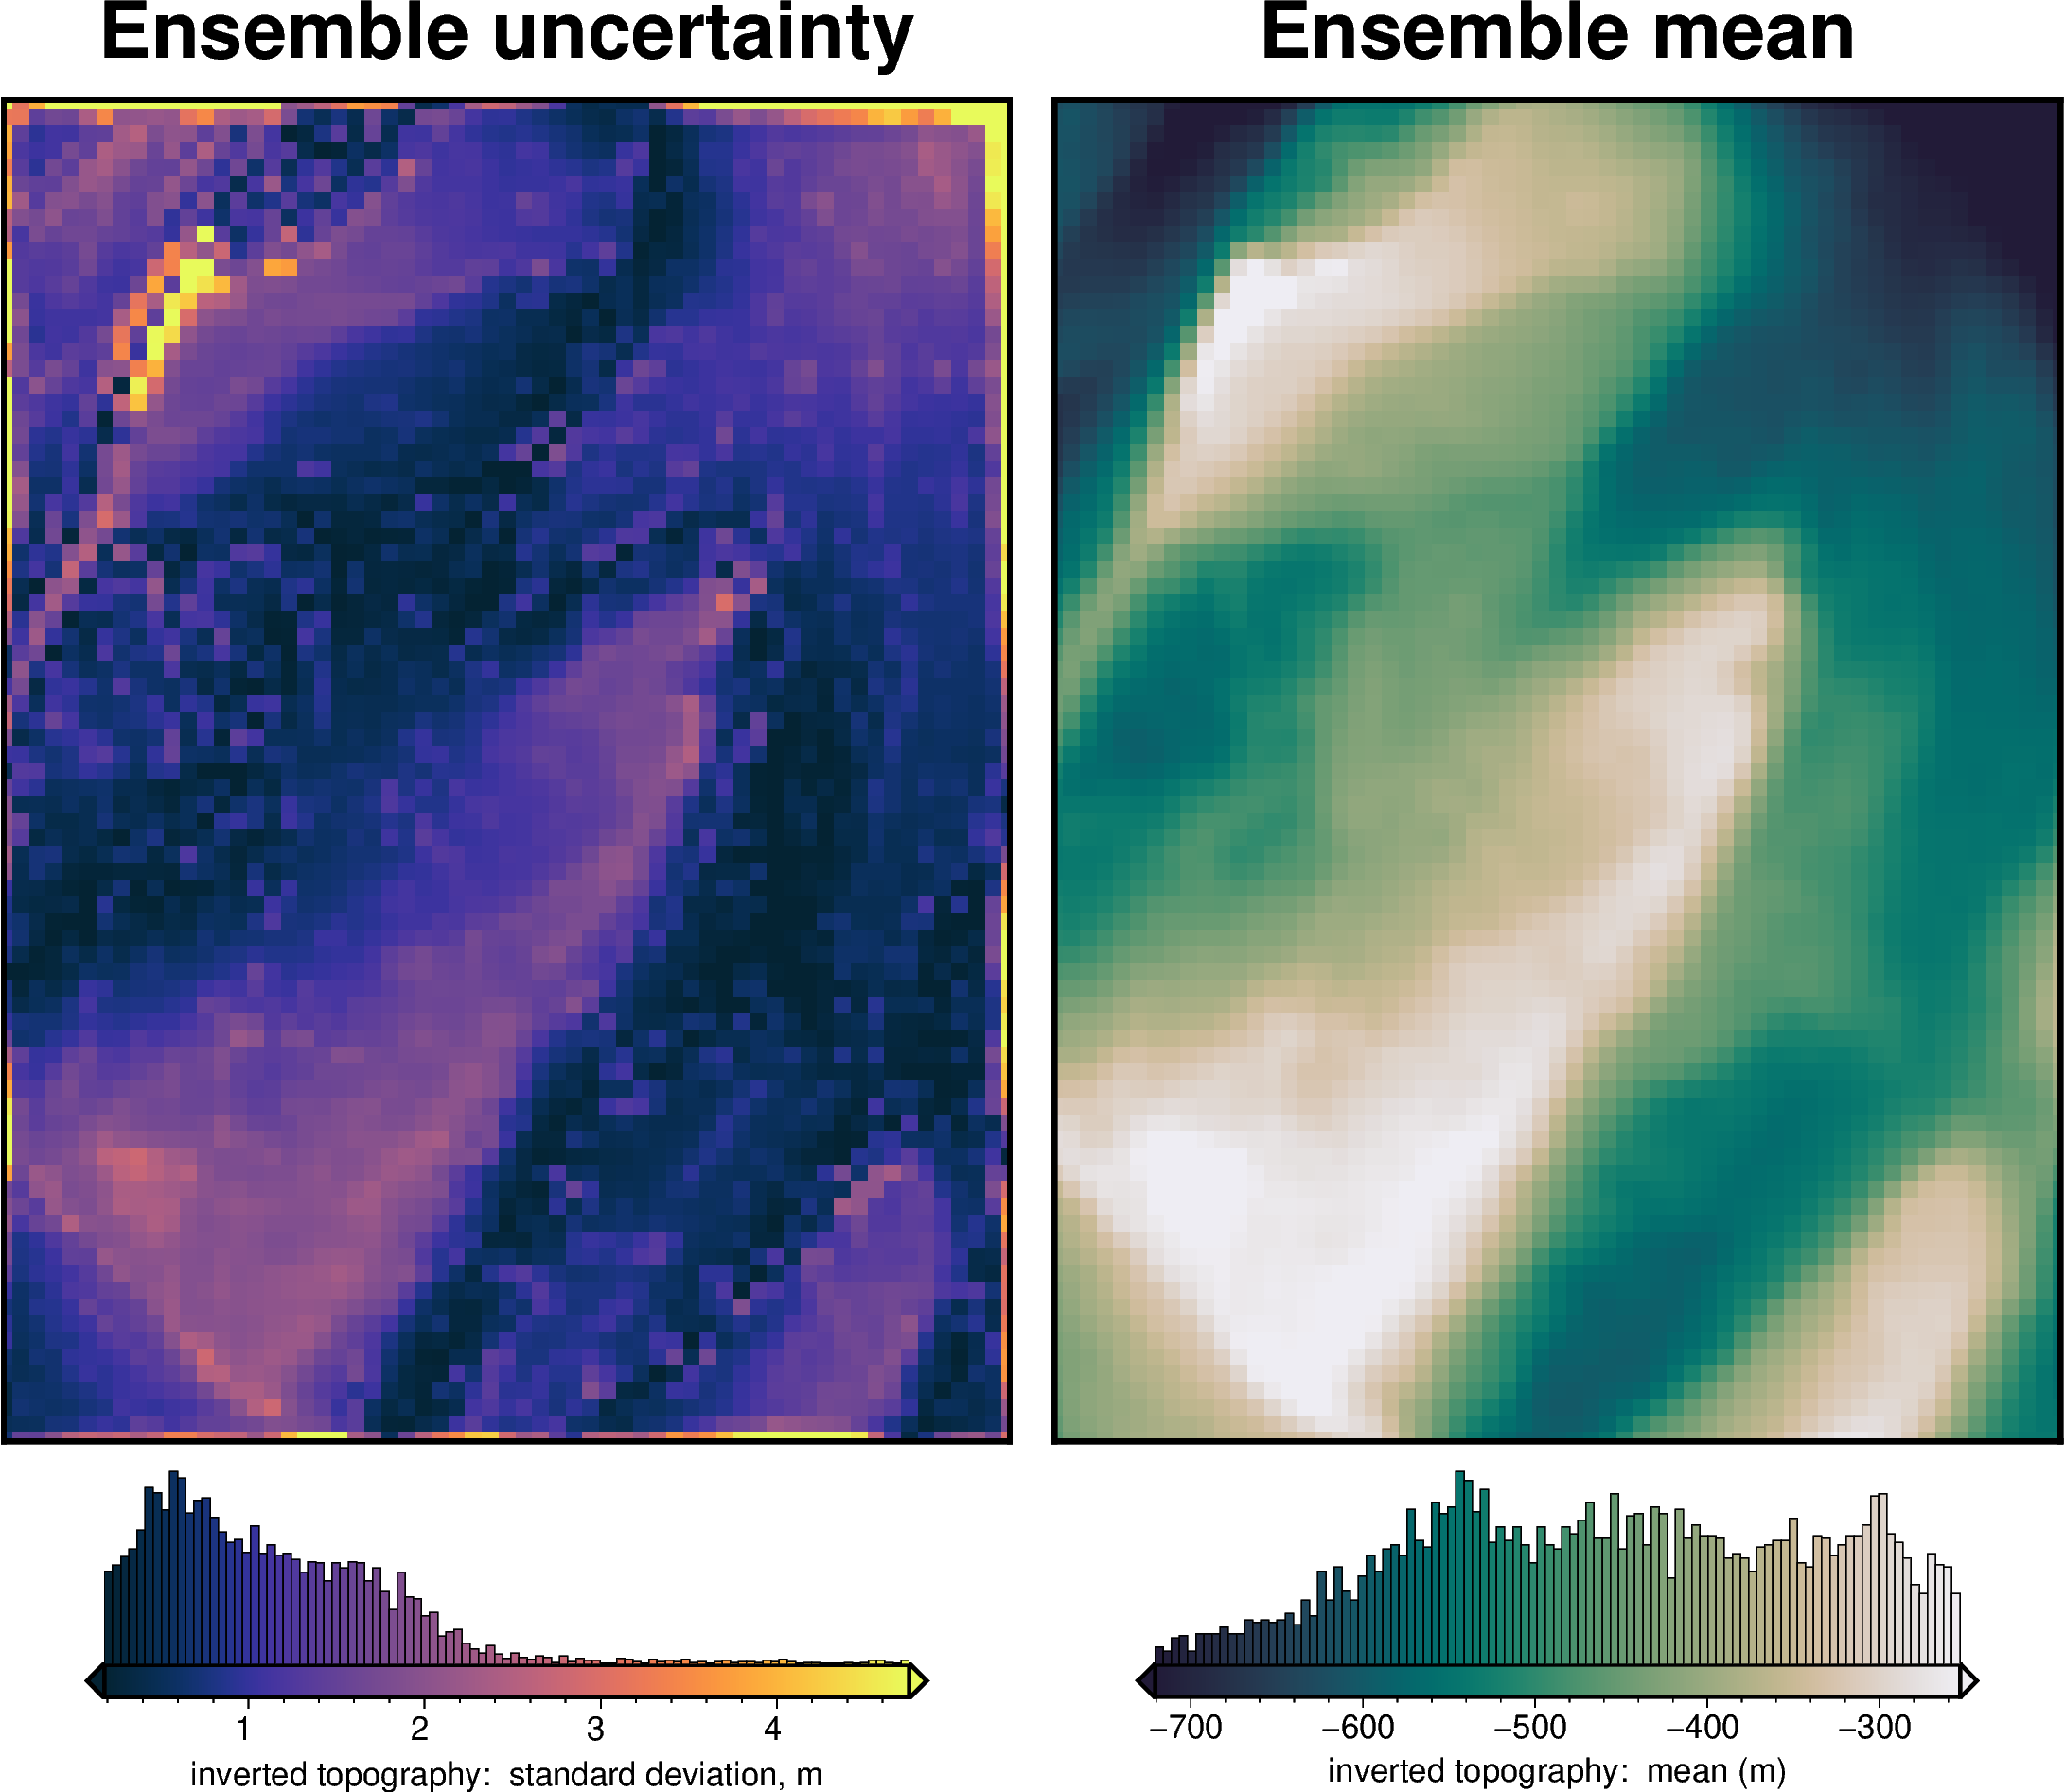

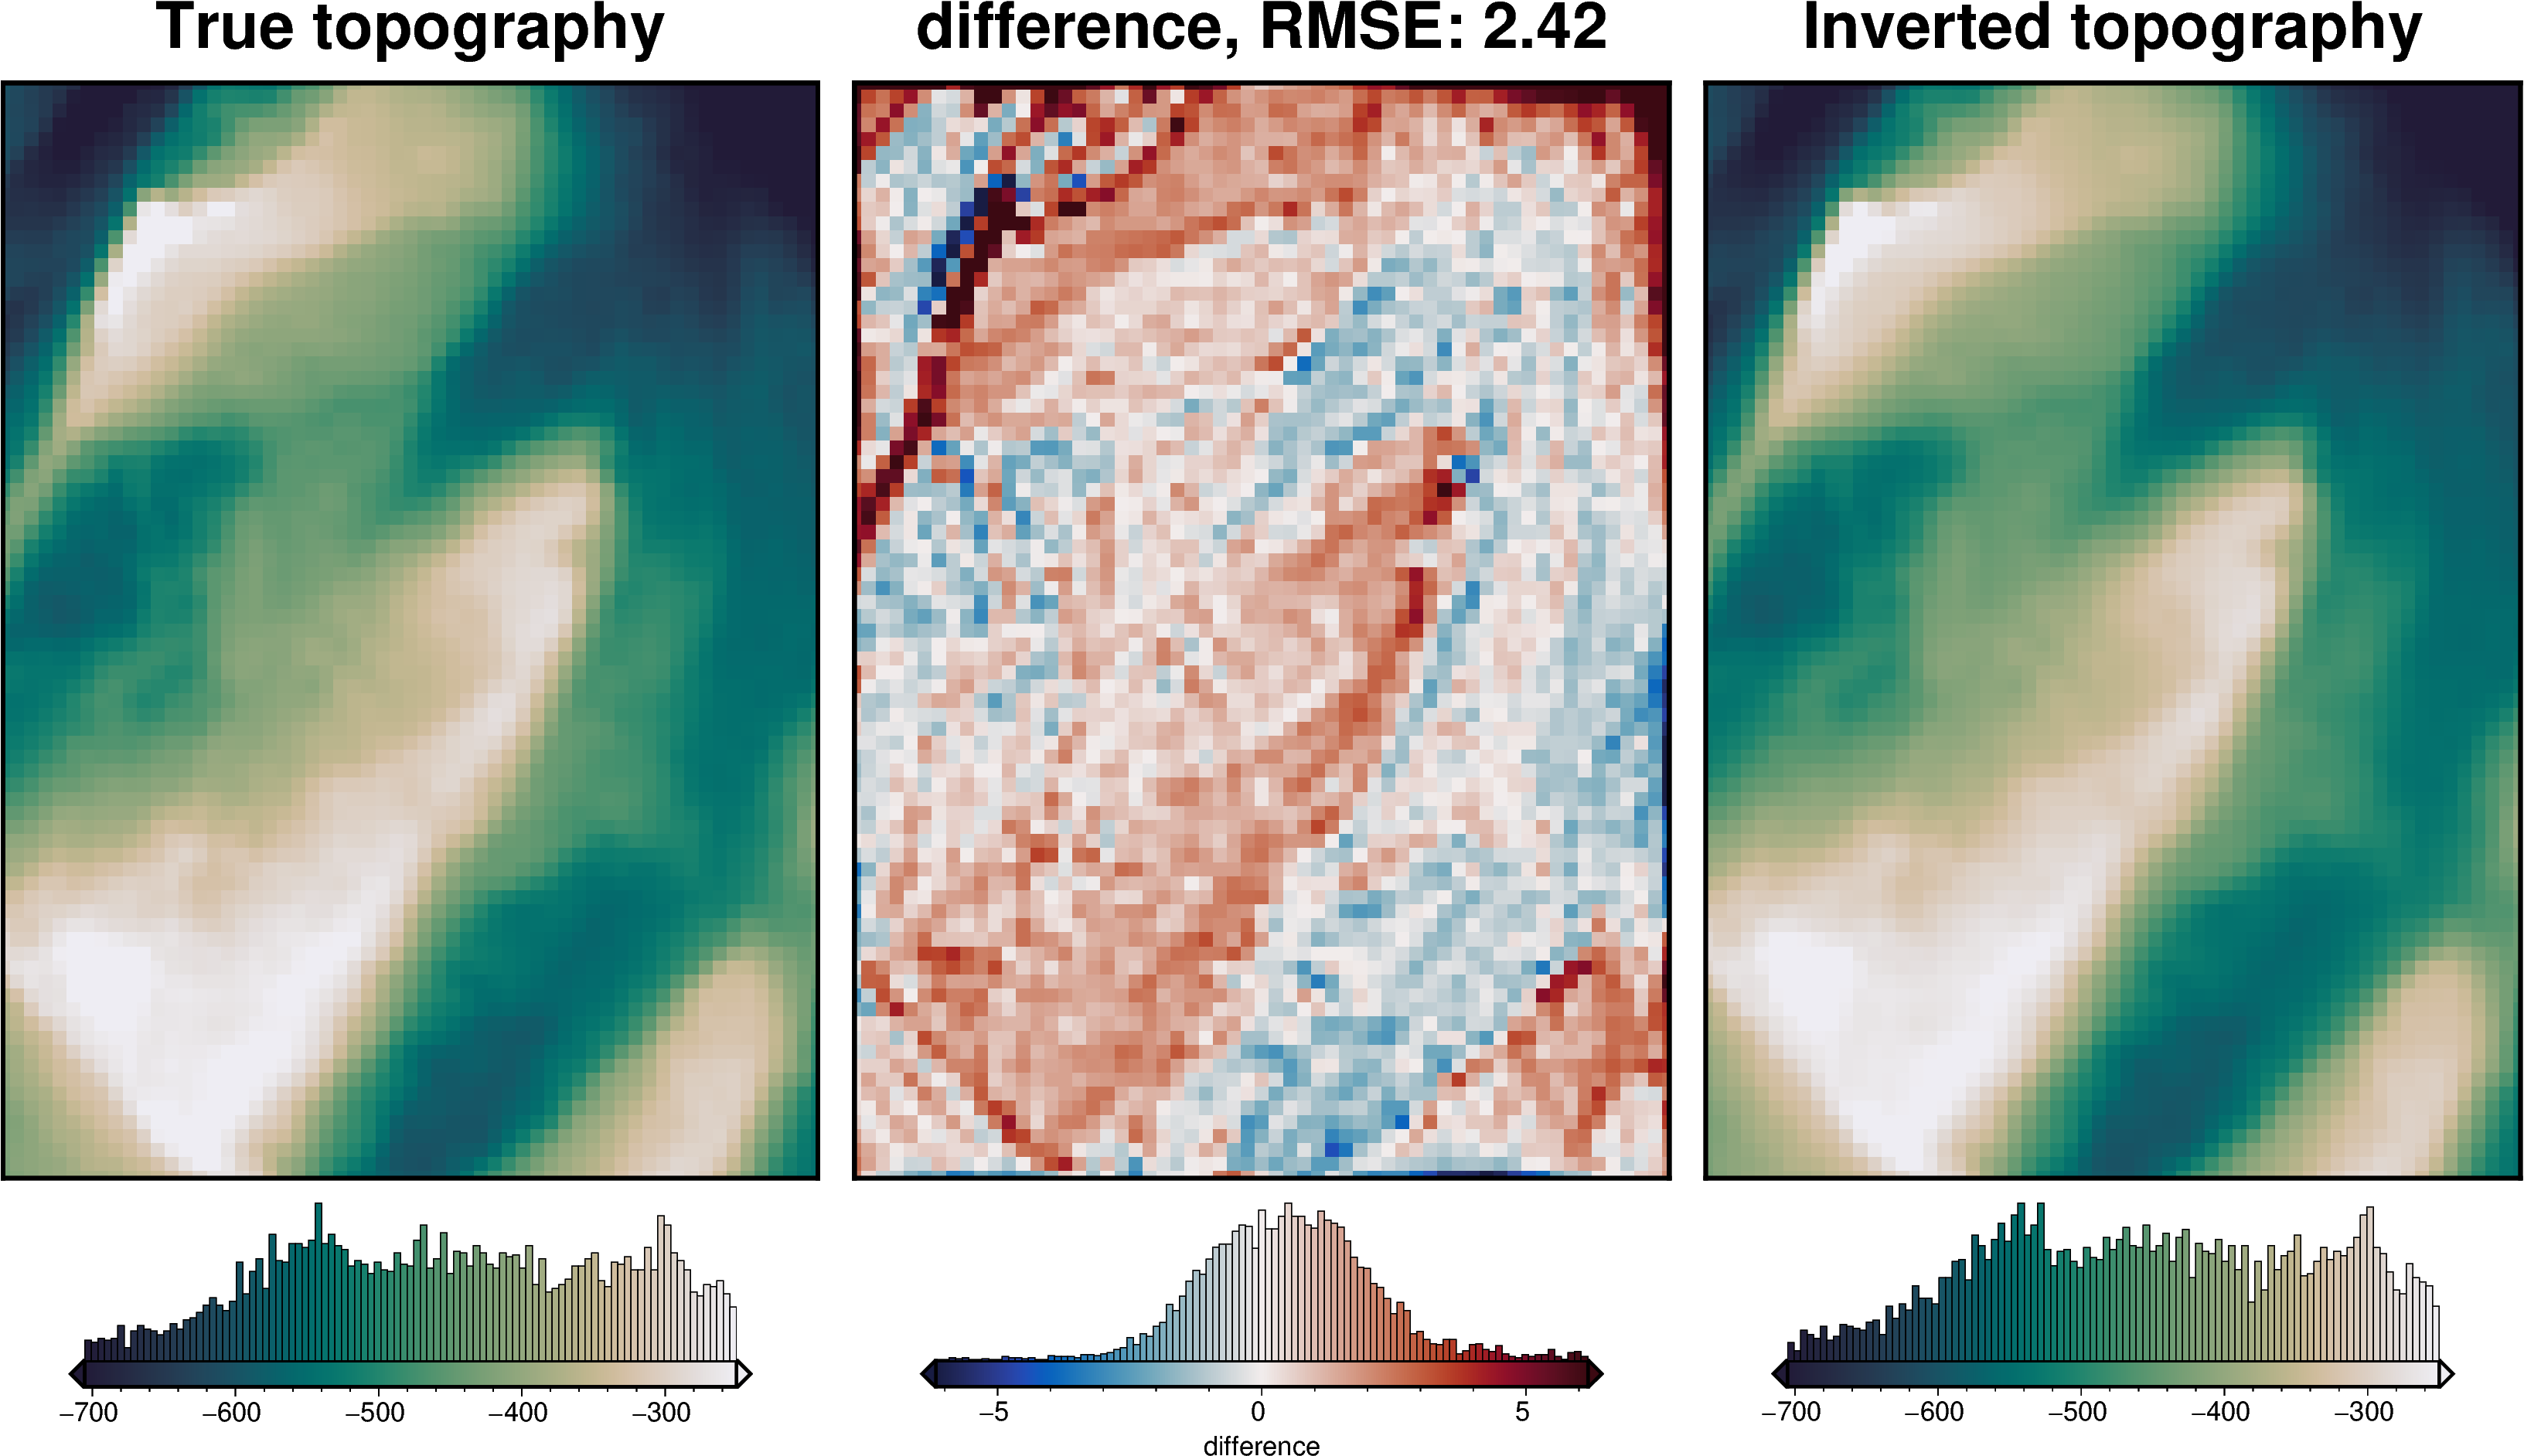

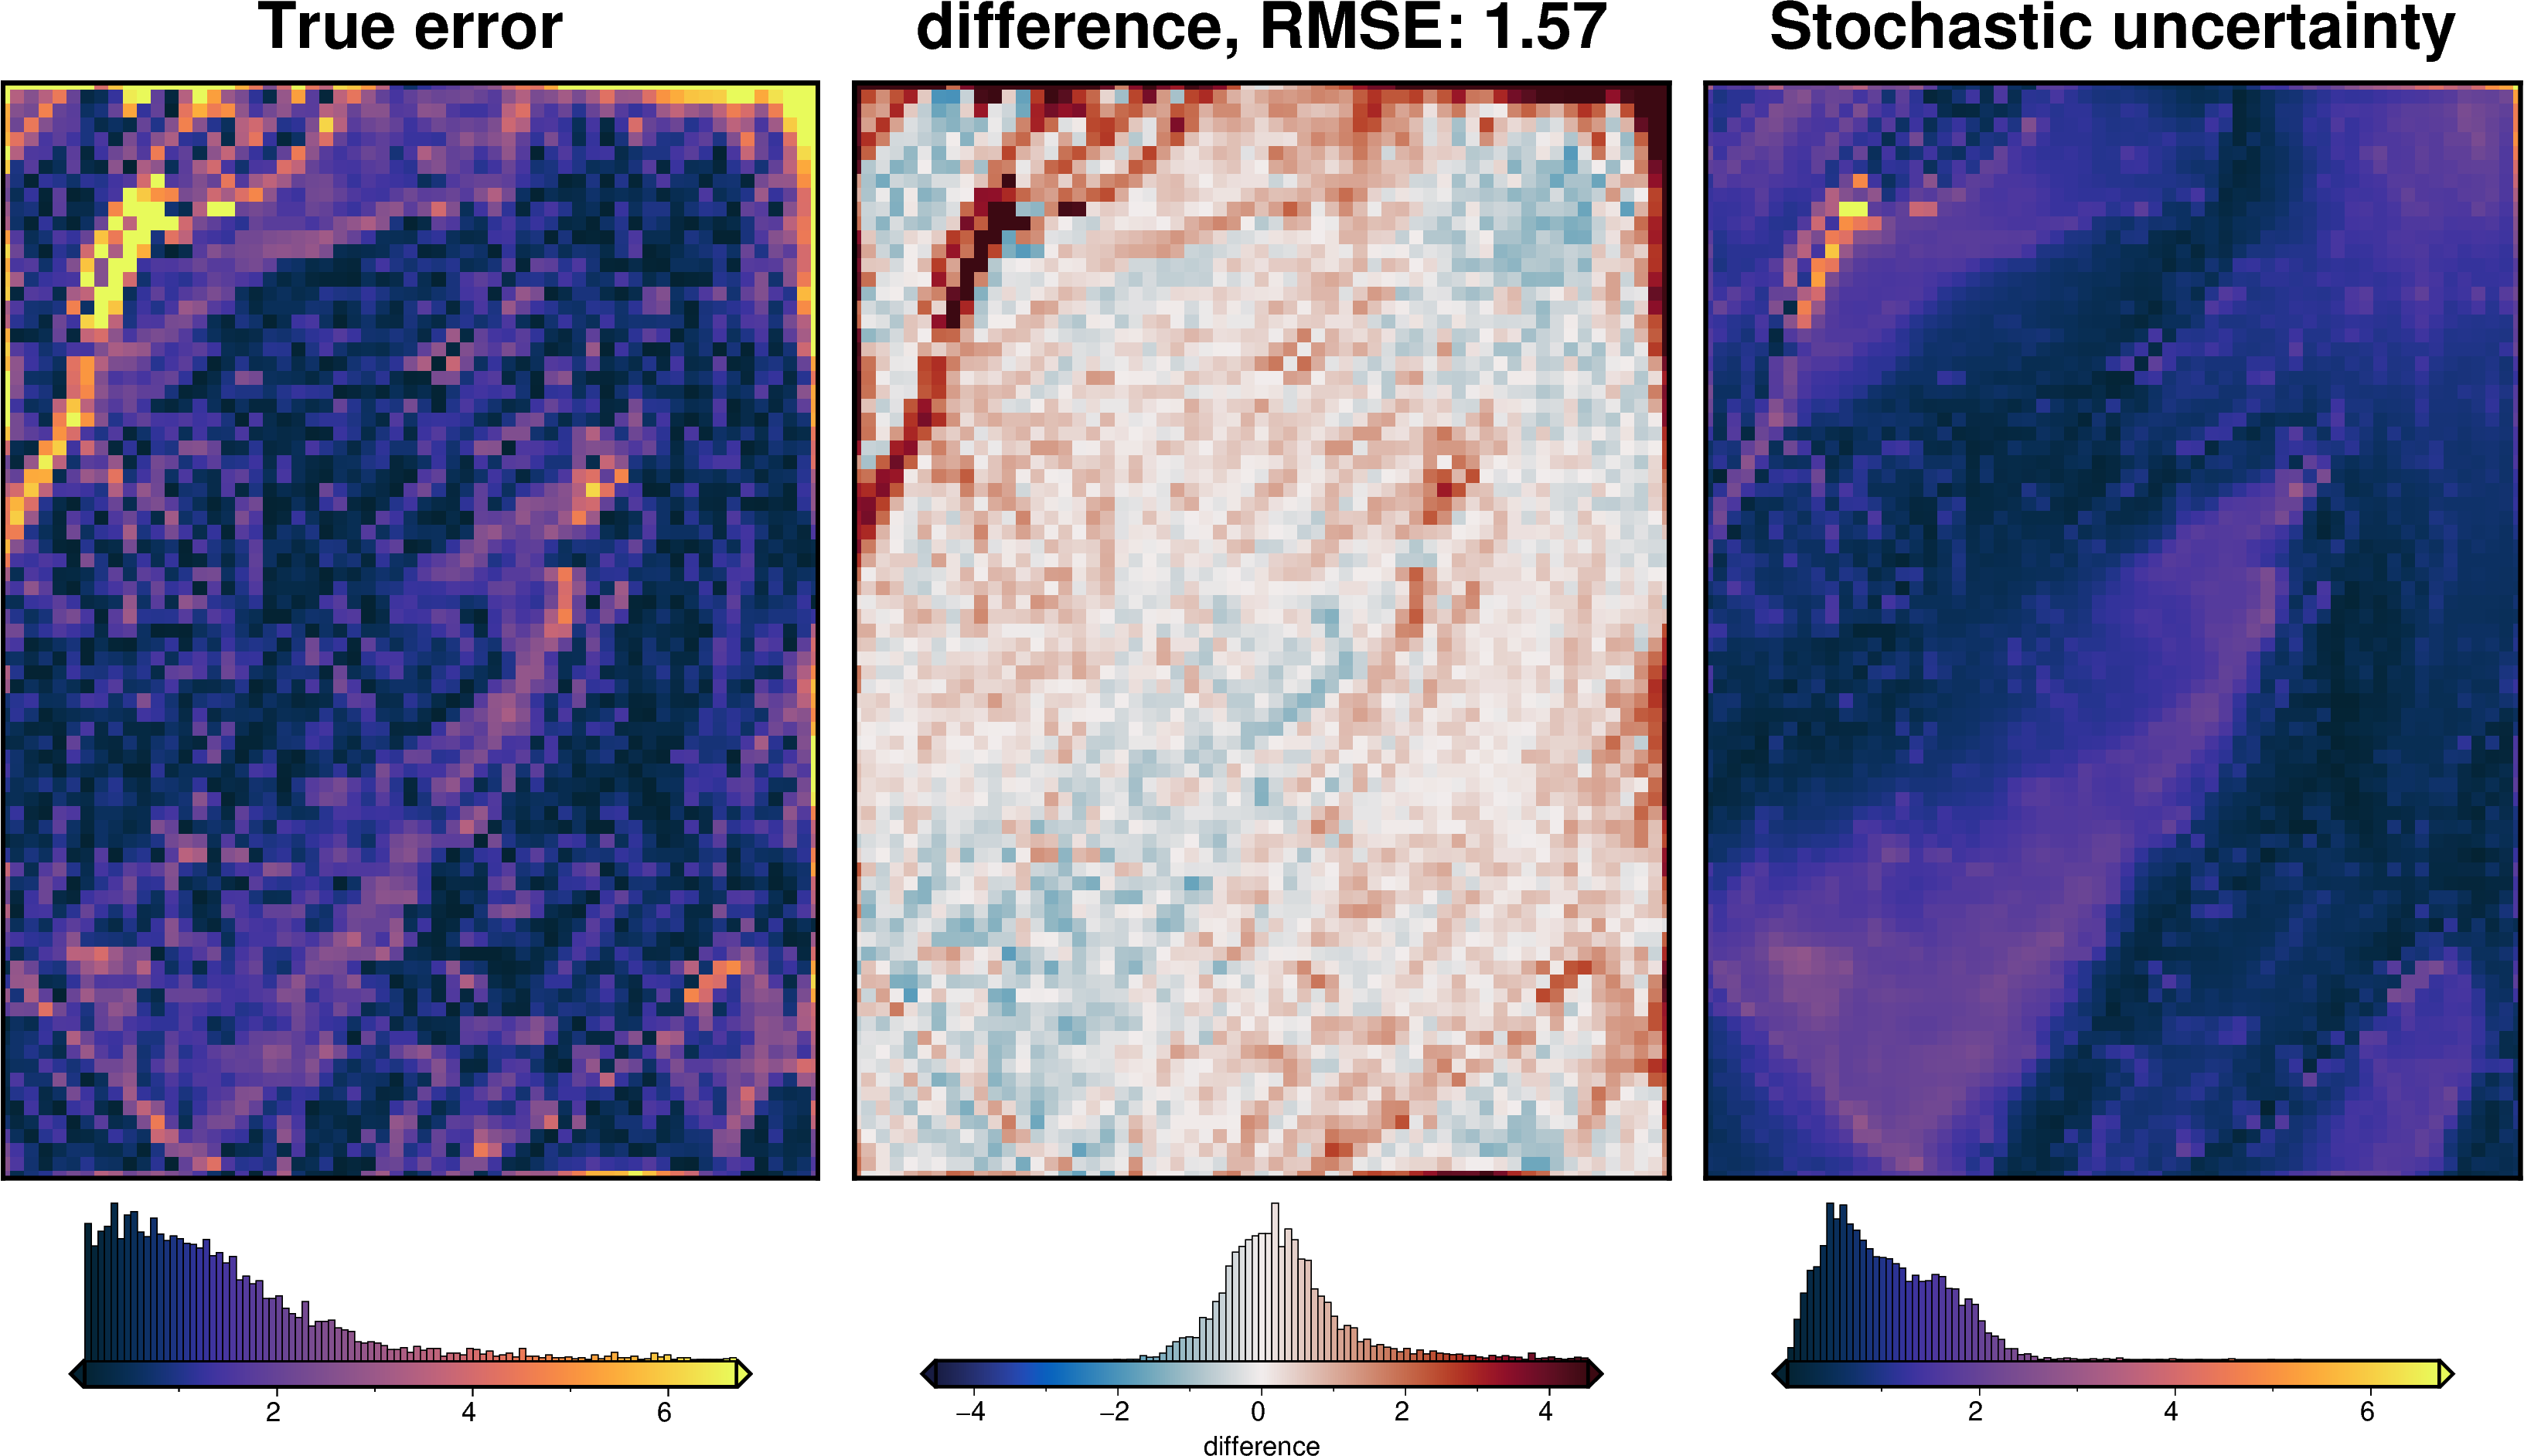

In [27]:
solver_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(best_damping),  # mean of base 10 exponent
        "scale": stdev,#0.2,  # standard deviation of base 10 exponent
        "log": True,
    },
}

fname = "../../results/Ross_Sea_01_uncertainty_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=solver_dict,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_damping_results,
    inversion_region,
    spacing,
    bathymetry,
    weight_by=None,
    # weight_by="residual",
)

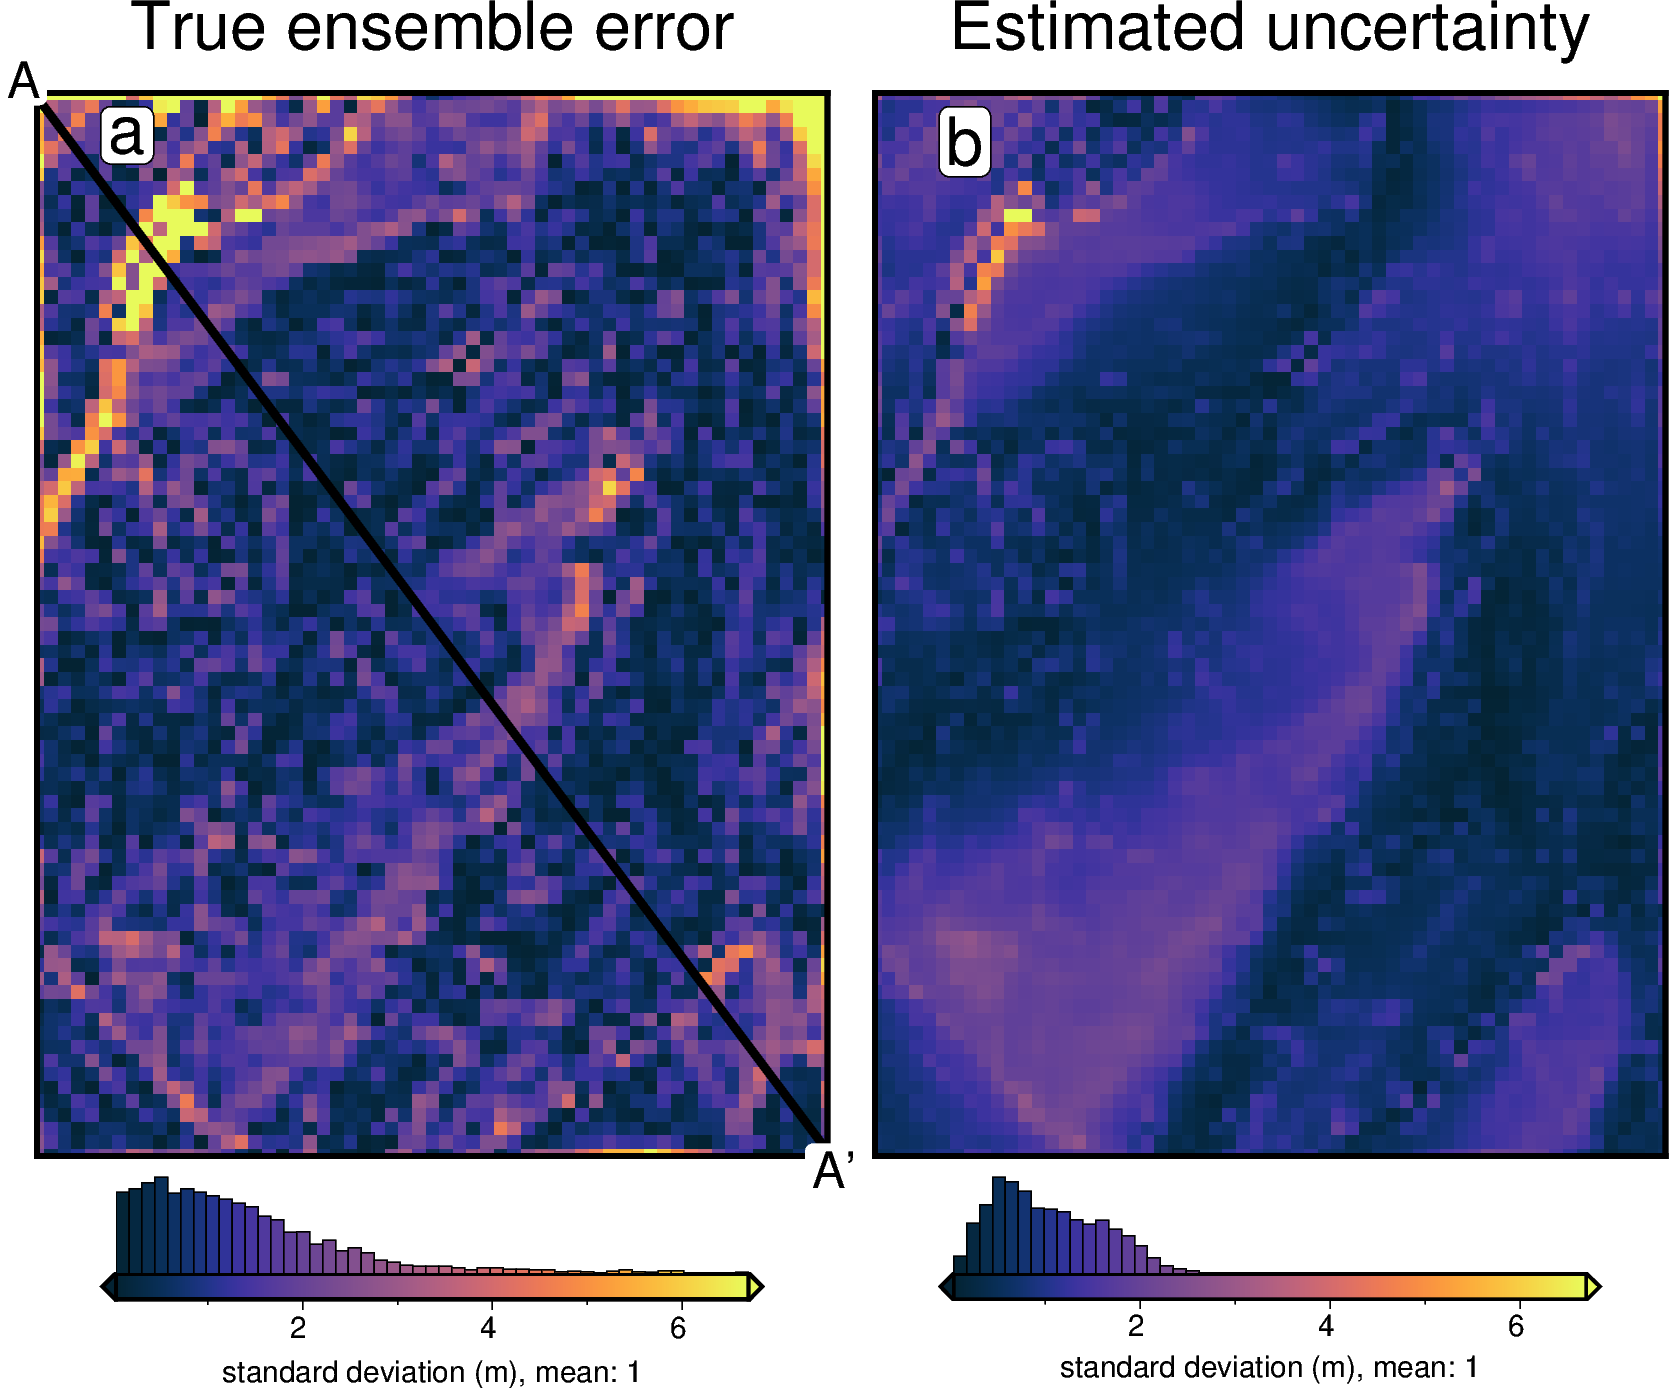

In [275]:
titles = ["True ensemble error", "Estimated uncertainty"]

try:
    mean = stats_ds.weighted_mean
    stdev = stats_ds.weighted_stdev
except AttributeError:
    mean = stats_ds.z_mean
    stdev = stats_ds.z_stdev

grids=[np.abs(mean - bathymetry), stdev]

inner_region = vd.pad_region(inversion_region, -spacing)
grids = [
    g.sel(
        {
            "easting": slice(*inner_region[:2]),
            "northing": slice(*inner_region[2:]),
        }
    )
    for g in grids
]

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
    elif i == 3:
        origin_shift = "both_shift"
        xshift_amount = -2
    else:
        origin_shift = "xshift"

    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        title=titles[i],
        title_font="16p,Helvetica,black",
        cmap="thermal",
        cpt_lims=polar_utils.get_min_max(grids[0], robust=True,),
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        hist_bin_num=50,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=-1.1,
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
    if i == 0:
        # plot profiles location, and endpoints on map
        start = [inversion_region[0], inversion_region[3]]
        stop = [inversion_region[1], inversion_region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
fig.show()

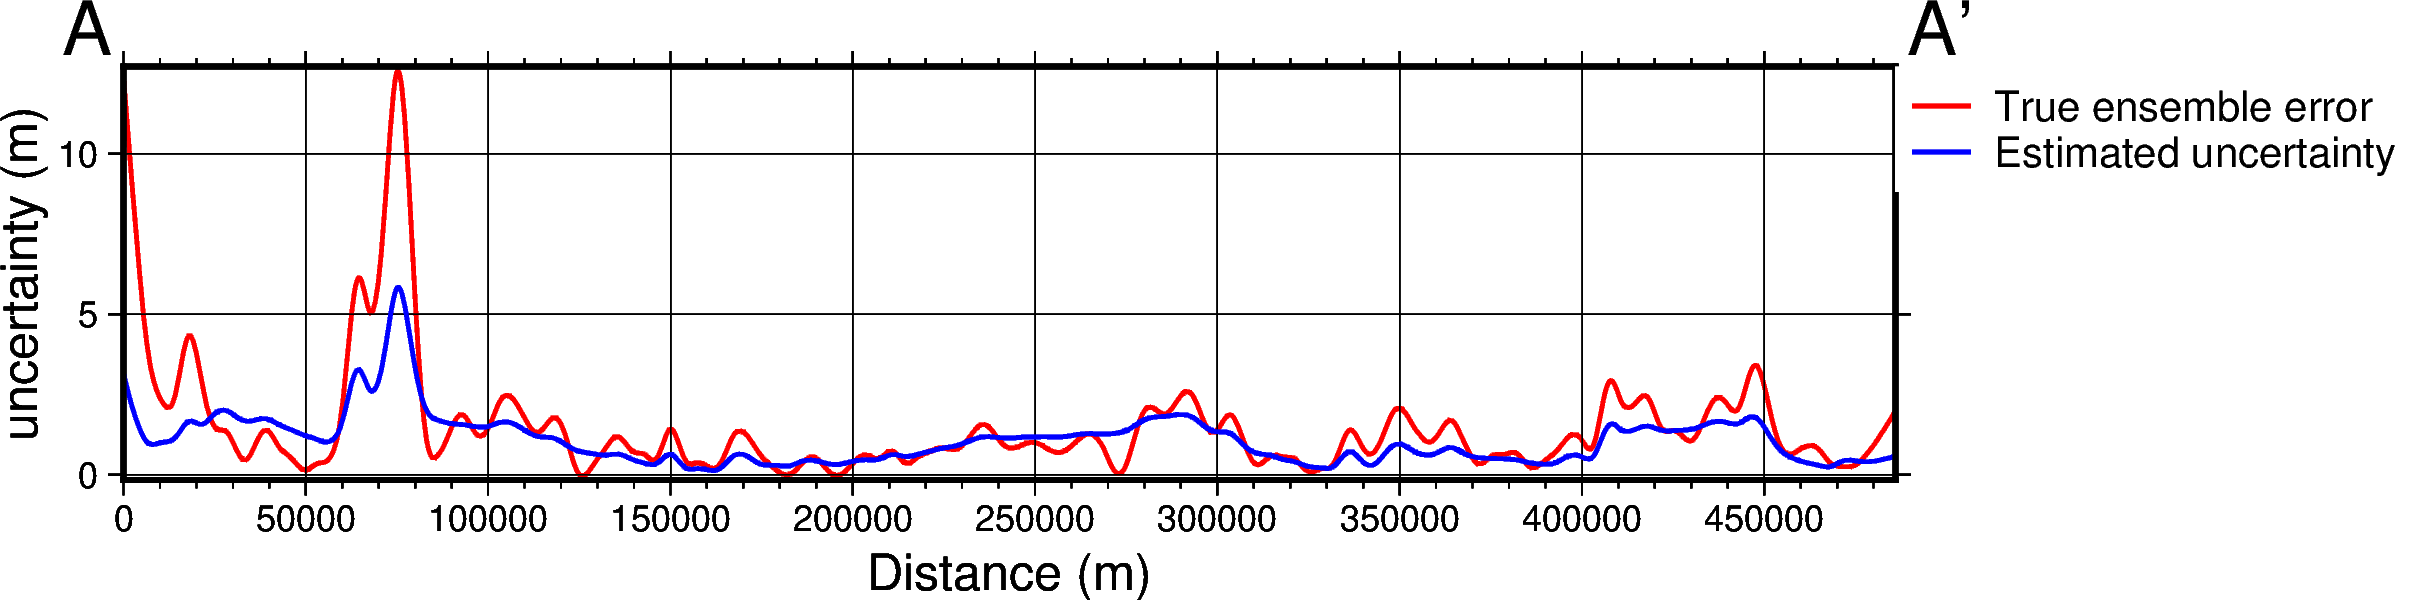

In [276]:
data_dict = profiles.make_data_dict(
    names=titles,
    grids=grids,
    colors=["red","blue"],
)

fig, df_data = profiles.plot_data(
    "points",
    start=[inner_region[0], inner_region[3]],
    stop=[inner_region[1], inner_region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jTR+jTL",
    data_legend_box="+gwhite",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    share_yaxis=True,
    start_label="A",
    end_label="A' ",
)
fig.show()

In [28]:
# save results
stats_ds.to_netcdf("../../results/Ross_Sea_01_uncertainty.nc")